# House Prices: Advanced Regression Techniques

## The Ames housing dataset

![](http://thebigphotos.com/wp-content/uploads/2018/07/ames-iowa.jpg)

## Introduction to the Ames dataset

The [Ames Housing Data Set](http://jse.amstat.org/v19n3/decock.pdf) is an **interesting and modern alternative** to the famous [Boston Housing Data Set from 1978](https://www.kaggle.com/c/boston-housing). The Ames Housing Data Set was collected by [Dean De Cock](https://www.linkedin.com/in/dean-de-cock-b5336537), Professor of Statistics at Truman State University, in 2011. 

The dataset contains **data of individual residential properties in Ames, Iowa from 2006 to 2010**. The full dataset consists of 2930 samples with 80 features. 

In this Kaggle competition we  **just work on a subset with only 1460 of the observations (for training)** and 1459 observations where we do not have the sale price (the test set). 

> <span style="color:darkred">To get this out of our way – **everybody could possibly cheat** by e.g. simply training a model on [the full dataset](https://www.kaggle.com/prevek18/ames-housing). And obviously some scores on the leaderboard seem to good to be true. Anyway... 🤷‍♀️ 

## A Little Overview of the dataset

Dean De Cock created the dataset for his students as a final project in an undergraduate regression course. De Cock's [detailed description](http://jse.amstat.org/v19n3/decock.pdf) already gives a lot of useful information and hints in addition to the [features description that we have in the Kaggle data package and that can also be downloaded from here](http://www.amstat.org/v19n3/decock/DataDocumentation.txt).

We get for example these details:
* **80 variables in total**: 23 nominal, 23 ordinal, 14 discrete and 20 continuous
* 20 **continuous**: relate to various area dimensions (e.g. lot size, total dwelling square footage etc.)
* 14 **discrete**: quantify number of items occurring in the house (e.g. kitchens, baths, etc.)
* 46 **categorical** ranging from 2 to 28 classes (e.g. smallest STREET, largest NEIGHBORHOOD)

With the **Parcel Identification Number (PID)** of the full/original dataset we can get [very detailed additional information for every property via this link](http://beacon.schneidercorp.com/). 

### 🔍 Oh... And where is Ames, actually?

![](https://i.imgur.com/UKwOY5z.png)

And thats a map of **Ames' residental areas** (neighborhoods) provided again by Dean De Cock ([full size PDF here](https://ww2.amstat.org/publications/jse/v19n3/decock/AmesResidential.pdf)):
![](https://i.imgur.com/FM0XoQy.jpg)

## Problem Statement Definition

We are asked to **predict sale prices for residential real estate properties** from describing features. We have a training set with 1460 observations and corresponding prices. We need to make predictions for 1459 observations where the price is not known to us.

><span style="color:darkgreen">**Our goal is to use the Ames Housing data set to build a machine learning model that can predict the sale price of a residential property.**

The data in the training set includes the sale price, which makes this **a supervised regression machine learning task**:

>**Supervised**: We have access to both the features and the target and our goal is to train a model that can learn a mapping between the two.  
>**Regression**: The sale price is a continuous variable.

Ideally we want to develop a model that is both **accurate** — it can predict the sale price close to the true value — and **interpretable** — we can understand the model predictions. 

## Machine Learning Methodology – step by step

We will follow these steps:

1. Exploratory data analysis (EDA)
2. Data cleaning and formatting
3. Feature engineering
4. Try and compare various machine learning models on a performance metric
5. Perform hyperparameter tuning for most promising models
6. Train best models on full data set and submit predictions

In **data cleaning and formatting** will especially take care of:

- Missing values
- Wrong values
- Wrong datatypes
- Outliers
- Skewed distributions


## 0.Import Libraries and Dataset

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns

import calendar

import pandas as pd
import numpy as np
from scipy import stats
from scipy.special import boxcox1p

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, RidgeCV
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import xgboost as xgb
import lightgbm as lgb

from google.colab import files
import warnings
warnings.filterwarnings('ignore')

plt.rc('font', size=12)        
plt.rc('axes', titlesize=22)      
plt.rc('axes', labelsize=18)      
plt.rc('xtick', labelsize=12)     
plt.rc('ytick', labelsize=12)     
plt.rc('legend', fontsize=12)   

plt.rcParams['font.sans-serif'] = ['Verdana']

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Install Kaggle library
!pip install -q kaggle
u = files.upload()
# upload ur kaggle api
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
# kaggle dataset
!kaggle competitions download -c house-prices-advanced-regression-techniques

Saving kaggle.json to kaggle.json
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 60.3MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 60.3MB/s]
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 13.3MB/s]
  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 27.6MB/s]


## 1.Exploratory data analysis

In [3]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df.head()

Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
0   1          60       RL  ...        WD         Normal    208500
1   2          20       RL  ...        WD         Normal    181500
2   3          60       RL  ...        WD         Normal    223500
3   4          70       RL  ...        WD        Abnorml    140000
4   5          60       RL  ...        WD         Normal    250000

[5 rows x 81 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

> There is **some logical order in the columns**. They roughly seem to go **from general to detail** and describe the outside first (e.g. Zoning, Street, LotArea), then the inside going from basement and floors to functional rooms and areas. Lastly we get information about the sale. The provided data description text file conveniently follows this exact order. 

Several features have **missing values**. Let's dig deeper into this.

In [5]:
missing = [(c, df[c].isnull().mean()*100) for c in df]
missing = pd.DataFrame(missing, columns=['column_name', 'percentage'])
missing = missing[missing.percentage > 0]
display(missing.sort_values('percentage', ascending=False))

column_name  percentage
72        PoolQC   99.520548
74   MiscFeature   96.301370
6          Alley   93.767123
73         Fence   80.753425
57   FireplaceQu   47.260274
3    LotFrontage   17.739726
58    GarageType    5.547945
59   GarageYrBlt    5.547945
60  GarageFinish    5.547945
63    GarageQual    5.547945
64    GarageCond    5.547945
32  BsmtExposure    2.602740
35  BsmtFinType2    2.602740
33  BsmtFinType1    2.534247
31      BsmtCond    2.534247
30      BsmtQual    2.534247
26    MasVnrArea    0.547945
25    MasVnrType    0.547945
42    Electrical    0.068493

4 features has more than 50% missing values. We will examine this later in this notebook.

### Examining our Target variable

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


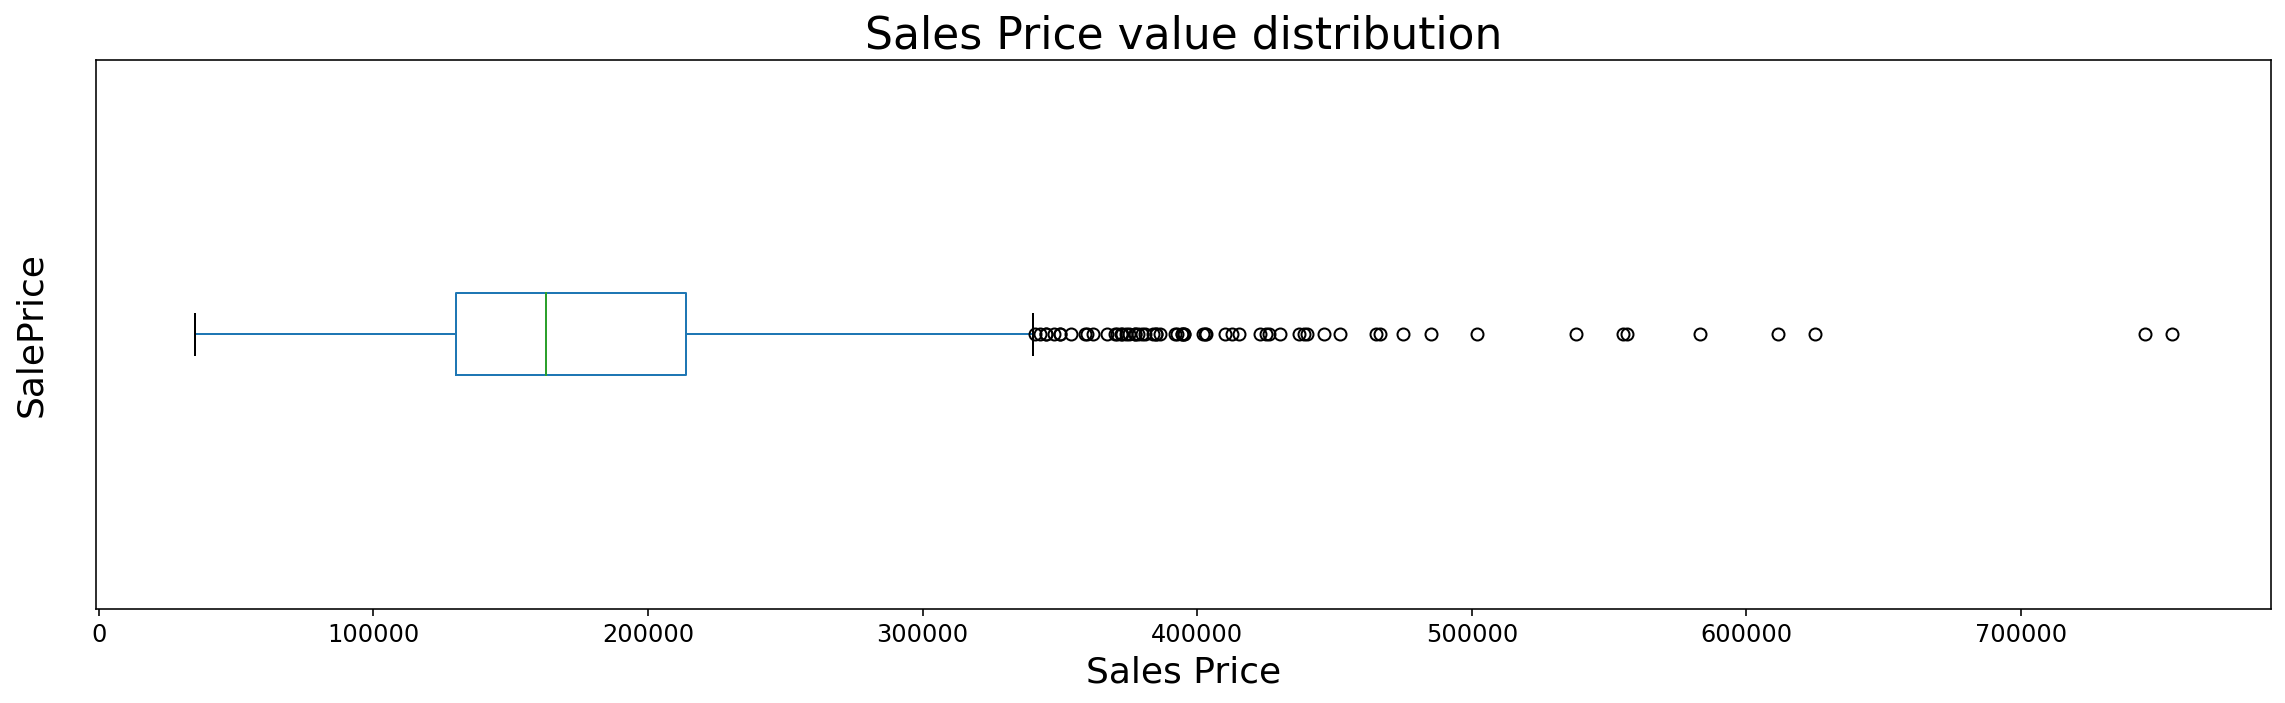

In [6]:
plt.figure(figsize=(16,6))
df.SalePrice.plot(kind = 'hist', bins = 100, rwidth = 0.9) # rwidth will specify the width of a bar
plt.title("Sale Price Distribution")
plt.xlabel("Sale Price")
plt.show()

plt.figure(figsize=(16,5))
df.SalePrice.plot(kind="box", vert=False)
plt.title("Sales Price value distribution")
plt.xlabel("Sales Price")
plt.yticks([0], [''])
plt.ylabel("SalePrice\n", rotation=90)
plt.tight_layout()
plt.show()

The distribution of Sale price is quite skewed to be more accurate it is right skewed. 

Also we can observe that there are lot of outliers in the upper end of the price spectrum.

> We have to remove the outliers from our data as it bring our accuracy down - outliers do not follow regularities that can be learned by an algorithm but we will deal with it afterwards.

**Let's see how skewed the distribution is**. The measure is [**skewness**](https://en.wikipedia.org/wiki/Skewness). 

A normal distribution has a skewness of `0`. A positive value of skewness means that the tail is on the right, and vice versa with negative values. 

Pandas provides a convenient function. We add a probability plot to visualize the skewness of the sale prices.

The skewness of SalePrice is : 1.88


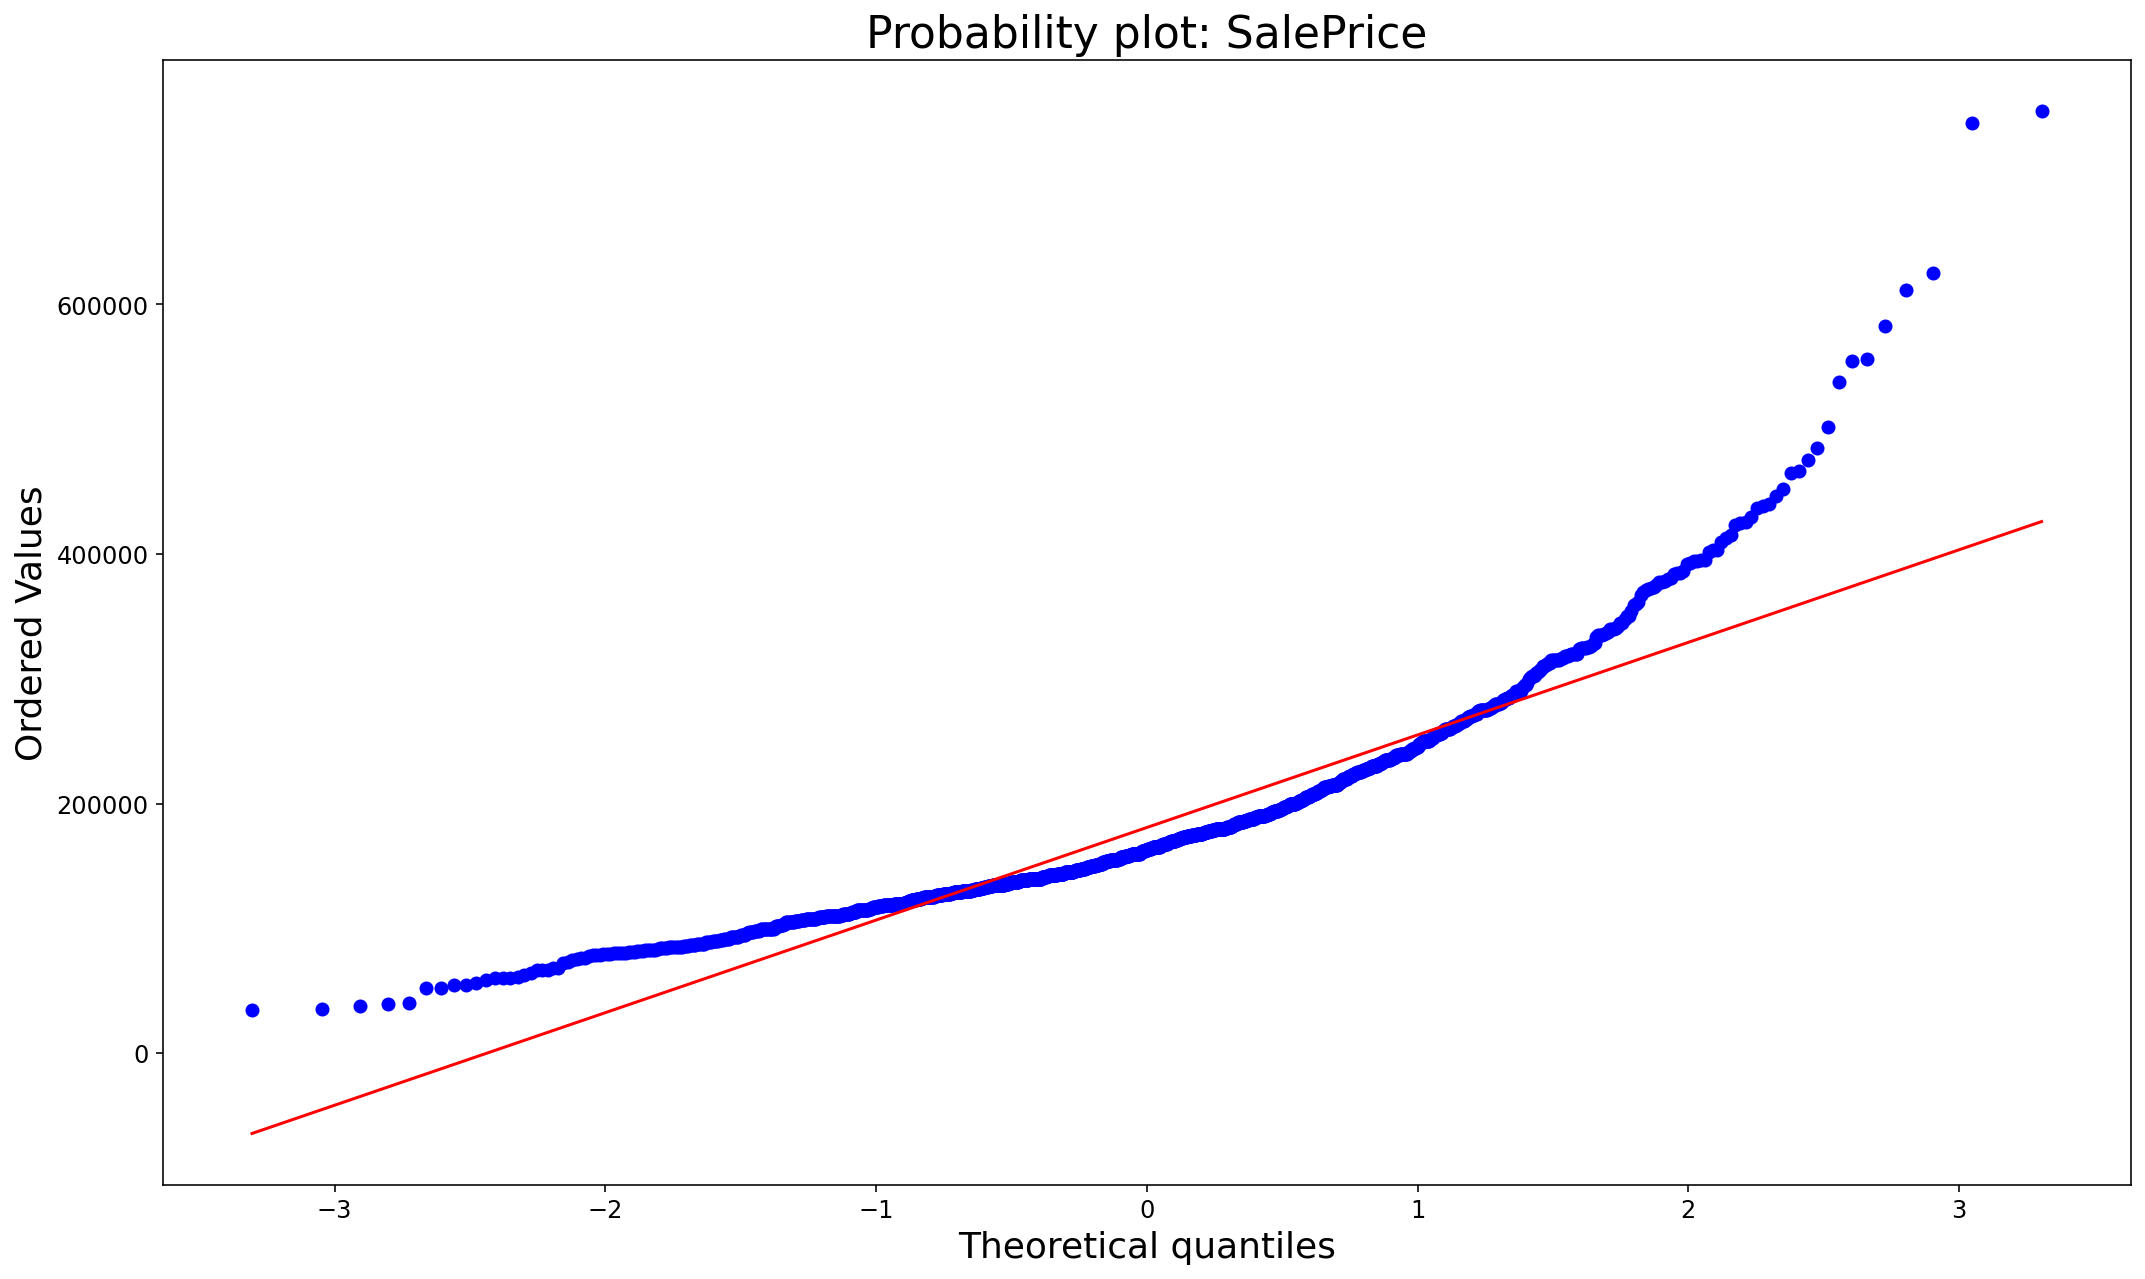

In [7]:
print(f'The skewness of SalePrice is : {df.SalePrice.skew():.2f}')
plt.figure(figsize=(15,9))
stats.probplot(df['SalePrice'], plot=plt)
plt.title("Probability plot: SalePrice")
plt.tight_layout()
plt.show()

As expected the skewness is a positive value. From the plot we can observe the deviations from the expected, theoretical values of normal distribution. These also makes sense – they tend to be higher than expected on the right end – making it a long tail.

In [8]:
display(df.select_dtypes("number").skew().sort_values(ascending=False))

MiscVal          24.476794
PoolArea         14.828374
LotArea          12.207688
3SsnPorch        10.304342
LowQualFinSF      9.011341
KitchenAbvGr      4.488397
BsmtFinSF2        4.255261
ScreenPorch       4.122214
BsmtHalfBath      4.103403
EnclosedPorch     3.089872
MasVnrArea        2.669084
OpenPorchSF       2.364342
LotFrontage       2.163569
SalePrice         1.882876
BsmtFinSF1        1.685503
WoodDeckSF        1.541376
TotalBsmtSF       1.524255
MSSubClass        1.407657
1stFlrSF          1.376757
GrLivArea         1.366560
BsmtUnfSF         0.920268
2ndFlrSF          0.813030
OverallCond       0.693067
TotRmsAbvGrd      0.676341
HalfBath          0.675897
Fireplaces        0.649565
BsmtFullBath      0.596067
OverallQual       0.216944
MoSold            0.212053
BedroomAbvGr      0.211790
GarageArea        0.179981
YrSold            0.096269
FullBath          0.036562
Id                0.000000
GarageCars       -0.342549
YearRemodAdd     -0.503562
YearBuilt        -0.613461
G

In [9]:
logSP = np.log1p(df.SalePrice.values) # used log(1+x) instead of log(x) coz log(0) is inf.
print(f'The skewness of log transformed Sale Price : {pd.DataFrame(logSP).skew().values[0]:.2f}')

plt.figure(figsize=(15, 6))
plt.hist(logSP, bins = 100, rwidth=0.9)
plt.title("Sale Price Log Transformation")
plt.xlabel("Sale Price - Log transformed")
plt.tight_layout()
plt.show()

The skewness of log transformed Sale Price : 0.12


Now the distribution looks more like a normal distribution. We will keep this in mind when we actually prepare our data.

Let's get the stats about SalePrice

In [10]:
print(df.SalePrice.describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


Insights:

* The range is from 34k USD to 755k USD.  
* We can see that the mean(180921USD) is greater than median(163000USD) as mean is sensitive to outliers.
* The standard deviation is around 79k. So on average, prices in the dataset tend to vary by this amount around the mean of ~180k.

How are **numerical features correlated to `SalePrice`**? 

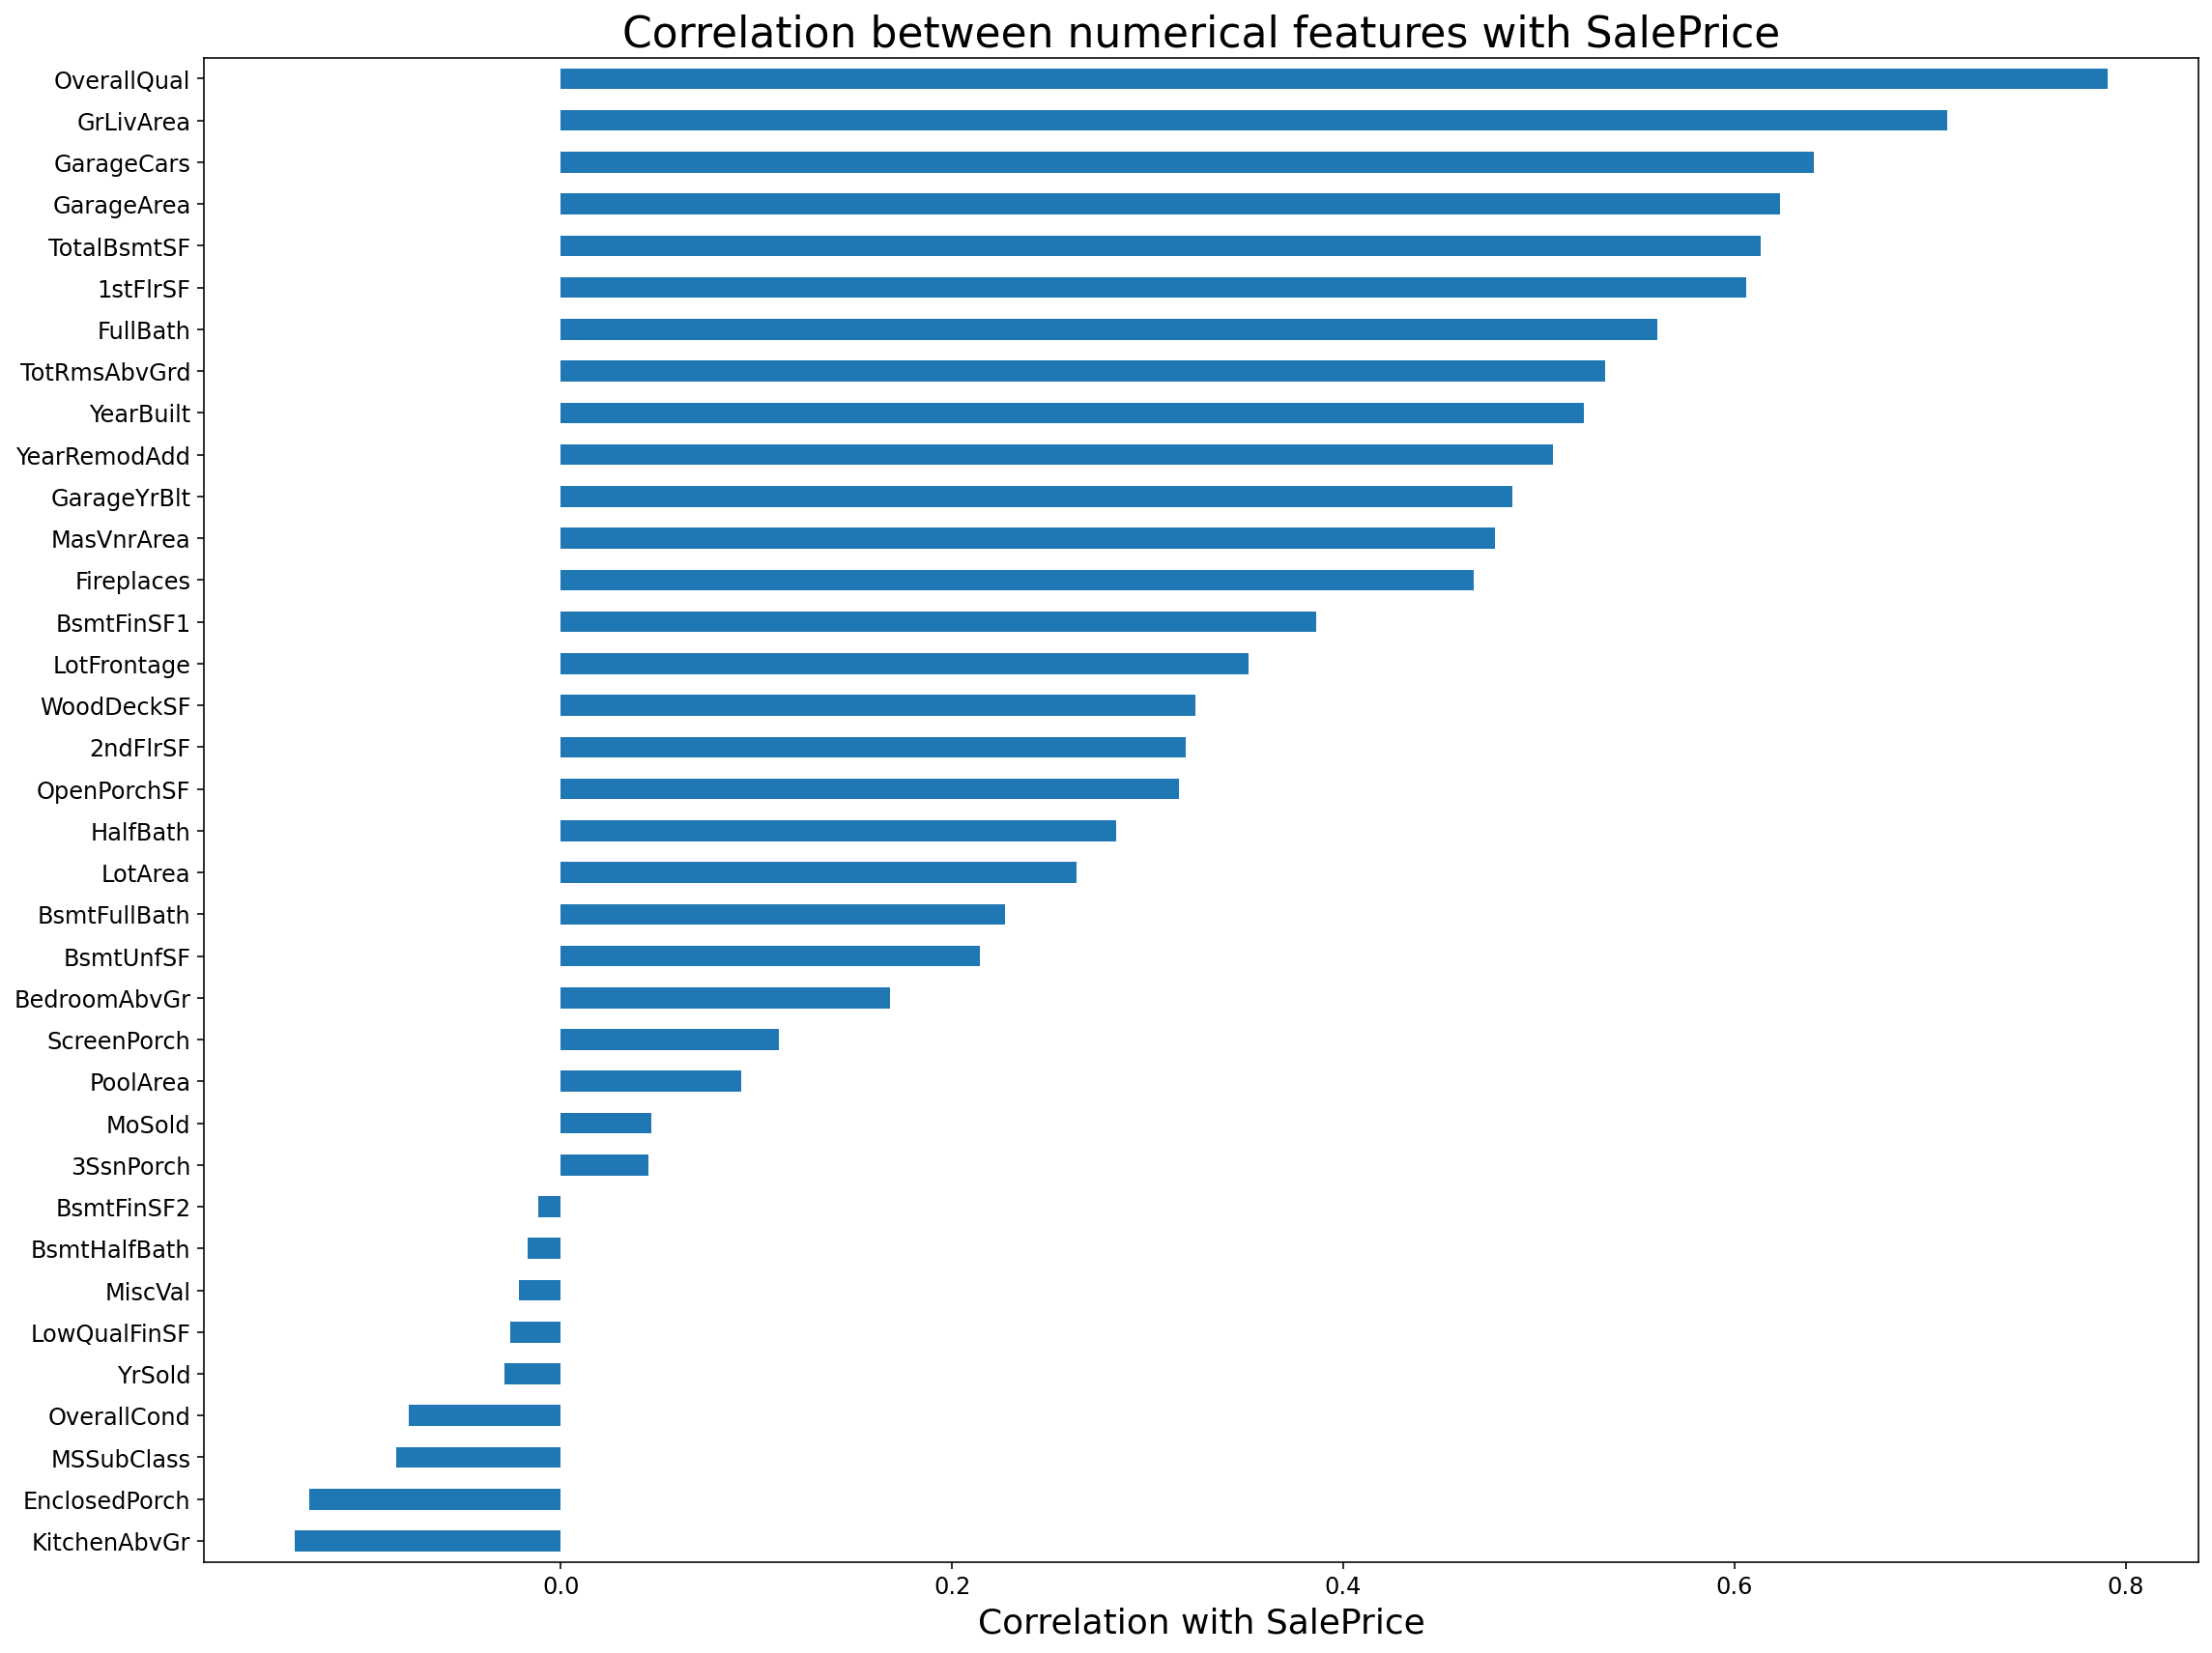

In [11]:
corr = df.drop("Id", axis = 1).select_dtypes(include="number").corr()

plt.figure(figsize=(16, 12))
corr['SalePrice'].sort_values(ascending = True)[:-1].plot(kind="barh")
plt.title("Correlation between numerical features with SalePrice")
plt.xlabel("Correlation with SalePrice")
plt.tight_layout()
plt.show()

Not suprisingly most of the features has positive correlation with Sale price.

In [12]:
plt.figure(figsize=(15, 15))
sns.heatmap(corr, cmap="RdBu")
plt.title("Correlation matrix for numerical features")
plt.tight_layout()
plt.show()

Again: Many correlations makes sense on a first glance. E.g. `OverallQual` sticks out highly correlated regarding `SalePrice`. Which is interesting since it is "the overall material and finish of the house" rather than the “overall condition of the house" `OverallCond`.  

To examine the relevant correlations more thoroughly we plot `SalePrice` vs `OverallQual`. The latter is a categorical ranging from «Very poor» = 1 to «Very Excellent» = 10. **Rather than a scatter plot we use box plots for categoricals.**

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


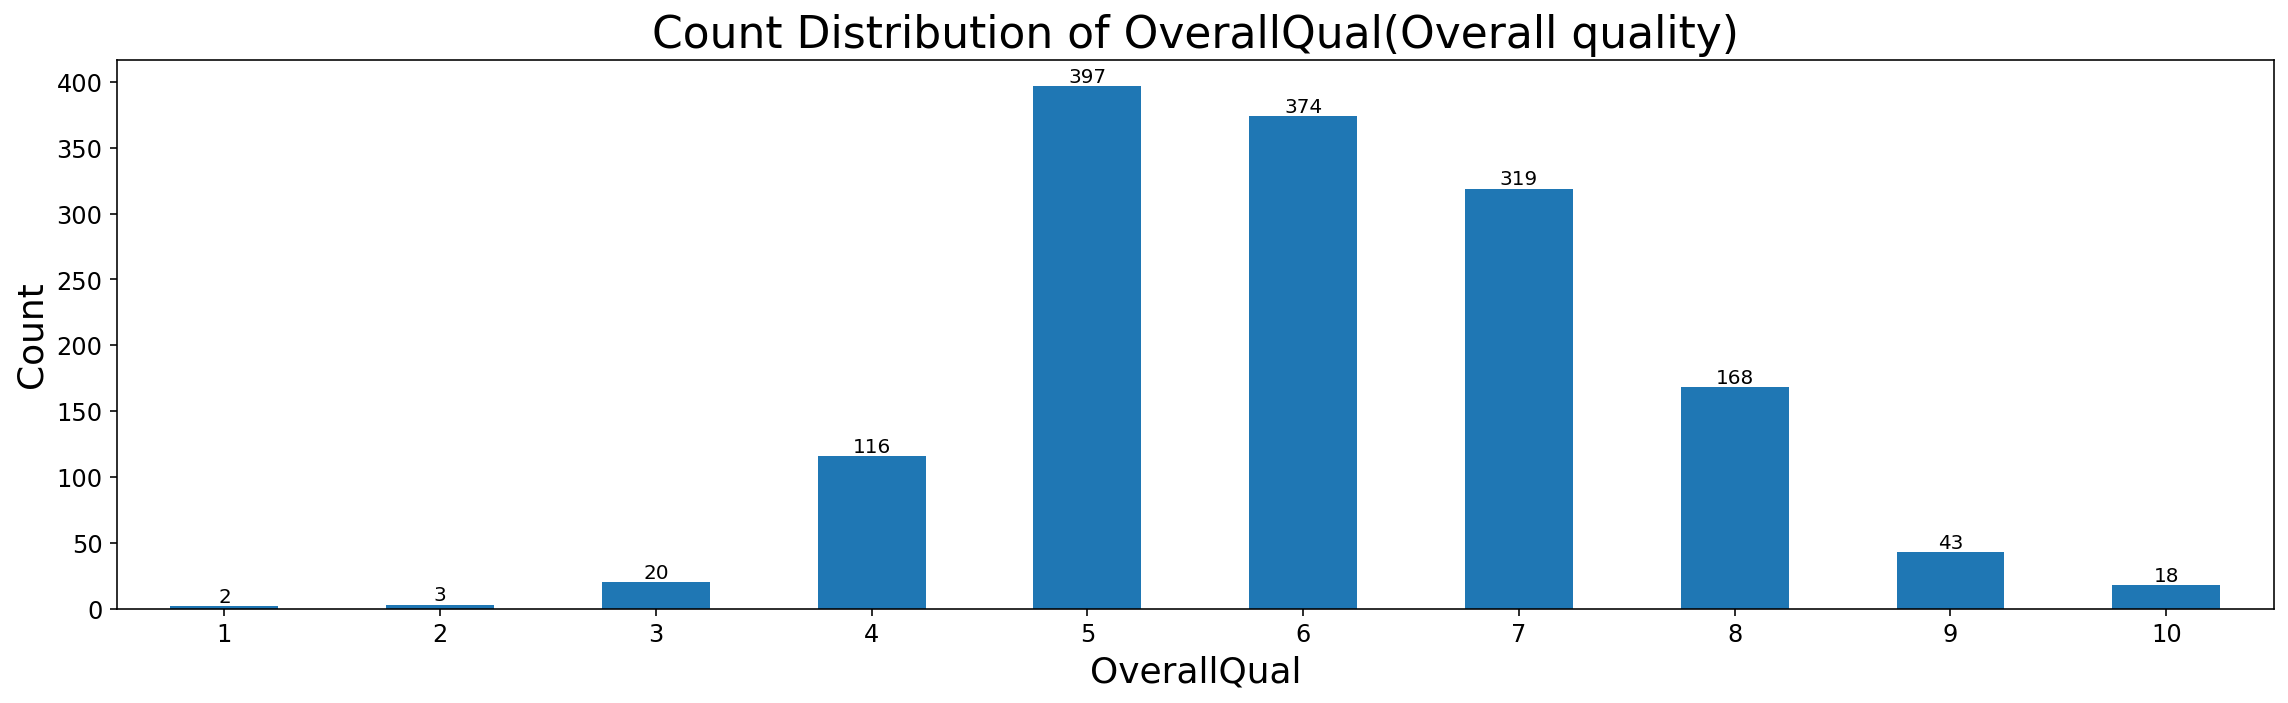

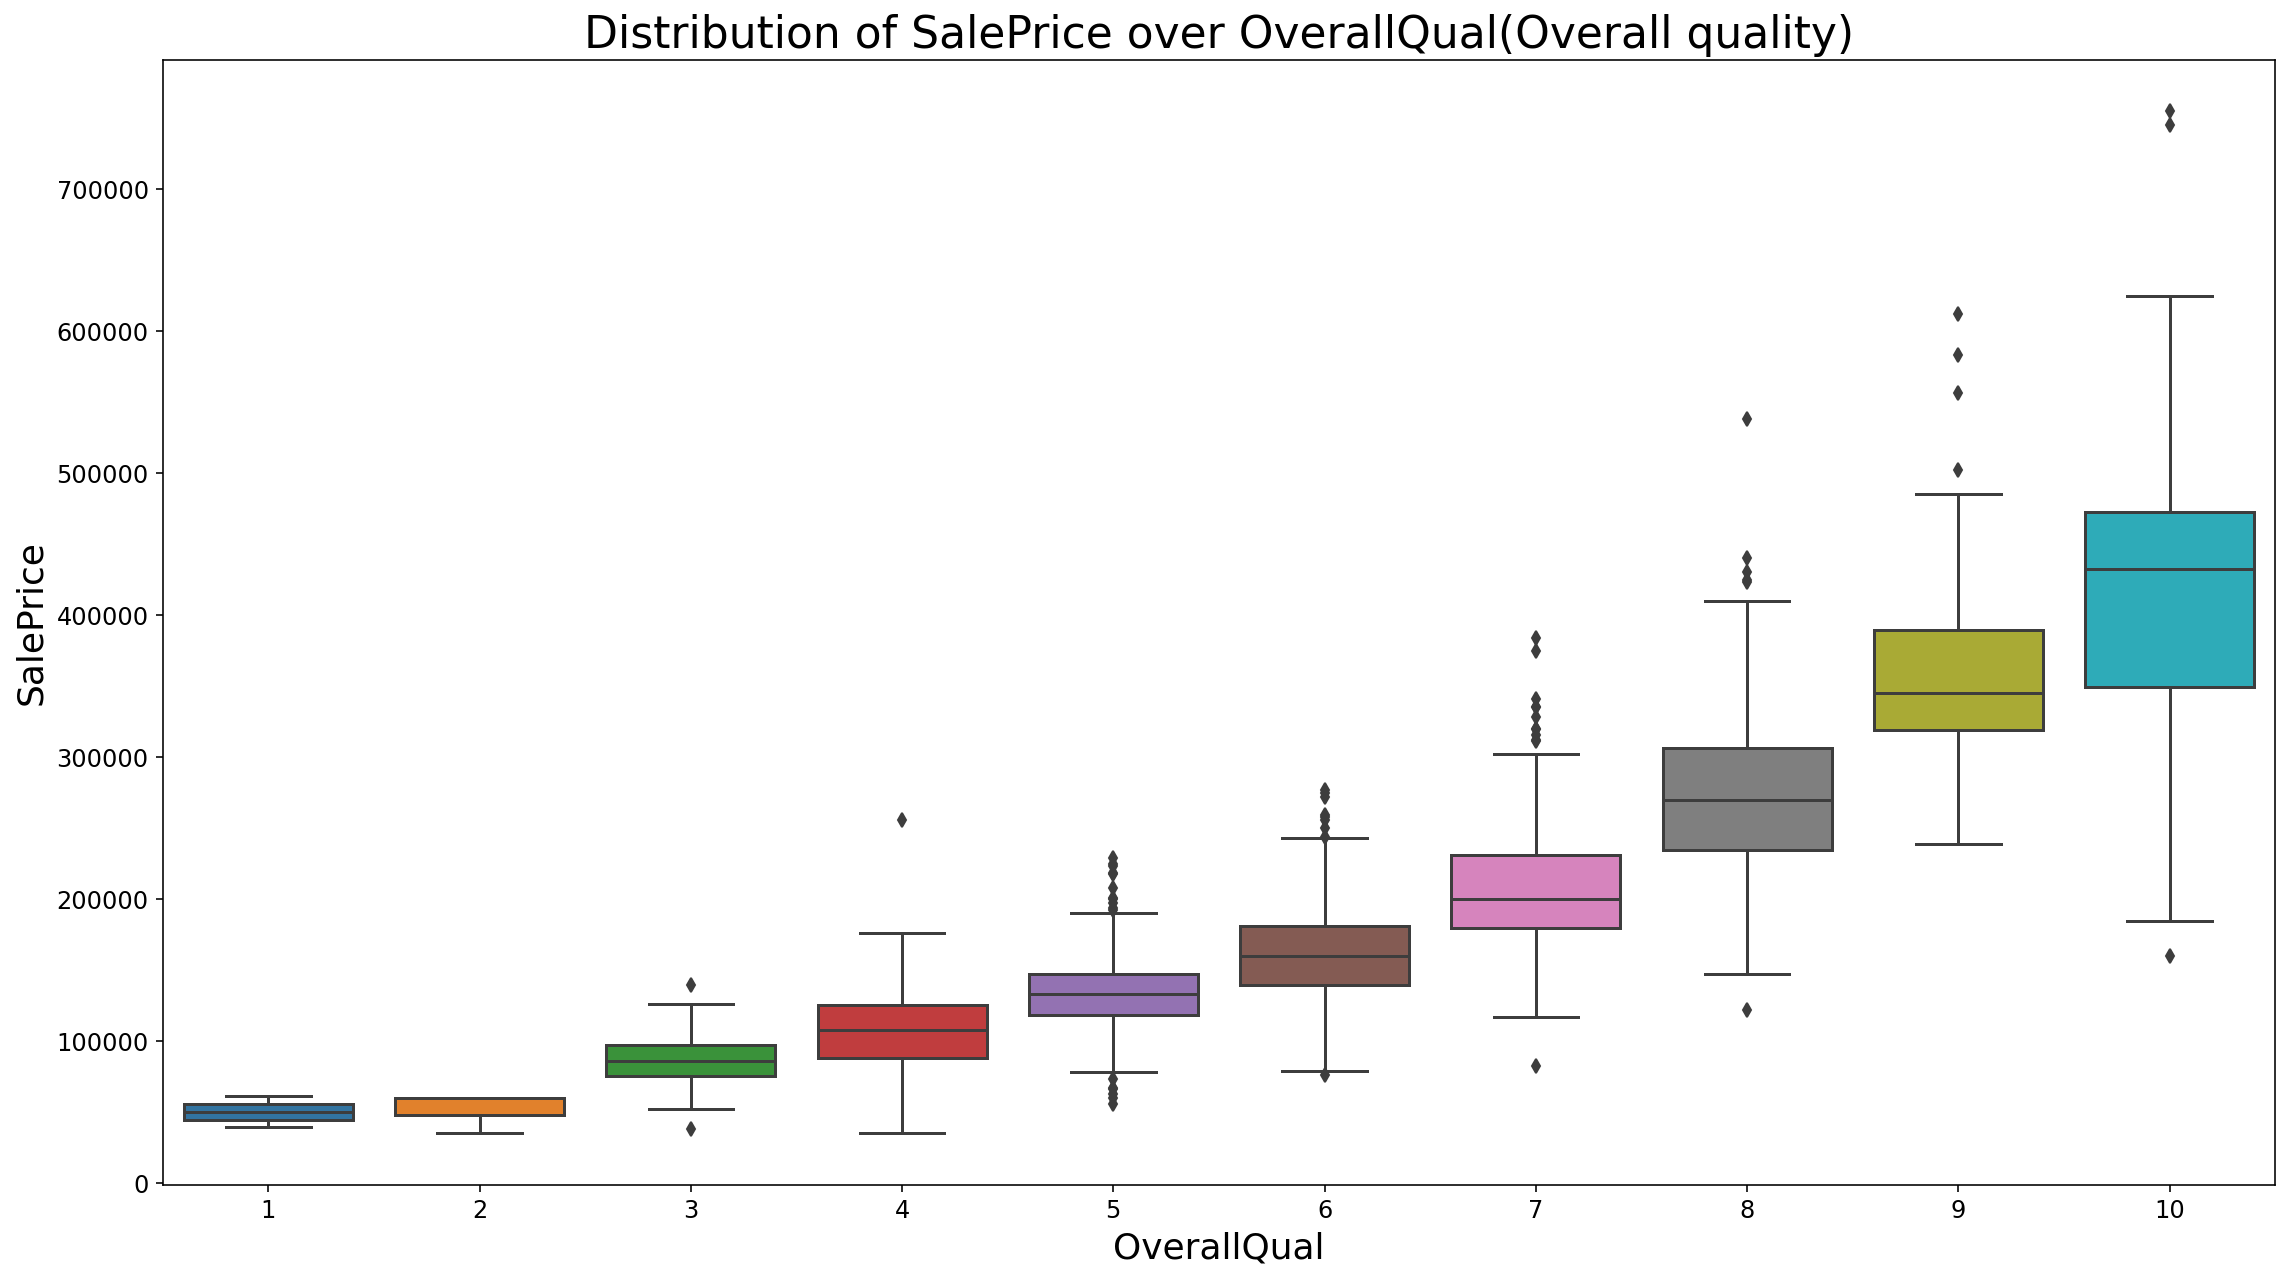

In [13]:
plt.figure(figsize=(16,5))
df.groupby('OverallQual')['SalePrice'].count().plot(kind = "bar")
for index, value in enumerate(df.groupby('OverallQual')['SalePrice'].count().to_list()):
    plt.text(index, value+3, str(value), horizontalalignment='center')
plt.title("Count Distribution of OverallQual(Overall quality)")
plt.xticks(rotation=360) # Due to some reason the labels of x axis were rotated
                         # to 90deg, to fix the bug I used this 
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,9))
ax = sns.boxplot(x="OverallQual", y="SalePrice", data=df)
plt.title("Distribution of SalePrice over OverallQual(Overall quality)")
plt.tight_layout()
plt.show()

We can observe that most of the houses comes under the category 5 and 6, there are not many houses that lies at either end of the spectrum. Also Not suprisingly, Sale price increases with increase in overall quality of the house.

Here also we can see many outliers in most of the catogories. The spread of the outliers are more at the right end of the spectrum.

Let's plot OverallCond in comparison

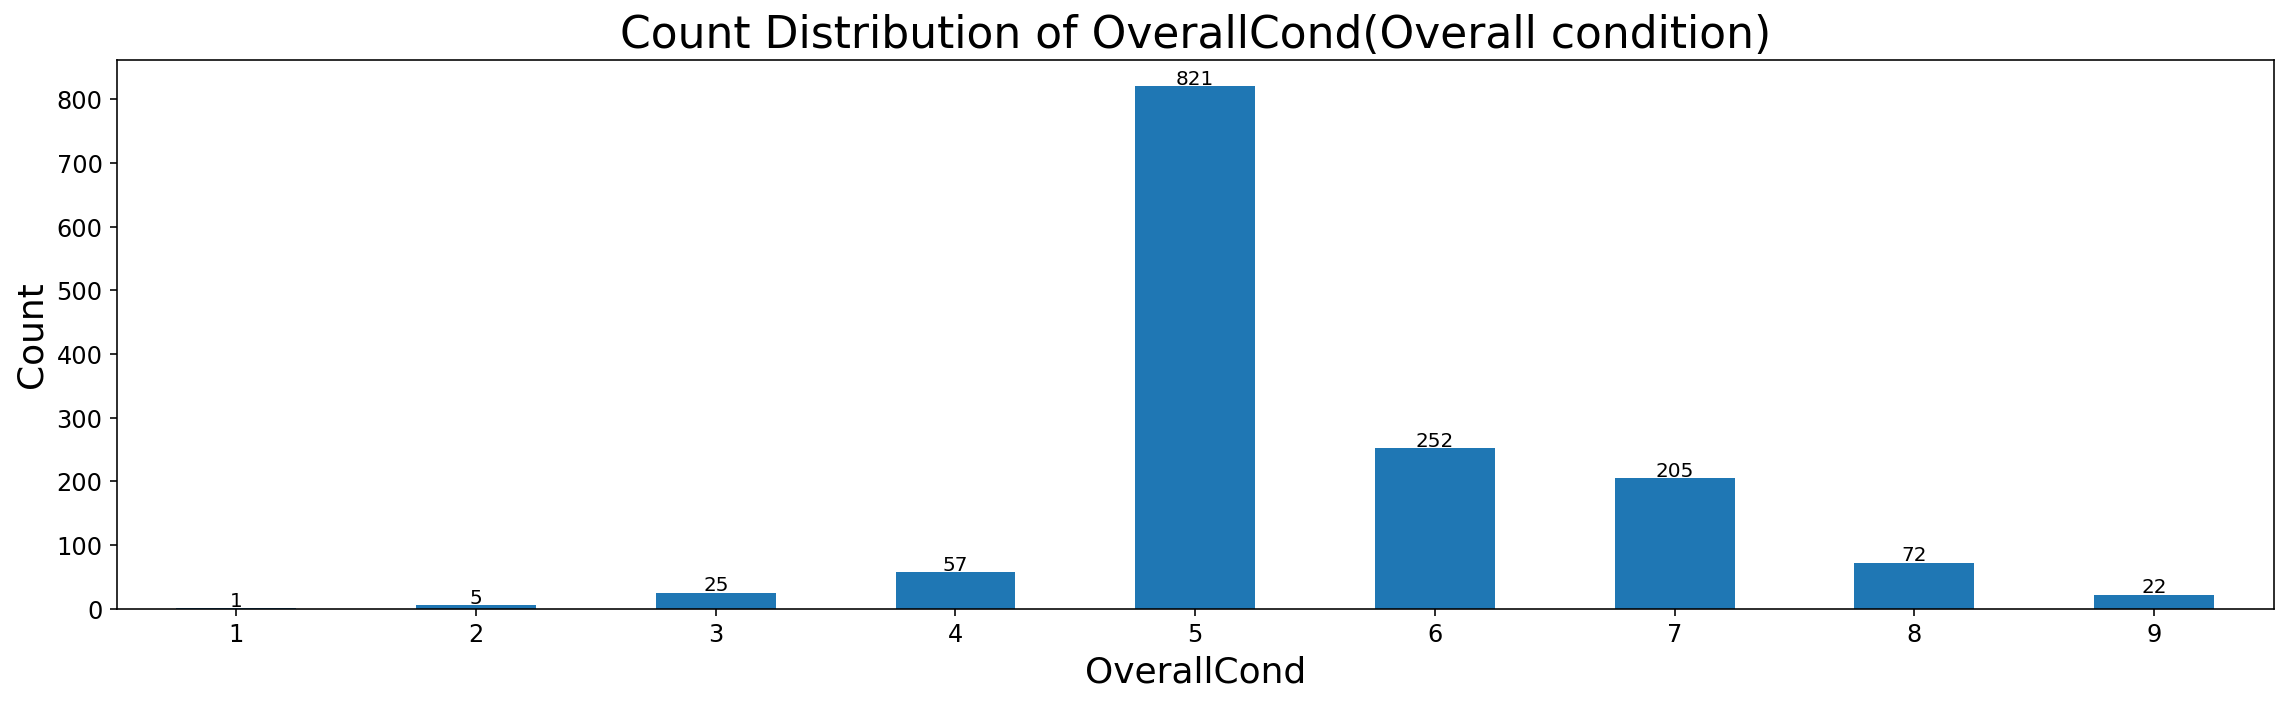

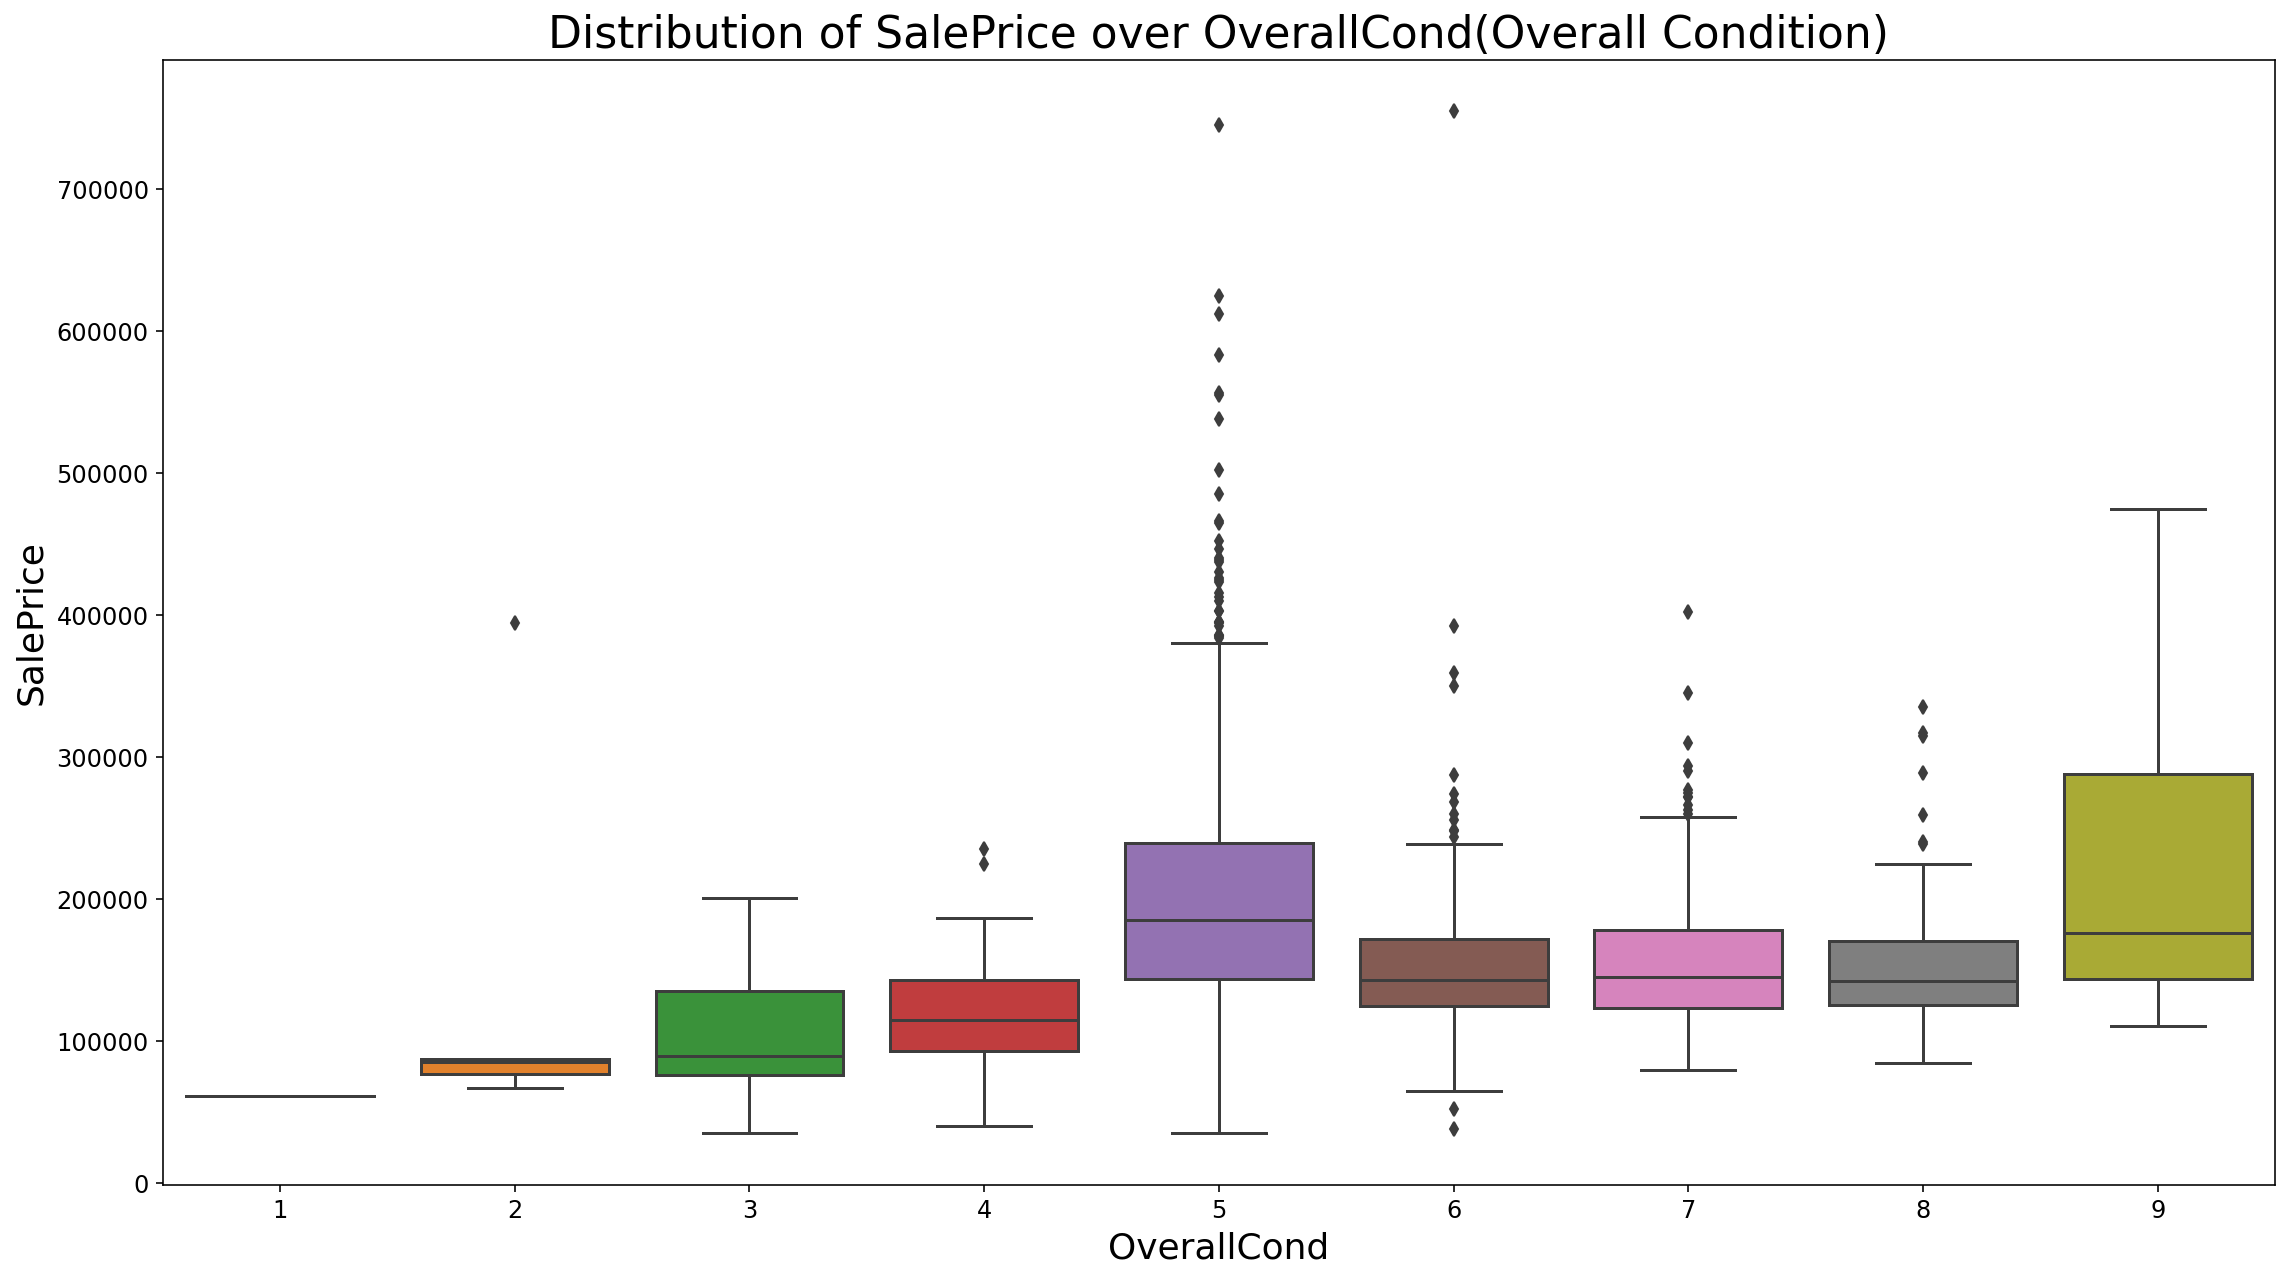

In [14]:
plt.figure(figsize=(16, 5))
df.groupby('OverallCond')['SalePrice'].count().plot(kind = "bar")
for index, value in enumerate(df.groupby('OverallCond')['SalePrice'].count().to_list()):
    plt.text(index, value+3, str(value), horizontalalignment='center')
plt.title("Count Distribution of OverallCond(Overall condition)")
plt.xticks(rotation=360) # Due to some reason the labels of x axis were rotated
                         # to 90deg, to fix the bug I used this 
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 9))
ax = sns.boxplot(x="OverallCond", y="SalePrice", data=df)
plt.title("Distribution of SalePrice over OverallCond(Overall Condition)")
plt.tight_layout()
plt.show()

We see that:
- Only very few properties are rated below average (5). 
- Average (5) is the category value of overall condition that has by far the most counts.
- **The mean sale price for «Average» is higher than for «Above Average» and higher.**

One possible explanation could be that as long as the house is in average condition it can be fixed to a higher condition without that much additional cost. If the base materials and finish are not good, than a prospective owner would have much more difficulties upping the property. 

By the way: **If we want to visually _combine count and distribution_ we can use a [swarmplot](https://seaborn.pydata.org/generated/seaborn.swarmplot.html#seaborn.swarmplot).** 

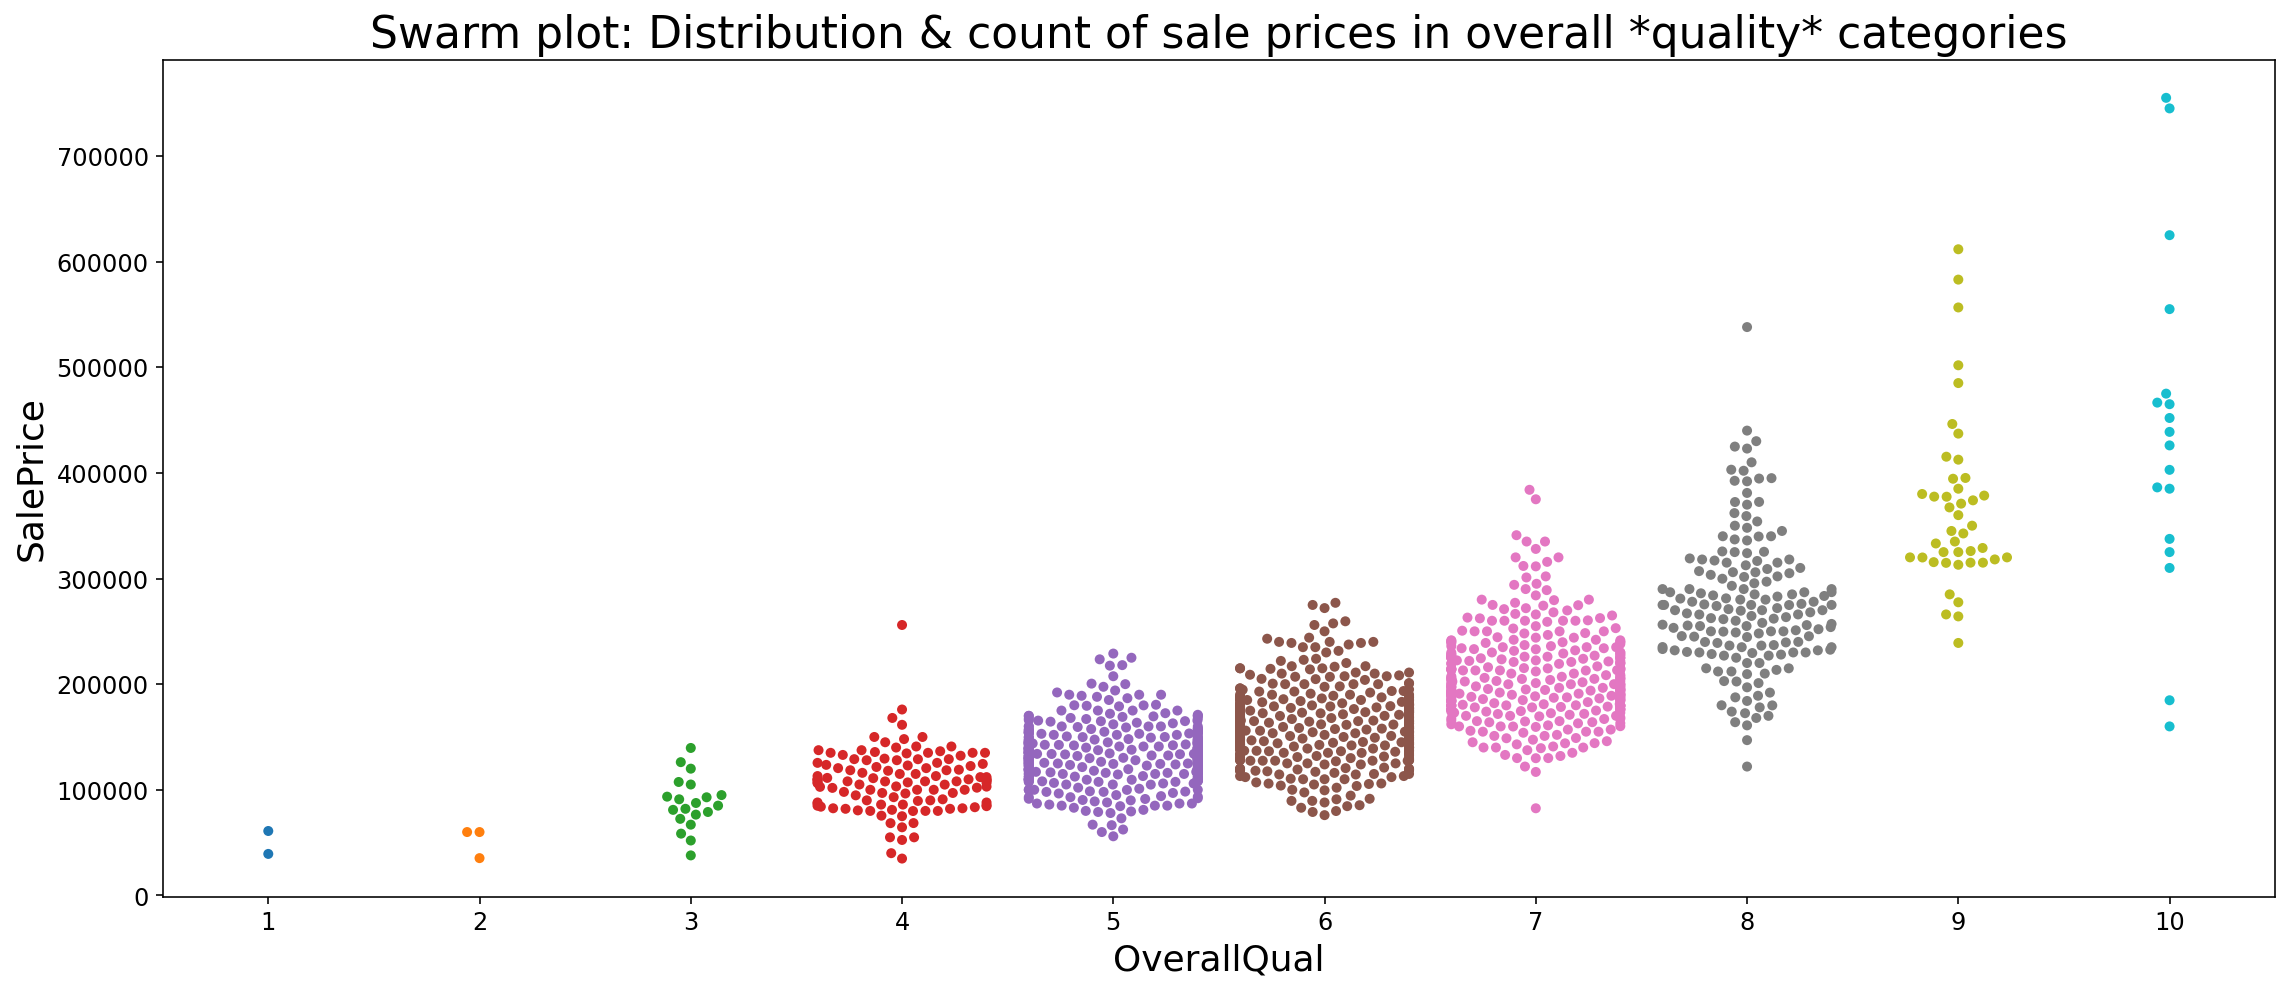

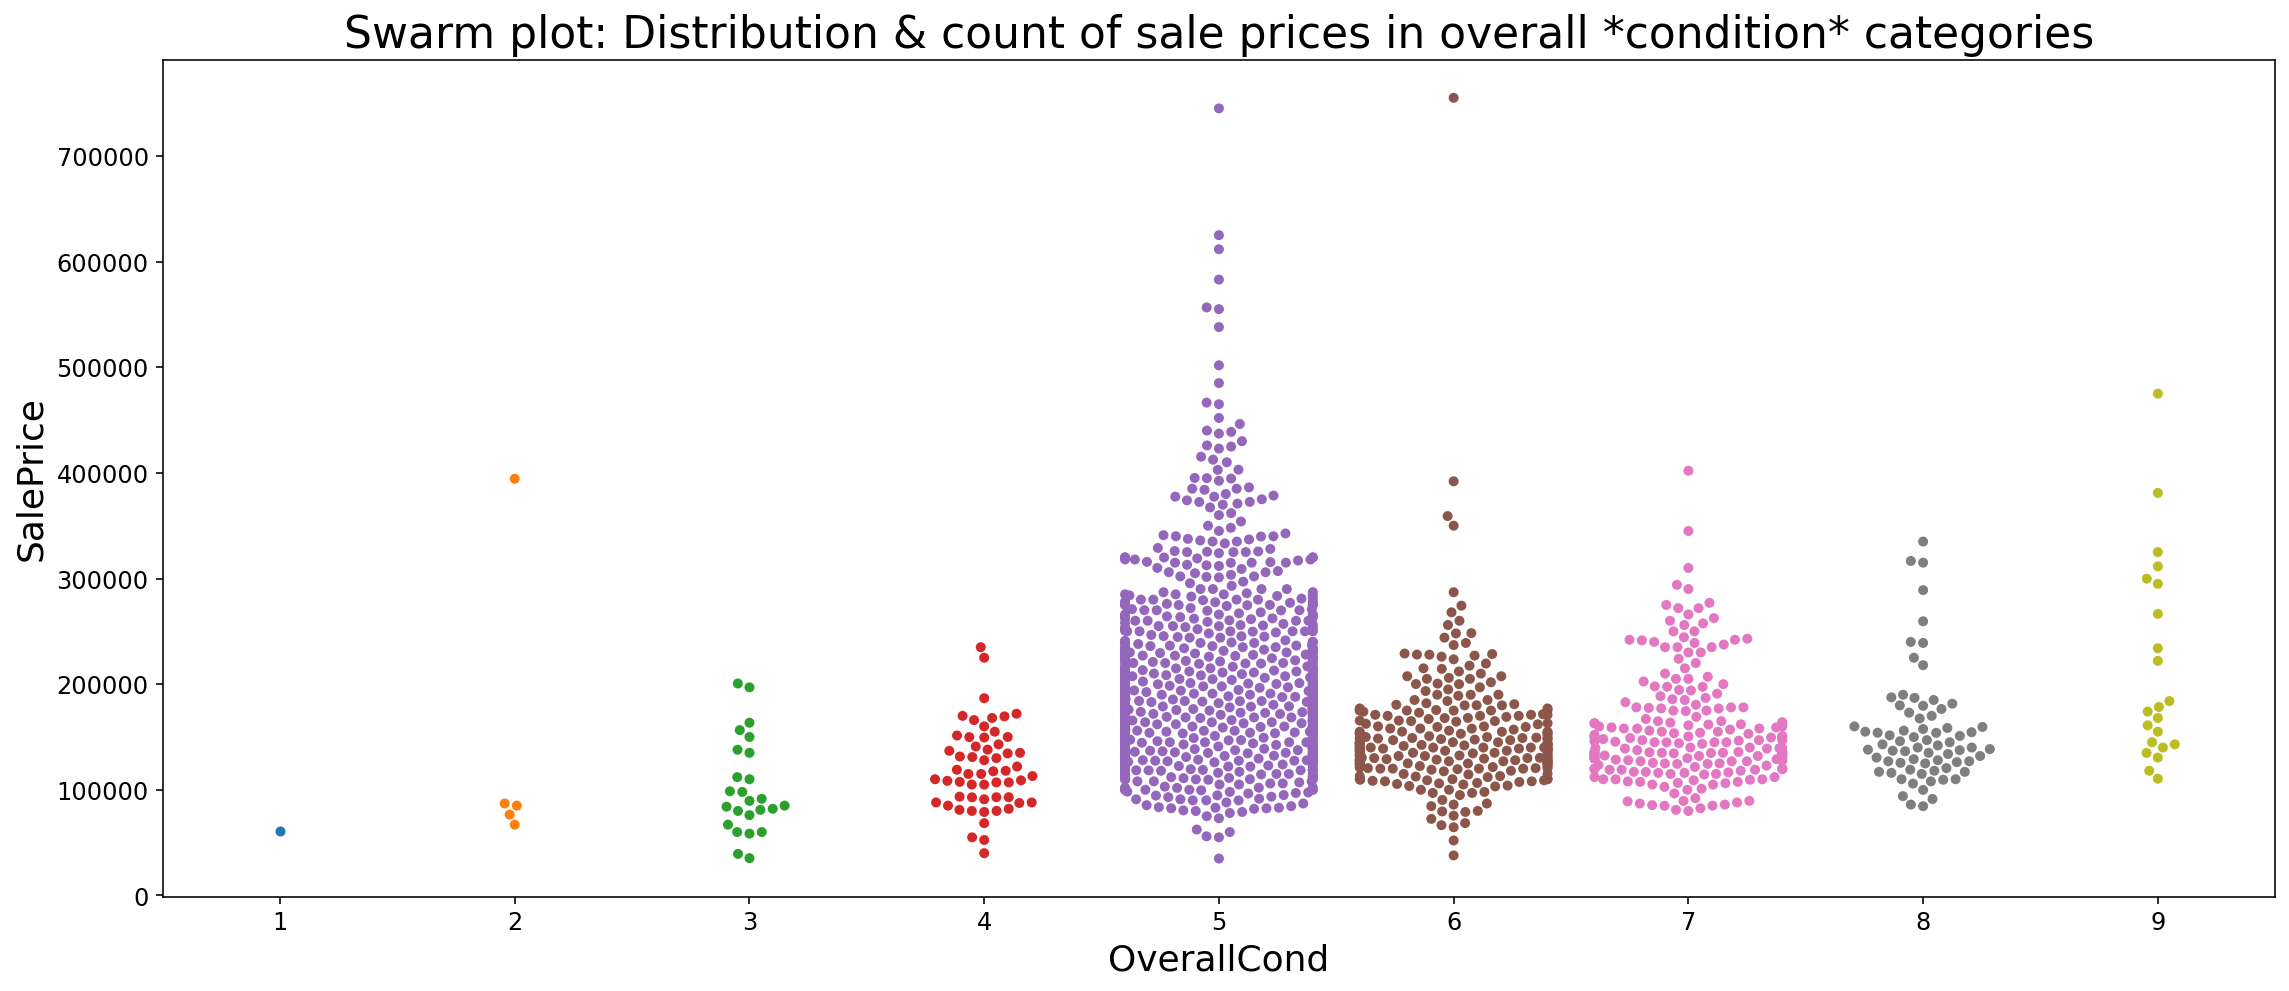

In [15]:
plt.figure(figsize=(16,7));
sns.swarmplot(x="OverallQual", y="SalePrice", data=df)
plt.title("Swarm plot: Distribution & count of sale prices in overall *quality* categories")
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,7));
sns.swarmplot(x="OverallCond", y="SalePrice", data=df)
plt.title("Swarm plot: Distribution & count of sale prices in overall *condition* categories")
plt.tight_layout()
plt.show()

We are now **examining the relation of our target variable to other interesting correlated features** and start with several numerical **features of size.**

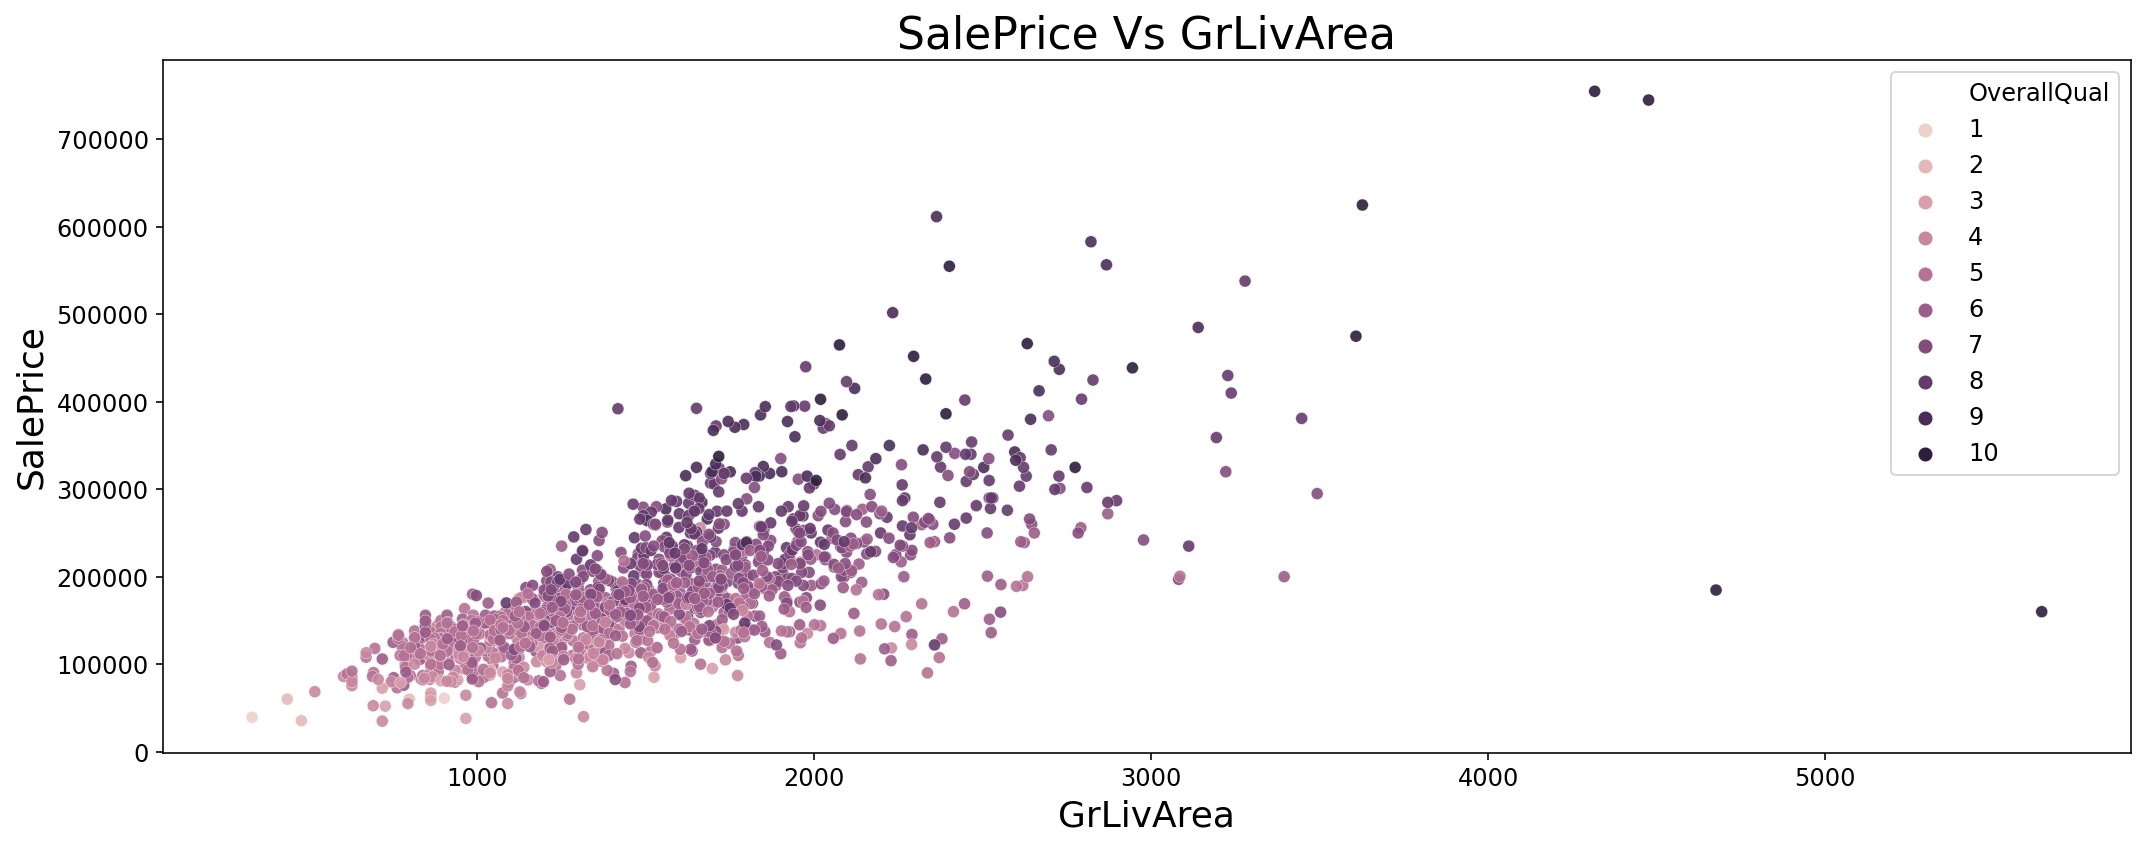

In [16]:
plt.figure(figsize=(15,6))
sns.scatterplot(x='GrLivArea', y='SalePrice', hue='OverallQual', data = df, alpha=0.9, legend="full", linewidth=0.2)
plt.title("SalePrice Vs GrLivArea")
plt.tight_layout()
plt.show()

The correlation is clearly noticable. 

Makes sense: low overall quality data points plot with light hue in lower ranges of living area and sale price. 


What if we **bin the continuous feature `GrLivArea` to a categorical** and plot again counts and distribution?

In [17]:
df_cut = pd.DataFrame(pd.cut(np.log1p(df.GrLivArea), bins=10, labels=np.arange(0, 10)))
df_cut = pd.concat([df_cut, df.SalePrice], axis=1)

plt.figure(figsize=(15, 5))
df_cut.groupby('GrLivArea')['SalePrice'].count().plot(kind='bar')
plt.title("Count distribution of GrLivArea(Ground Living Area square feet)")
plt.ylabel("Count")
plt.xticks(rotation=360)
for index, values in enumerate(df_cut.groupby('GrLivArea')['SalePrice'].count().to_list()):
    plt.text(index, values+3, str(values), horizontalalignment='center')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,9))
sns.boxplot(x='GrLivArea', y='SalePrice', data=df_cut)
plt.title("Distribution of SalePrice over GrLivArea(Ground Living Area square feet)")
plt.tight_layout()
plt.show()

Main Finding: The more living area the more variance we have in distribution of Sale Price . In the top range, the variance is unusually high- very likely due to outliers.

Now checking 4 more features of size.

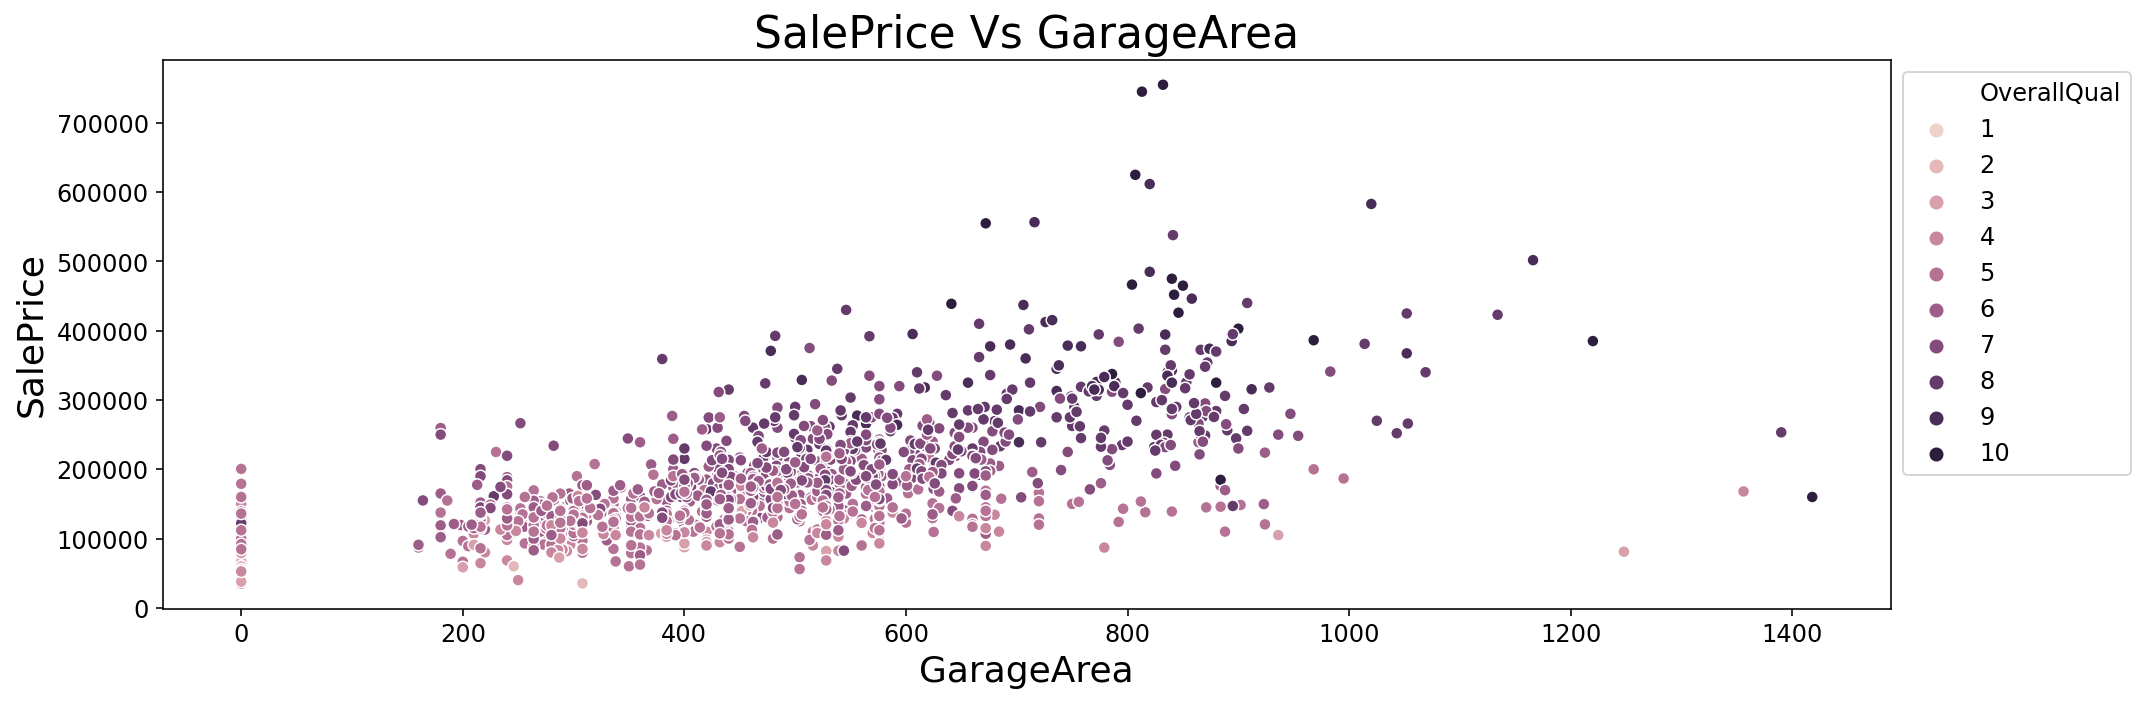

In [18]:
features = ["GarageArea", "TotalBsmtSF", "1stFlrSF", "LotArea"]

for feature in features:
    plt.figure(figsize=(15, 5))
    sns.scatterplot(x=feature, y='SalePrice', hue='OverallQual', data=df, legend="full")
    plt.title(f'SalePrice Vs {feature}')
    plt.legend(bbox_to_anchor=(1,1), loc=2) # determines the location of legend
    plt.tight_layout()
    plt.show()



We clearly observe the positive correlation of the features and again various outliers.

Let's look at the **time related features like building year, year and month of sale.**

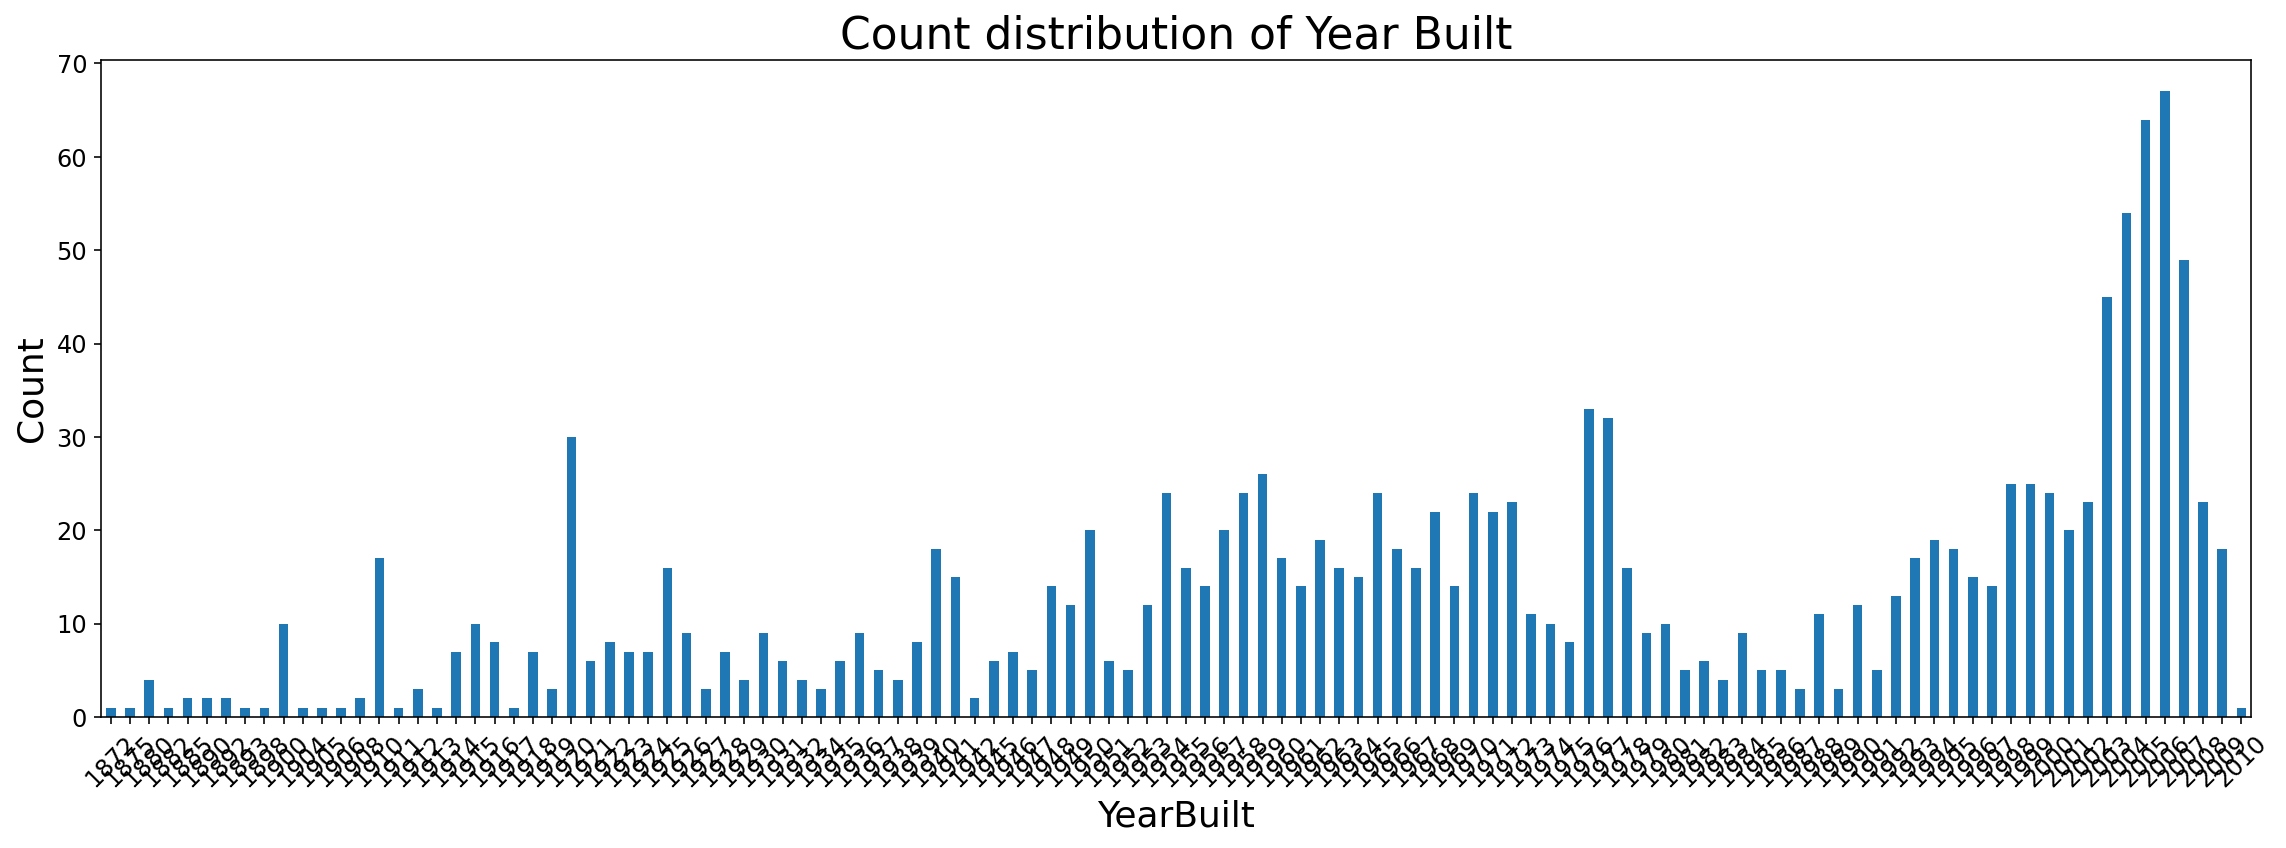

In [19]:
plt.figure(figsize=(16,6))
df.groupby('YearBuilt')['SalePrice'].count().plot(kind='bar')
plt.title('Count distribution of Year Built')
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 8))
sns.boxplot(x='YearBuilt', y='SalePrice', data=df)
plt.title("Distribution of SalePrice over Year Built")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Interesting but **hard to decipher**. Let's **bin the data to decades**.

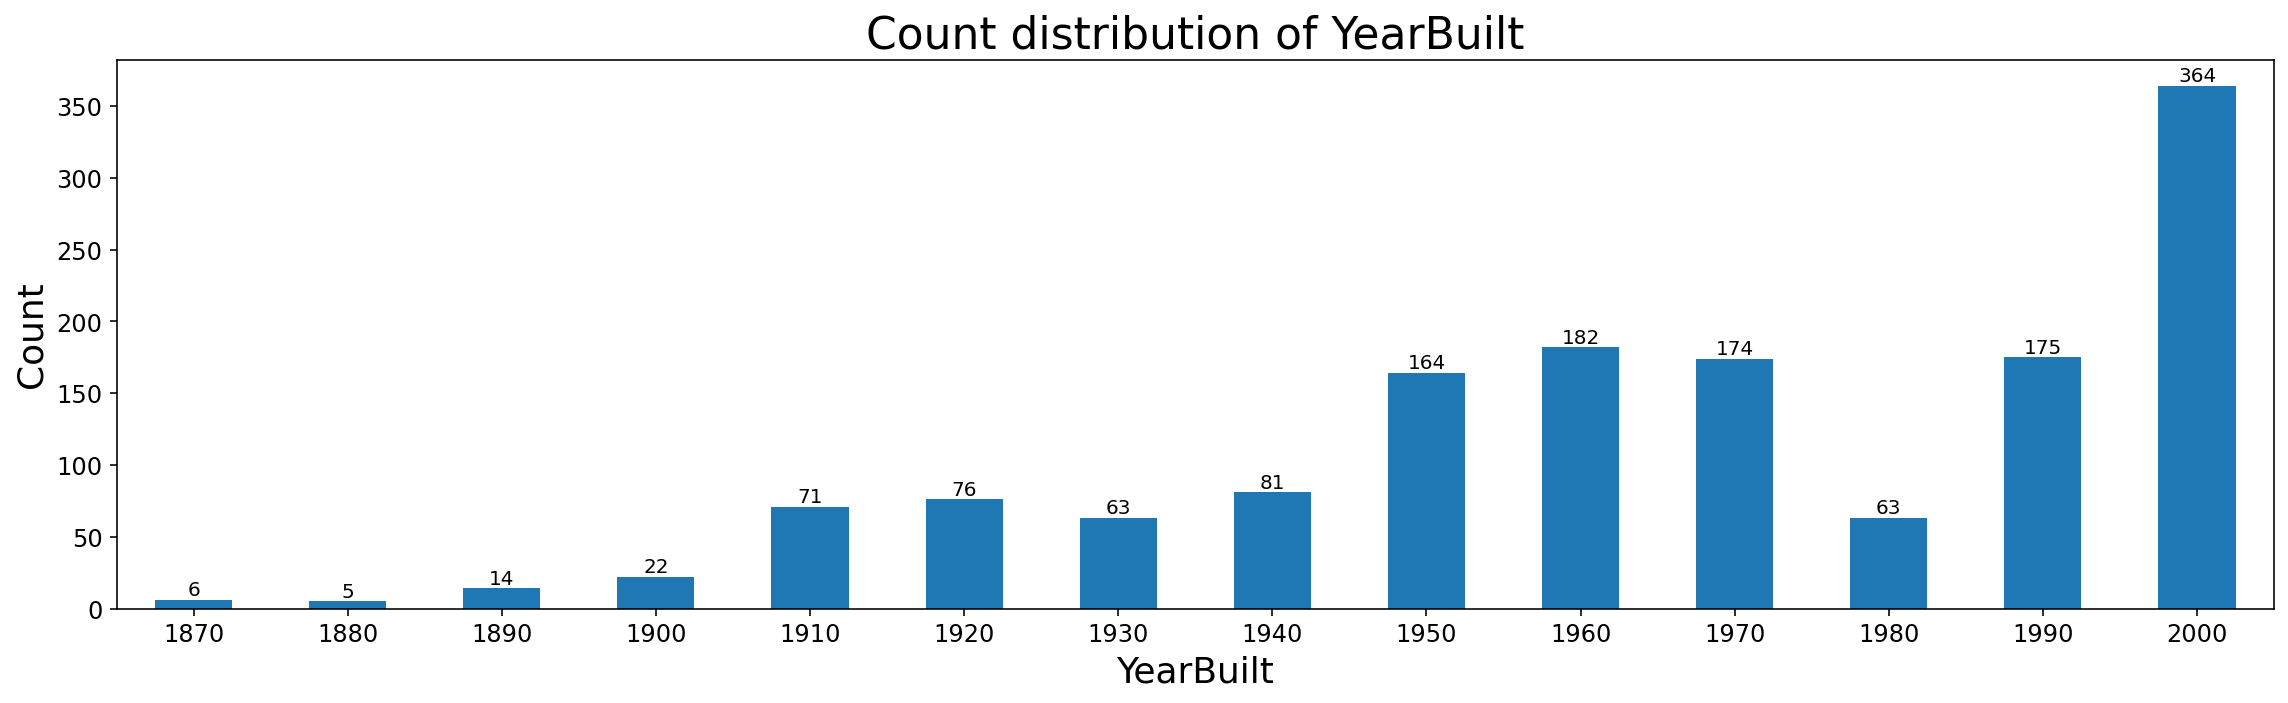

In [20]:
decades = np.arange(1870, 2015, 10)
df_cut = pd.cut(df.YearBuilt, bins=decades, labels=decades[:-1])
df_comb = pd.concat([df_cut, df.SalePrice], axis=1)

plt.figure(figsize=(16, 5))
df_comb.groupby('YearBuilt')['SalePrice'].count().plot(kind="bar")
plt.title("Count distribution of YearBuilt")
plt.ylabel("Count")
plt.xticks(rotation=360)
for index, value in enumerate(df_comb.groupby('YearBuilt')['SalePrice'].count().to_list()):
    plt.text(index, value+3, str(value), horizontalalignment='center')
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,9))
sns.boxplot(x='YearBuilt', y='SalePrice', data= df_comb)
plt.title("Distribution of SalePrice over YearBuilt")
plt.tight_layout()
plt.show()



We observe that:

- Most of the house were built 1950 and later.
- A good third of all properties was built 1990 and later.
- Newer houses tend to yield a little higher mean of sale price.
- House from 1870 to 1880 have an unusual variance in sale price – again very likely to outliers

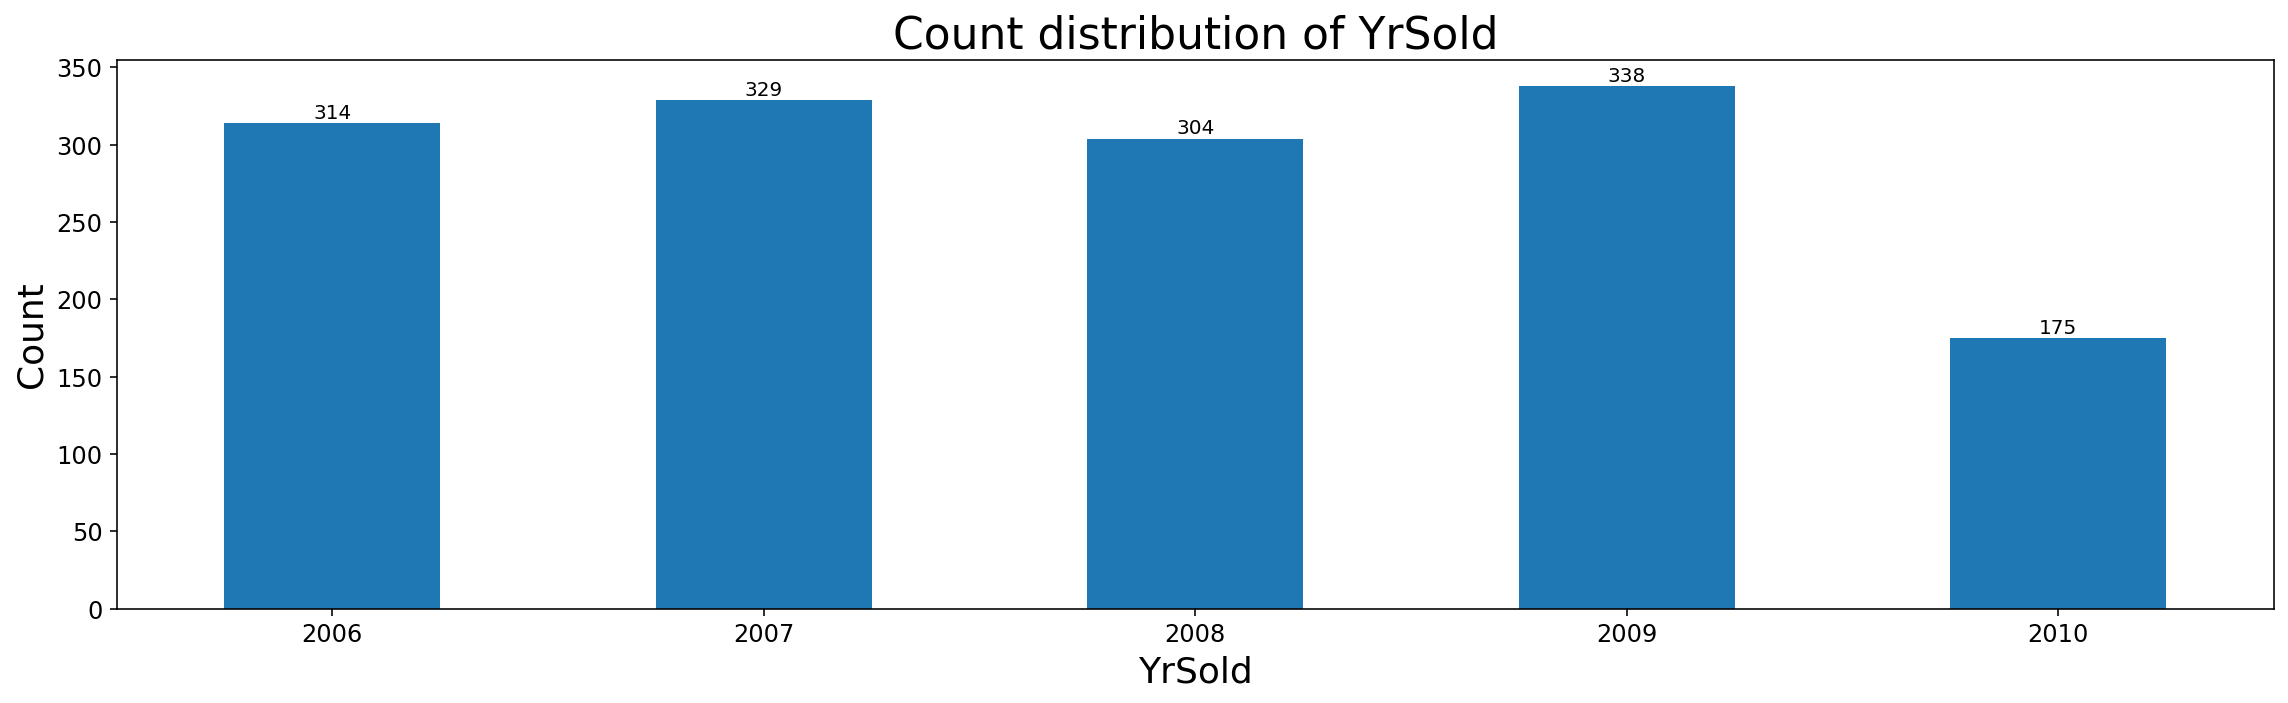

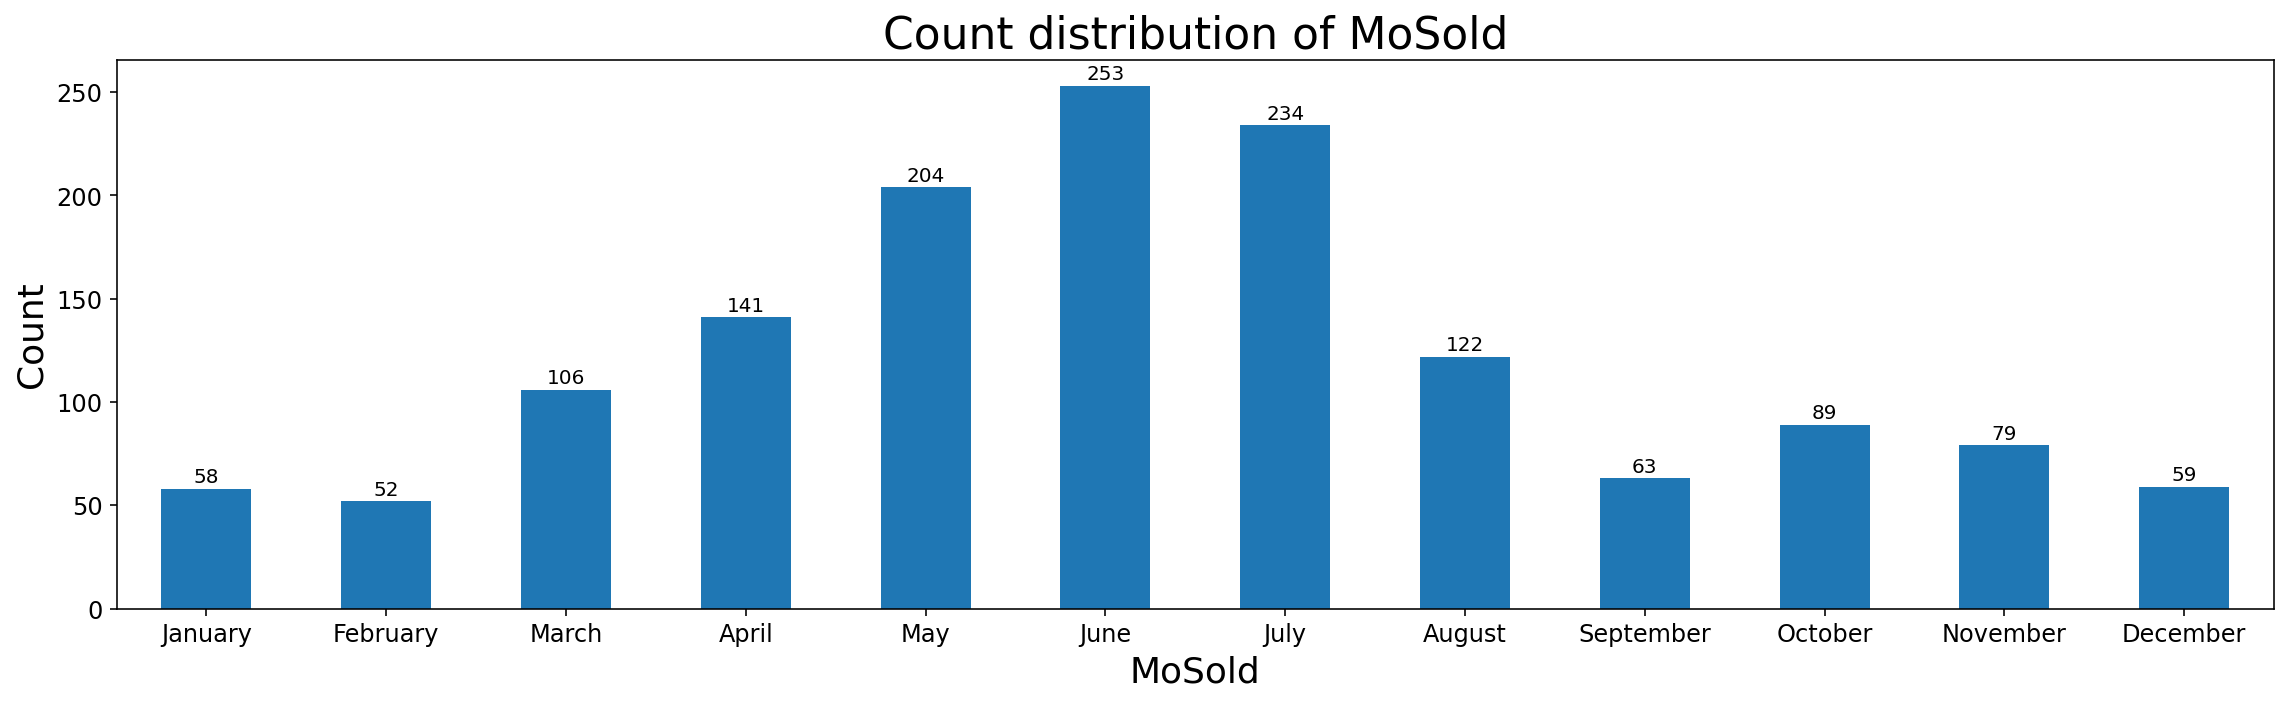

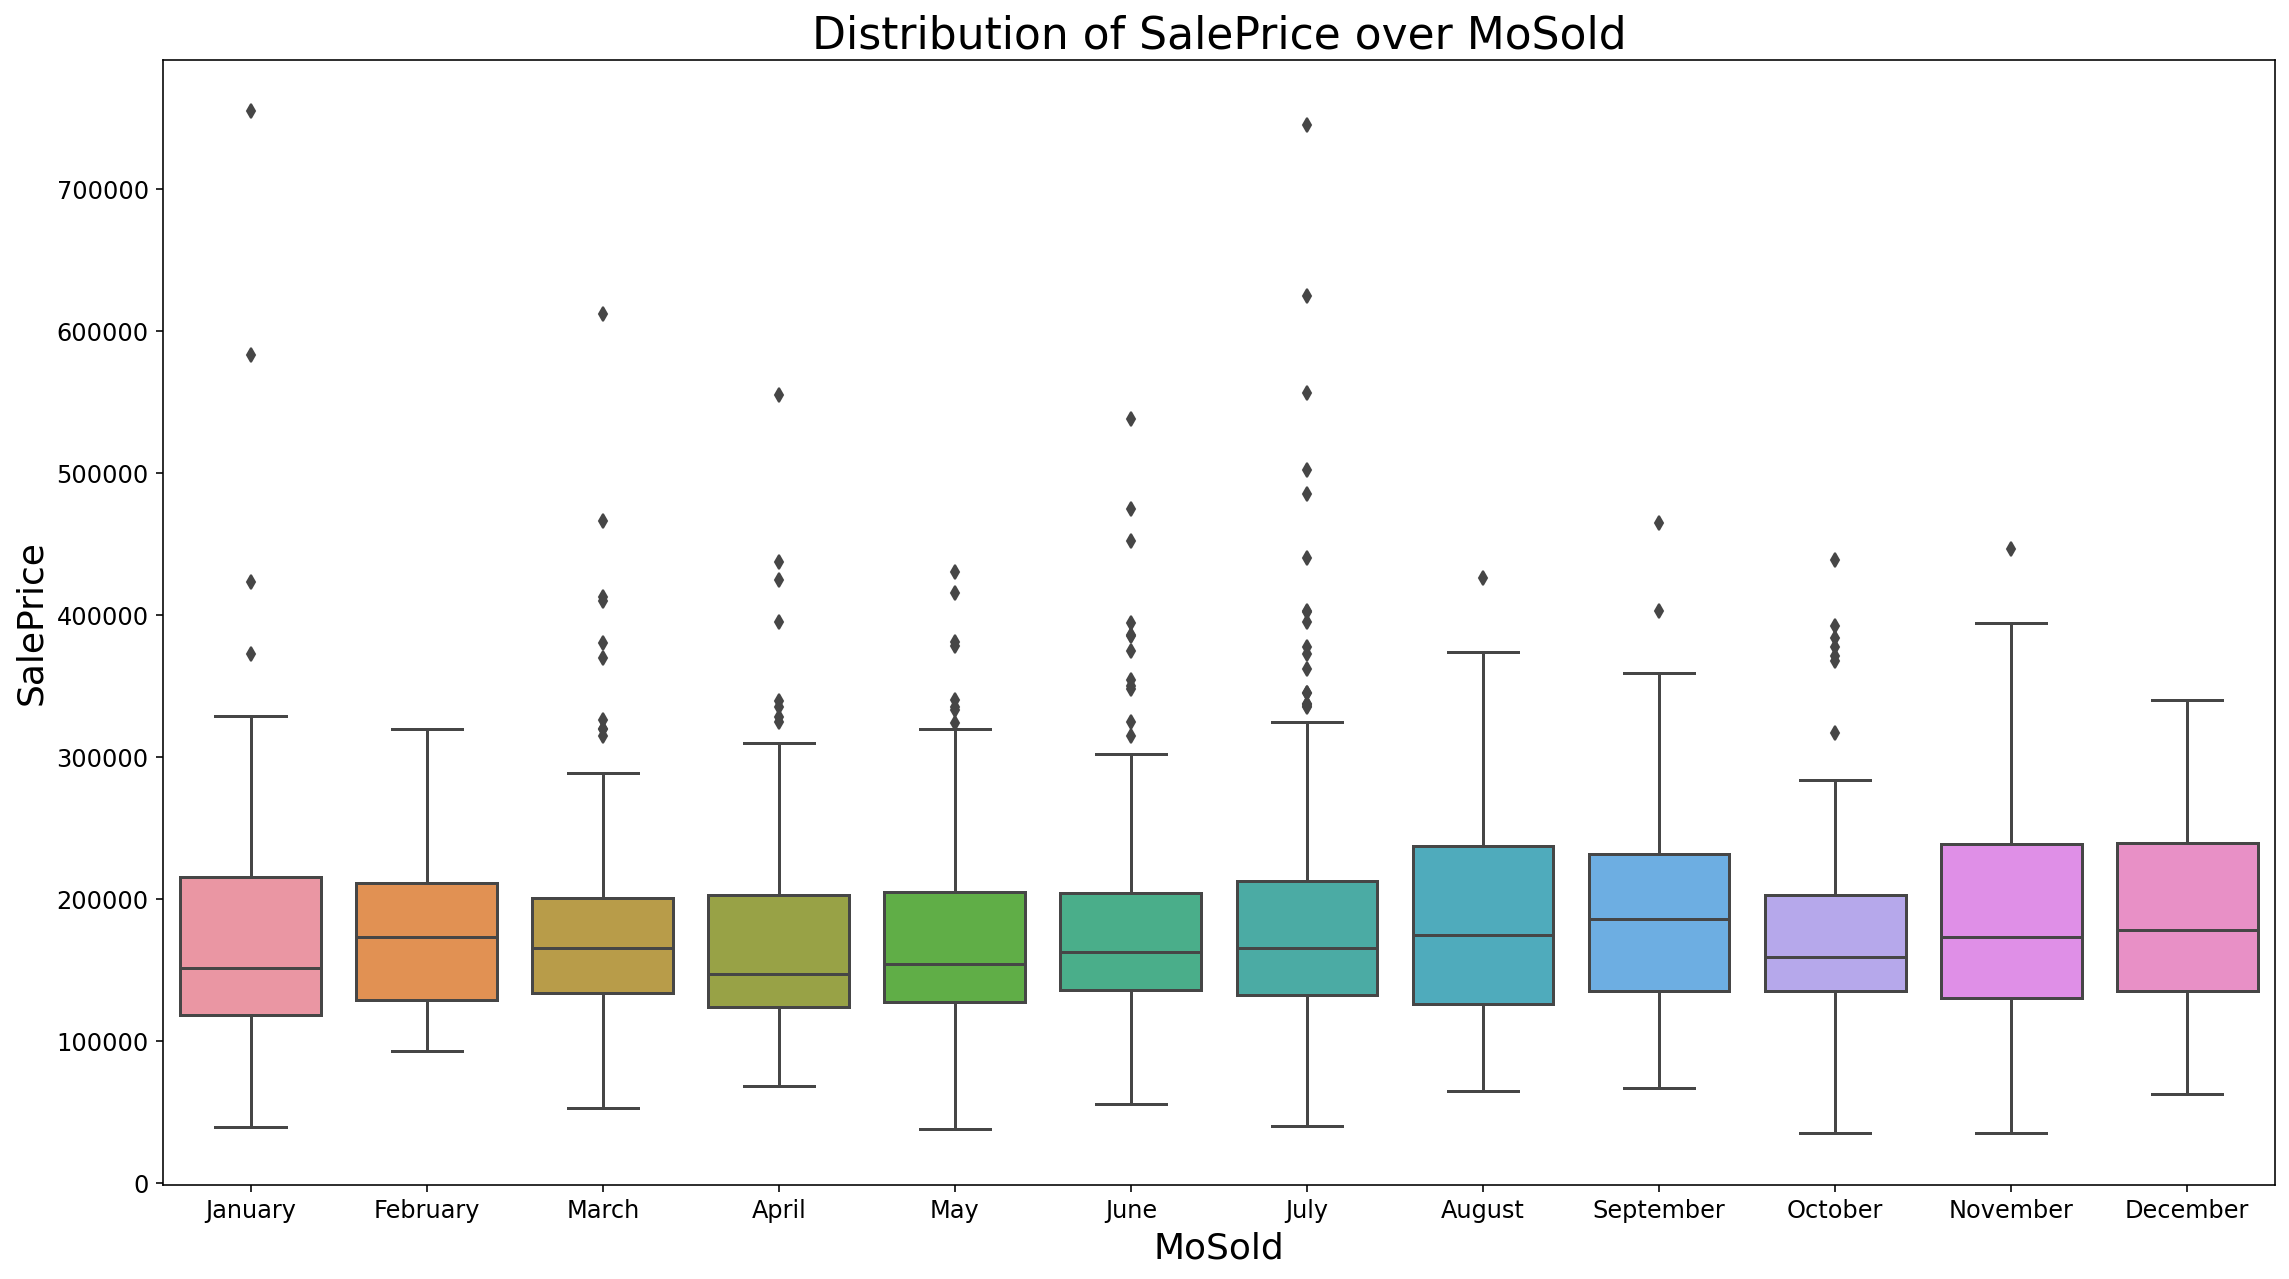

In [21]:
plt.figure(figsize=(16, 5))
df.groupby('YrSold')['SalePrice'].count().plot(kind="bar")
plt.title("Count distribution of YrSold")
plt.ylabel("Count")
plt.xticks(rotation=360)
for index, value in enumerate(df.groupby('YrSold')['SalePrice'].count().to_list()):
    plt.text(index, value+3, str(value), horizontalalignment='center')
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 9))
sns.boxplot(x='YrSold', y='SalePrice', data=df)
plt.title("Distribution of SalePrice over YrSold")
plt.tight_layout()
plt.show()

months_name = calendar.month_name[1:13]
plt.figure(figsize=(16, 5))
df.groupby('MoSold')['SalePrice'].count().plot(kind="bar")
plt.title("Count distribution of MoSold")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(0,12), labels=months_name, rotation=360)
for index, value in enumerate(df.groupby('MoSold')['SalePrice'].count().to_list()):
    plt.text(index, value+3, str(value), horizontalalignment='center')
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 9))
sns.boxplot(x='MoSold', y='SalePrice', data=df)
plt.title("Distribution of SalePrice over MoSold")
plt.xticks(ticks=np.arange(0,12), labels=months_name, rotation=360)
plt.tight_layout()
plt.show()

Observations:
    
- Fewer sales in 2010. Could be either because less samples were collected. Or the financial crisis of 2009 hit the market.
- Most sales in summer months. Could be valuable to bin seasons to additional variables during feature engineering.

Since most of the house were built during the two decades before 2010 let's take this into account and **analyze the actual age of the house in the year of sale**.

In [22]:
df['Age'] = df['YrSold']-df['YearBuilt']
display(df['Age'].describe())

count    1460.000000
mean       36.547945
std        30.250152
min         0.000000
25%         8.000000
50%        35.000000
75%        54.000000
max       136.000000
Name: Age, dtype: float64

* On average properties were 37 years old at the time of sold(approx).
* Buildings were also 30 years -/+37 years old.

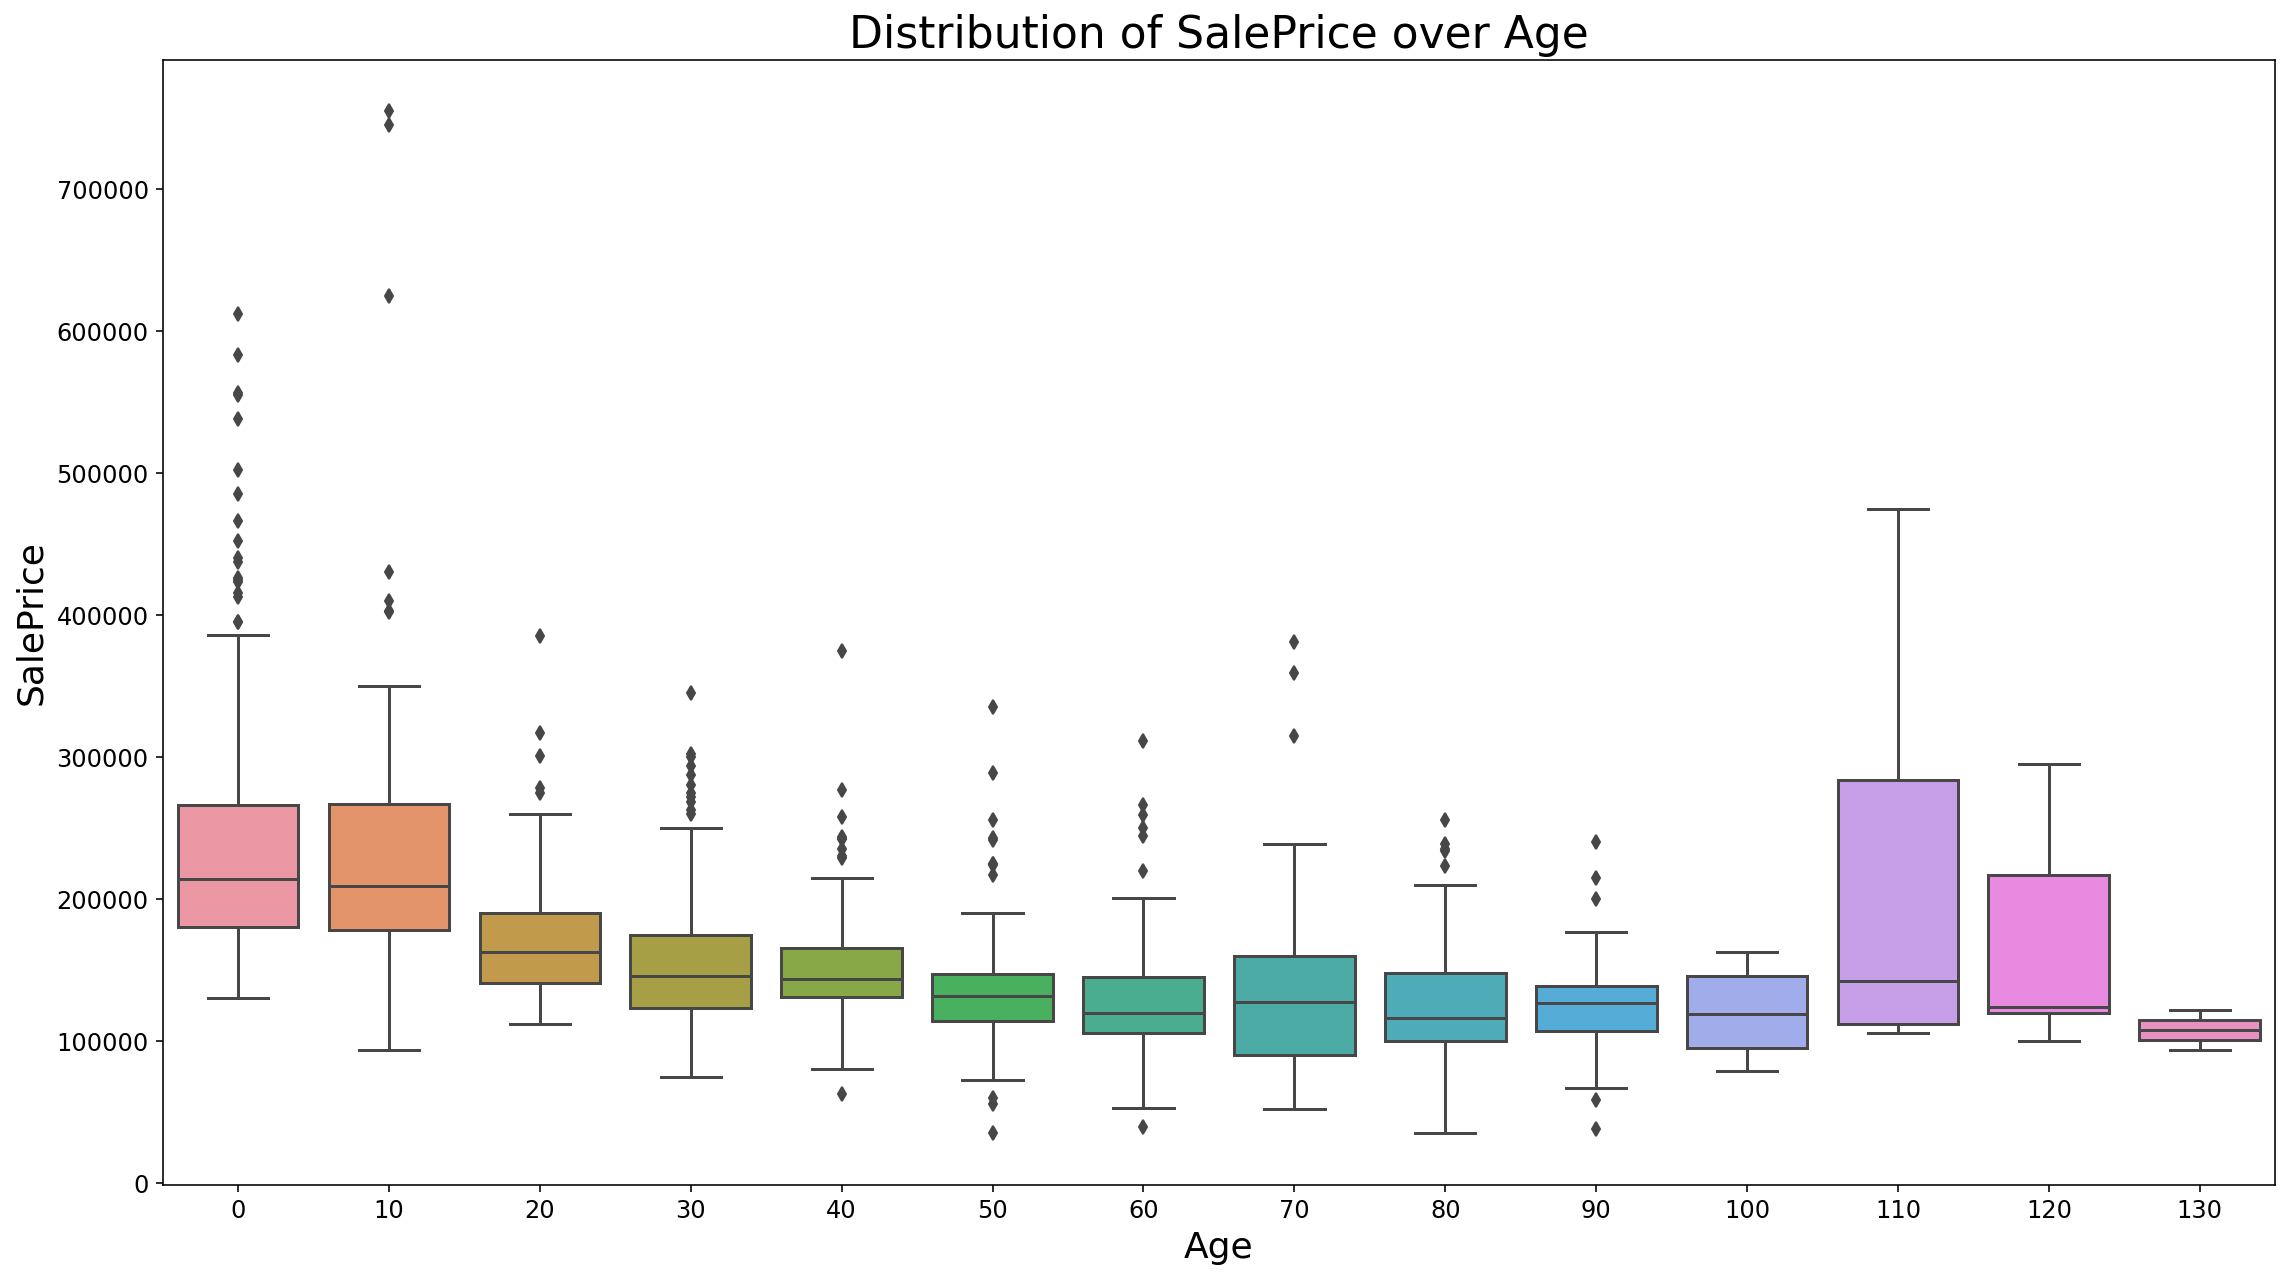

In [23]:
decades = np.arange(0, 141, 10)
df_cut= pd.cut(df.Age, bins=decades, labels=decades[:-1])
df_comb = pd.concat([df_cut, df.SalePrice], axis = 1)

plt.figure(figsize=(16, 5))
df_comb.groupby('Age')['SalePrice'].count().plot(kind='bar')
plt.title("Count distribution of Age")
plt.ylabel("Count")
for index, value in enumerate(df_comb.groupby('Age')['SalePrice'].count().to_list()):
    plt.text(index, value+3, str(value), horizontalalignment='center')
plt.xticks(rotation=360)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,9))
sns.boxplot(x='Age', y='SalePrice', data= df_comb)
plt.title("Distribution of SalePrice over Age")
plt.tight_layout()
plt.show()

* People prefer buying newly built houses
* It's kind off suprising that people bought houses which are 30-50 years old building than buying houses which are 10-29 years old houses. One explanation can be that the houses that are 30-50 years old are cheaper than 10-29 years old houses and also there was financial crisis going on at that time.

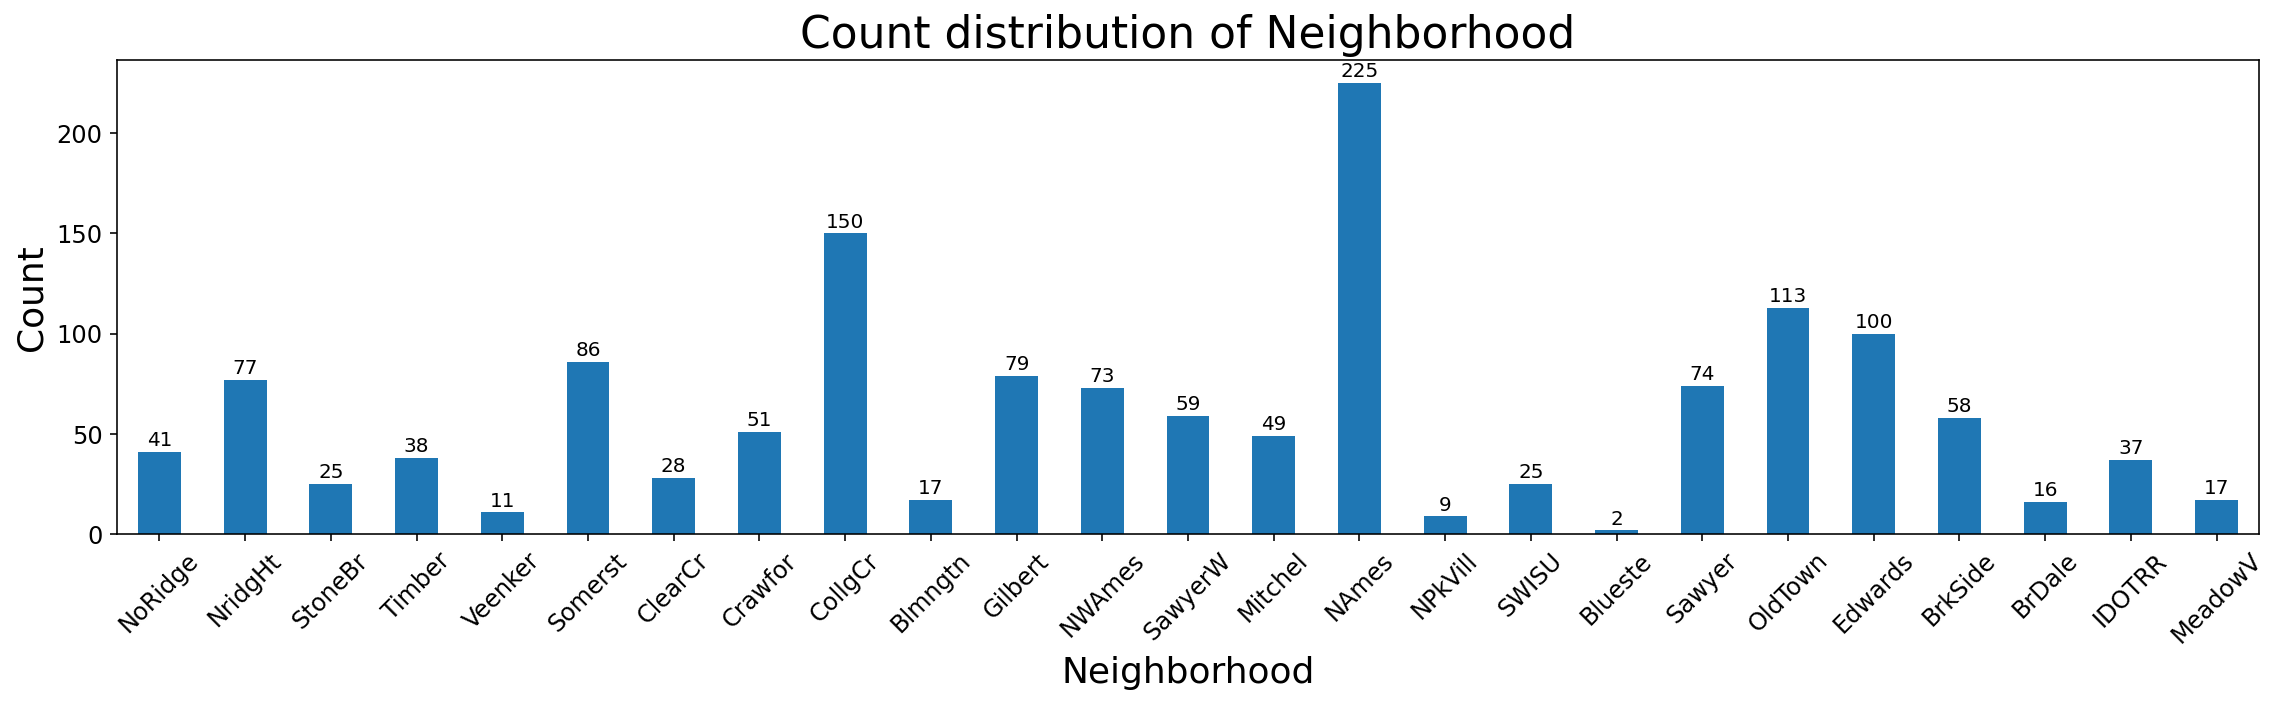

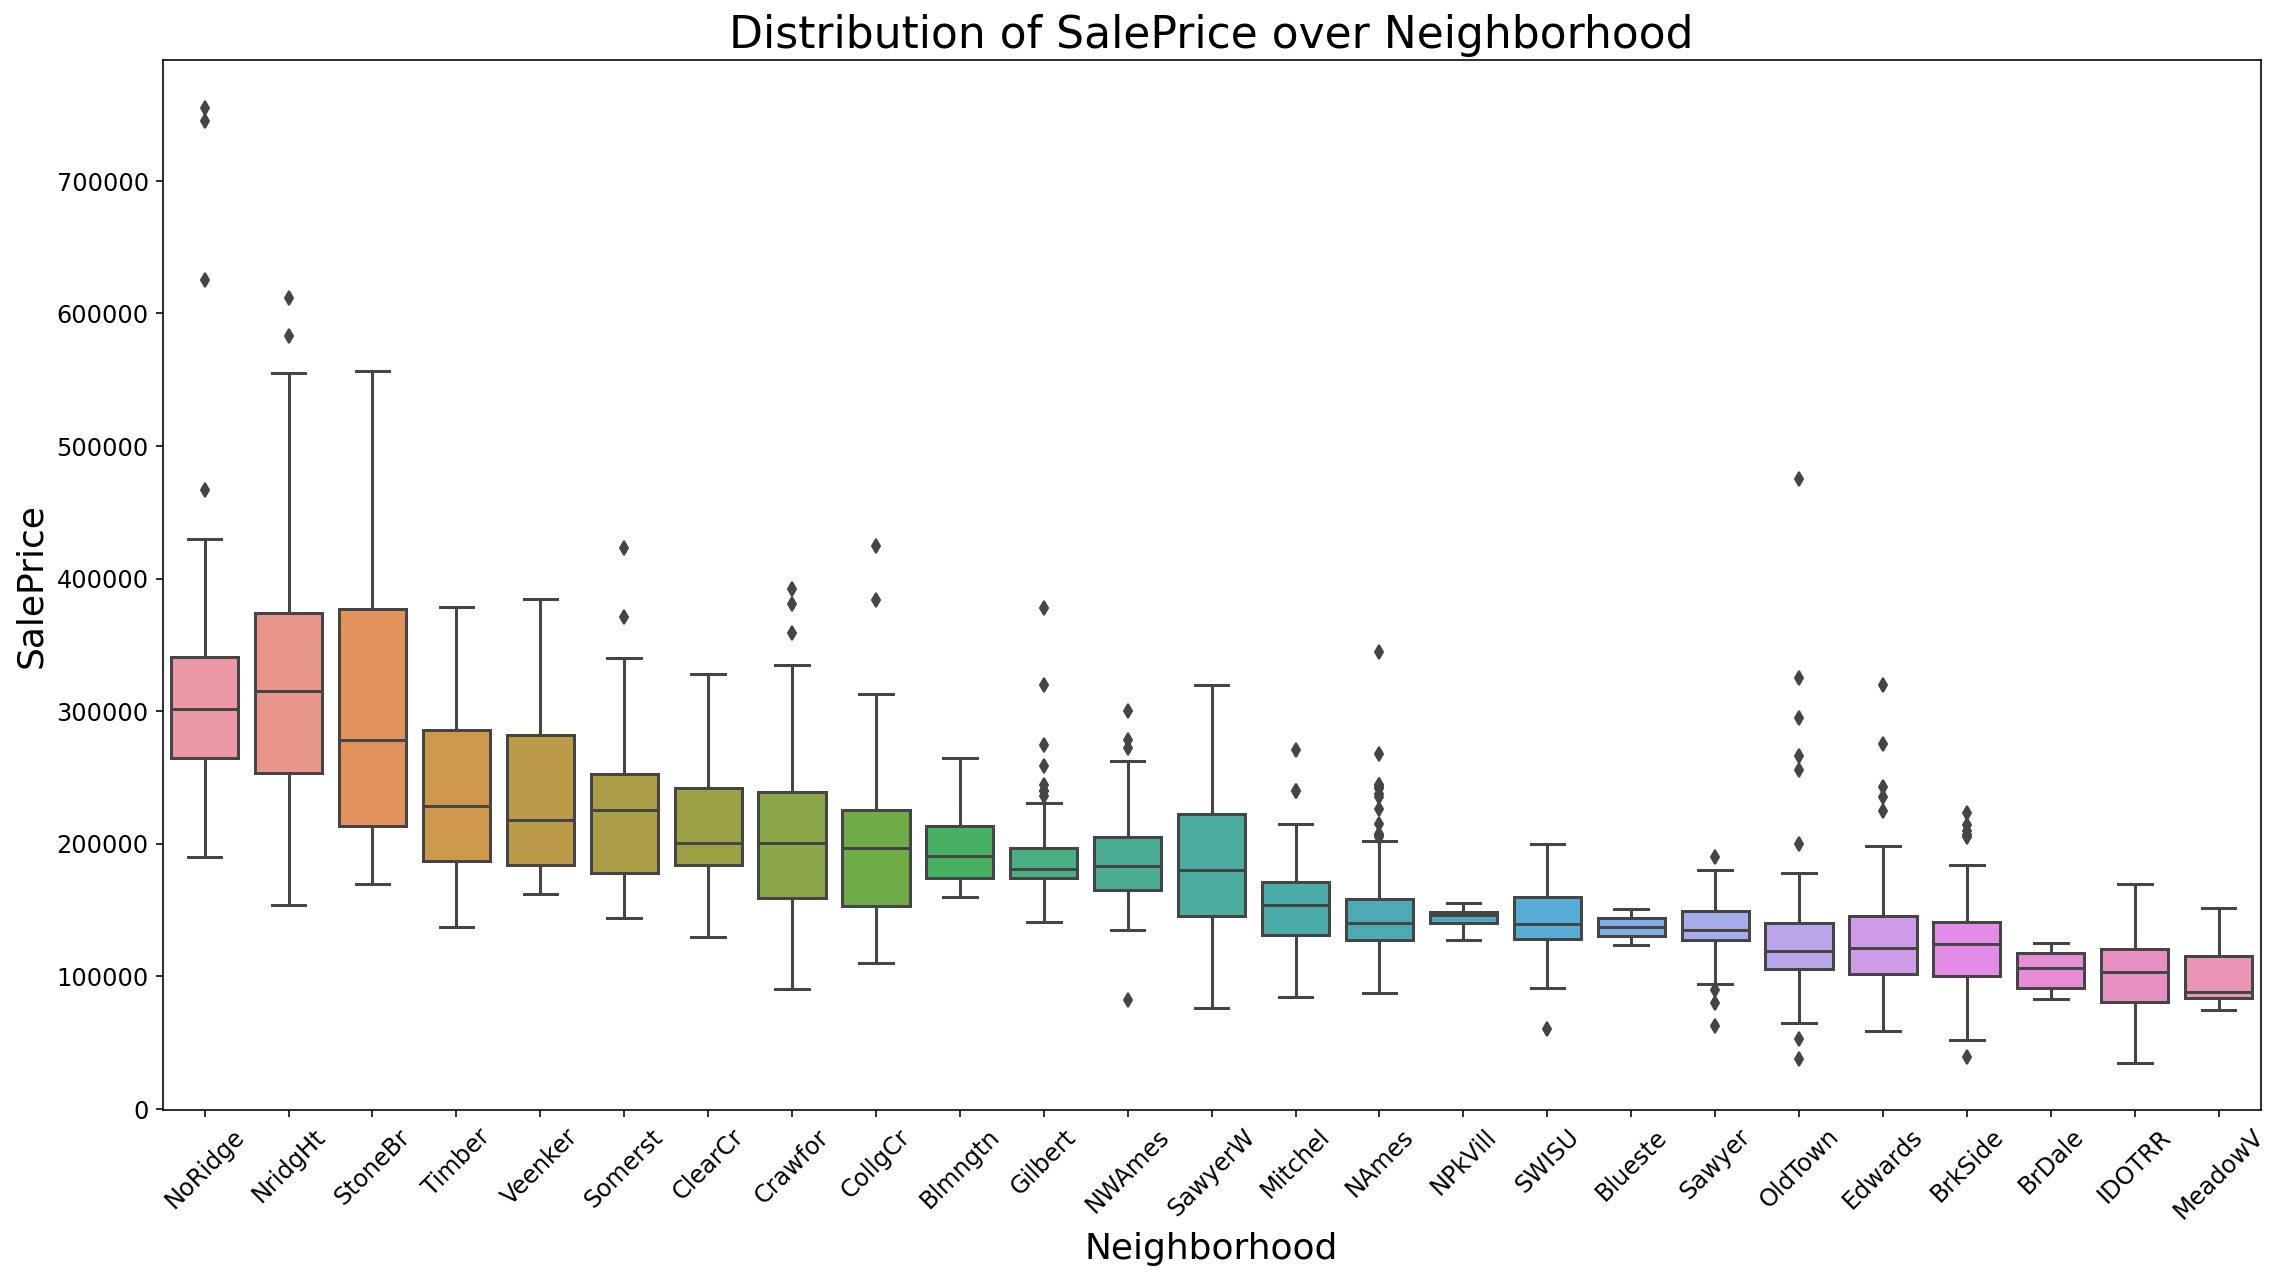

In [24]:
plt.figure(figsize=(16, 5))
order= df.groupby('Neighborhood')['SalePrice'].mean().sort_values(ascending=False).index
df_g = df.groupby("Neighborhood").SalePrice.count()
df_g = df_g.reindex(order)
df_g.plot(kind='bar')
plt.title("Count distribution of Neighborhood")
plt.ylabel("Count")
for index, value in enumerate(df_g.to_list()):
    plt.text(index, value+3, str(value), horizontalalignment='center')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,9))
sns.boxplot(x='Neighborhood', y='SalePrice', data= df, order=order)
plt.title("Distribution of SalePrice over Neighborhood")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The north of Ames seems particularly pricey. A quick look on the map reveals parks, a lake and – golf clubs...

![](https://i.imgur.com/oZLcu99.png)

The least expensive area – Meadow village – in turn lies southwest of the centre, very close to the highway and the airport. So it might be quite noisy there.

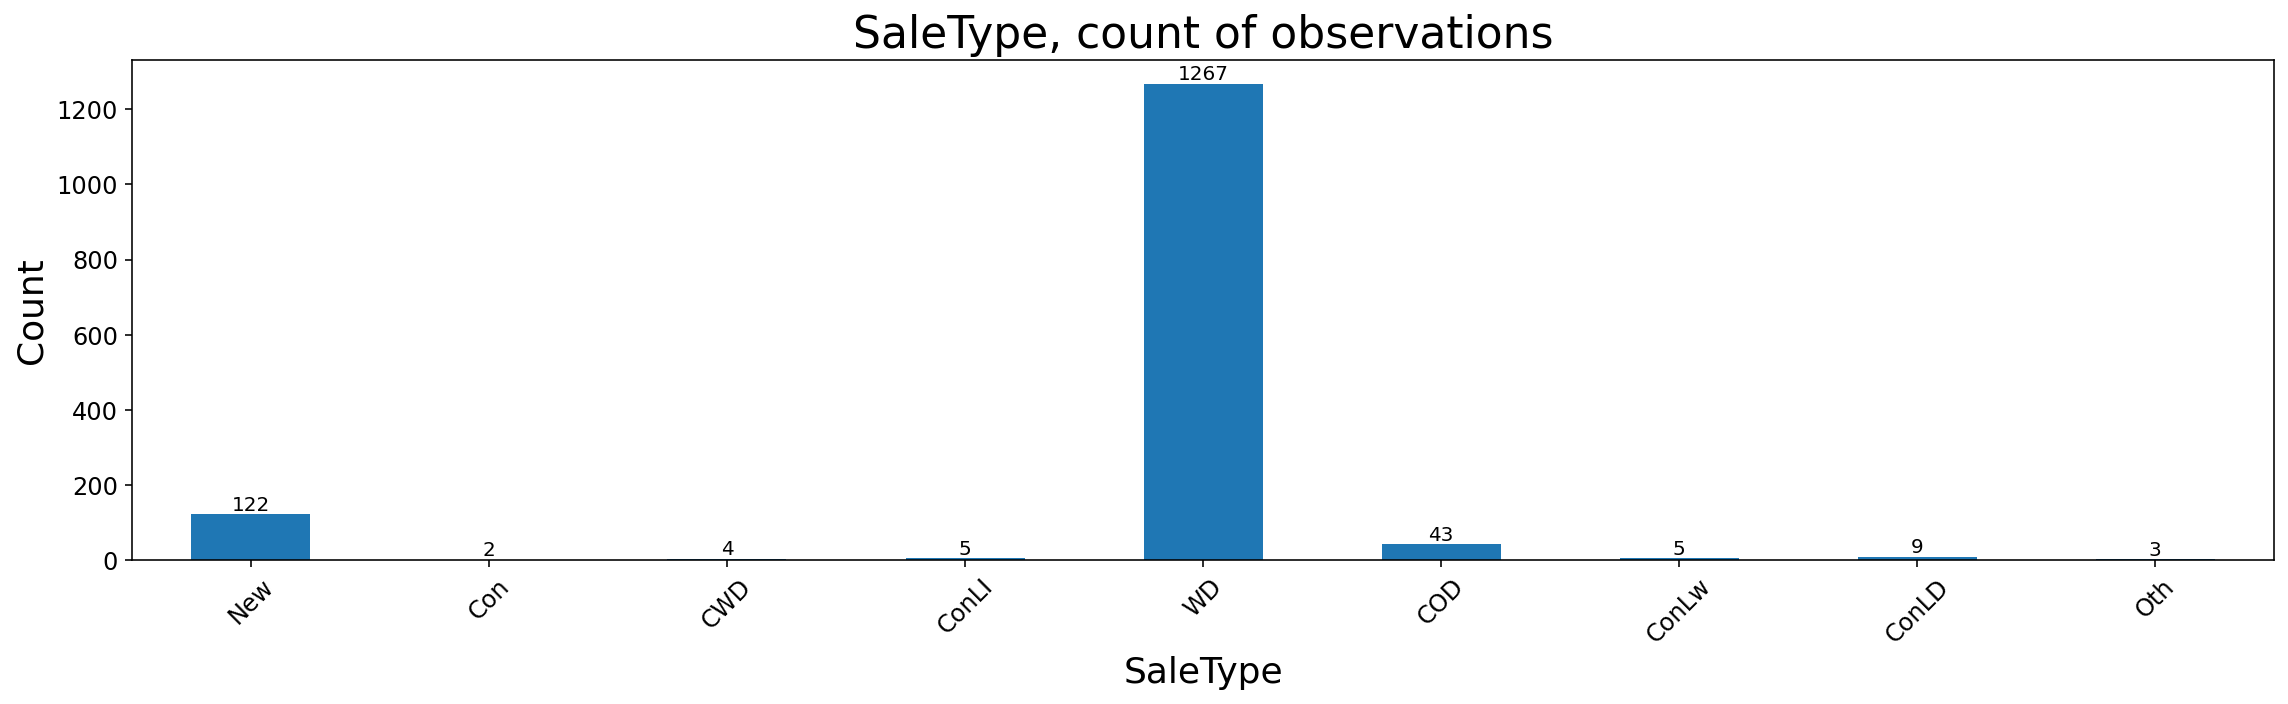

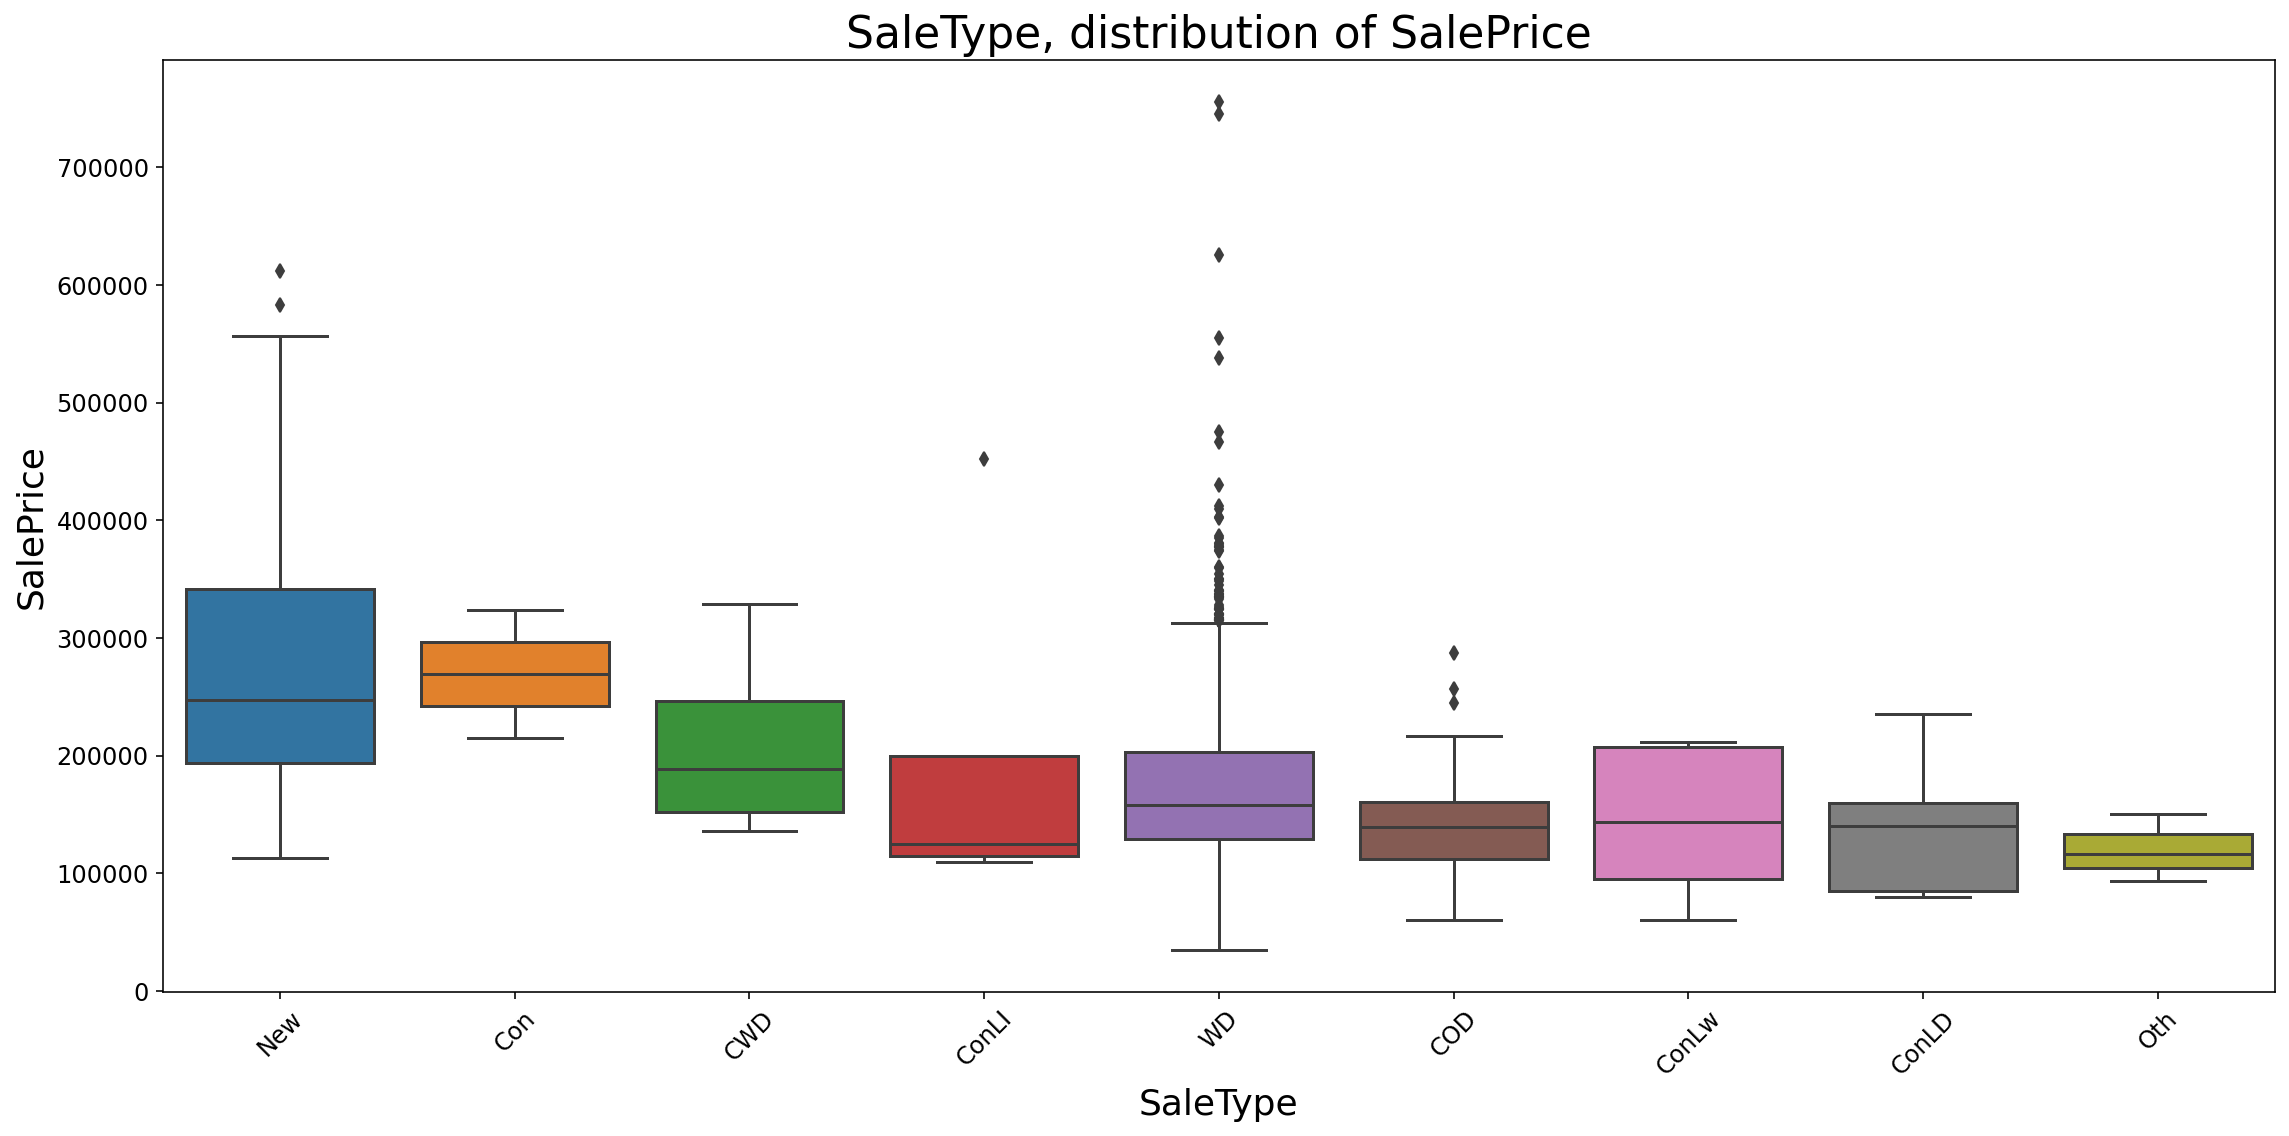

In [25]:
order = df.groupby("SaleType").SalePrice.mean().sort_values(ascending=False).index

plt.figure(figsize=(16,5));
df_g = df.groupby("SaleType").SalePrice.count().sort_values(ascending=False)
df_g = df_g.reindex(order)
df_g.plot(kind="bar")
plt.title("SaleType, count of observations")
plt.ylabel("Count")
for index, value in enumerate(df_g.to_list()):
    plt.text(index, value+10, str(value), horizontalalignment='center')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,8));
ax = sns.boxplot(x="SaleType", y="SalePrice", data=df, order=order)
plt.title(f"SaleType, distribution of SalePrice")
plt.ylabel("SalePrice")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We see 

- 1267 «Warranty Deed – Conventional» (WD) sales
- 122 properties that were sold as «New»
- 43 «Court Officer Deed/Estate» (COD)

New houses sell on average for the highest prices.

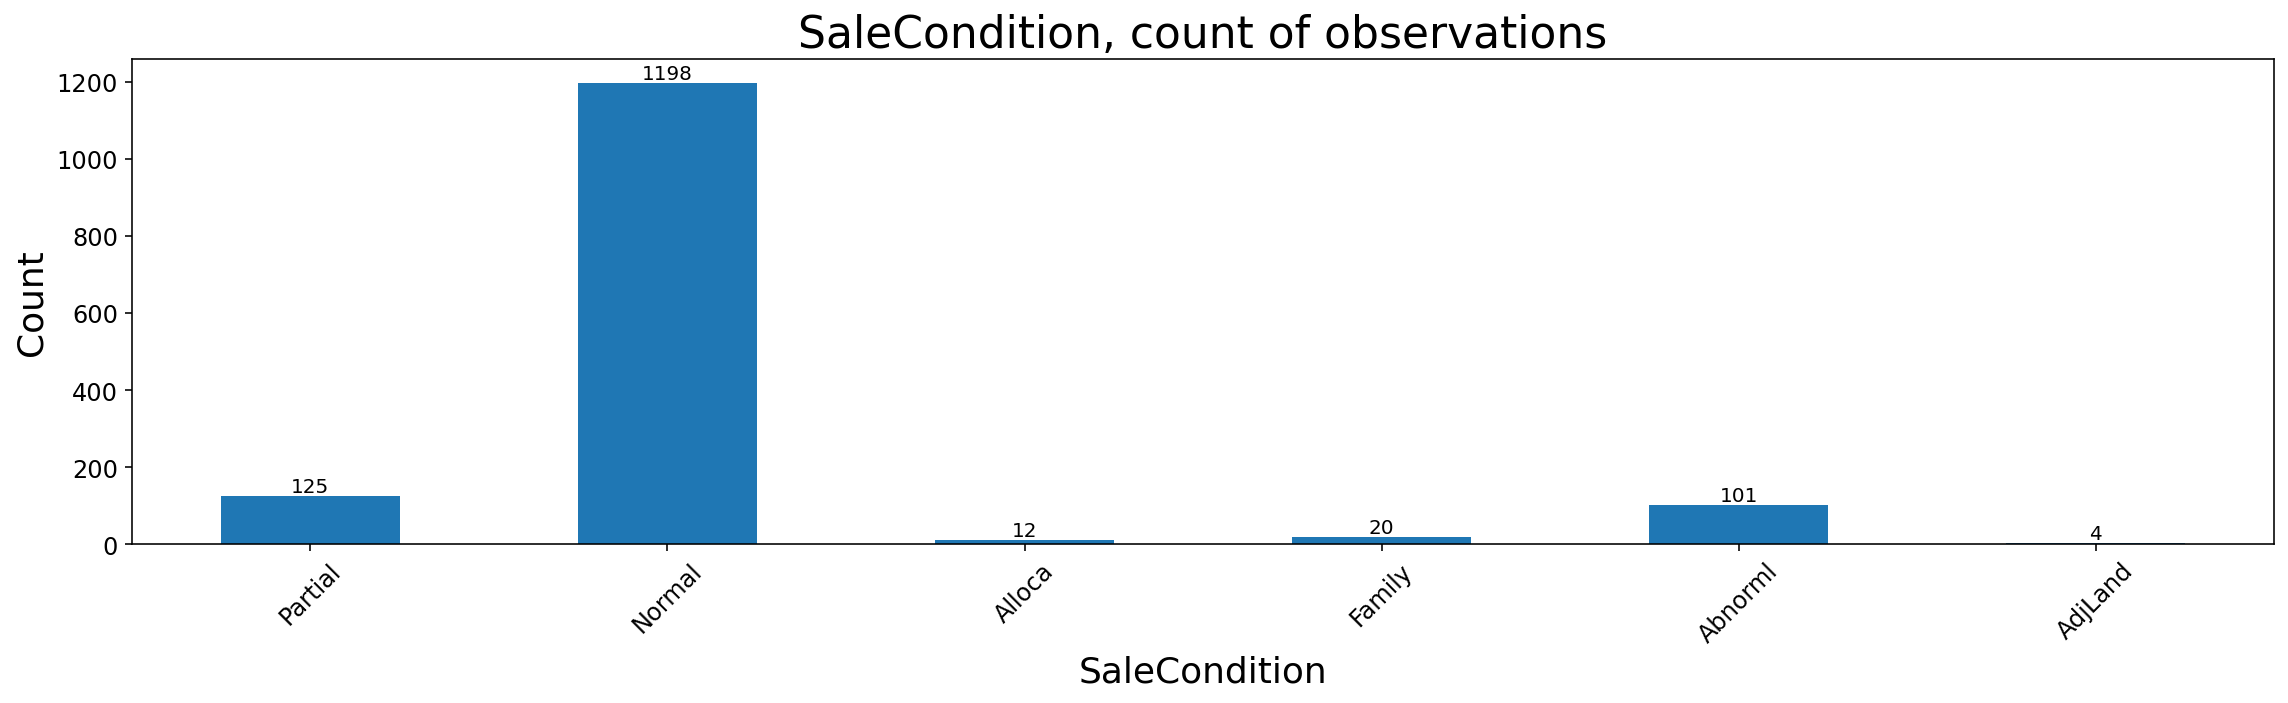

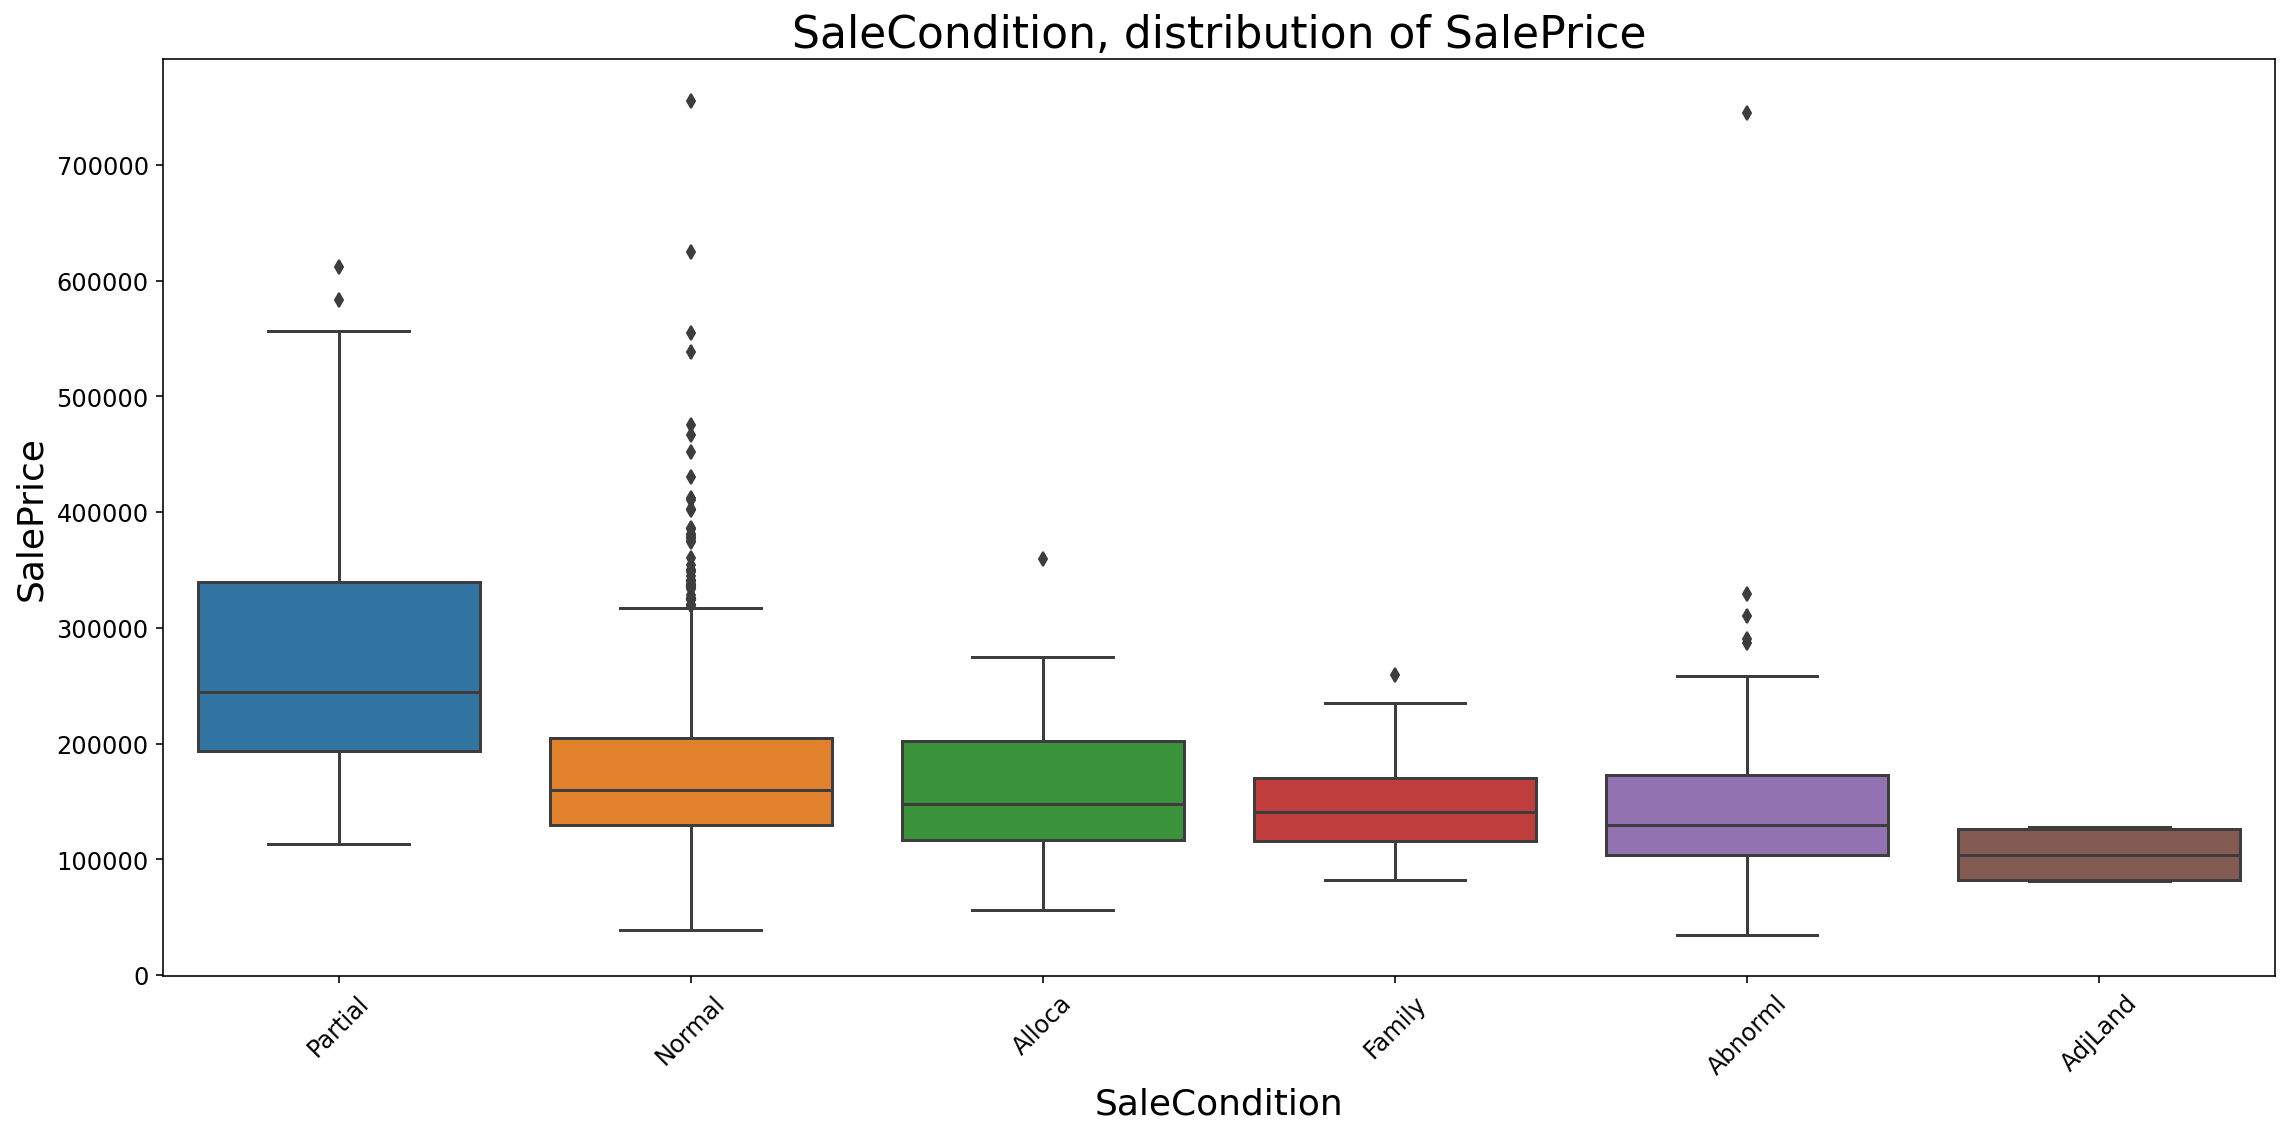

In [26]:
order = df.groupby("SaleCondition").SalePrice.mean().sort_values(ascending=False).index

plt.figure(figsize=(16,5));
df_g = df.groupby("SaleCondition").SalePrice.count().sort_values(ascending=False)
df_g = df_g.reindex(order)
df_g.plot(kind="bar")
for index, value in enumerate(df_g.to_list()):
    plt.text(index, value+10, str(value), horizontalalignment='center')
plt.title("SaleCondition, count of observations")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,8));
sns.boxplot(x="SaleCondition", y="SalePrice", data=df, order=order)
plt.title(f"SaleCondition, distribution of SalePrice")
plt.ylabel("SalePrice")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2.Data cleaning and formatting

![](https://i.imgur.com/VV8pvil.jpg)

In this process we will:
* find and fix missing values.
* remove outliers.
* set correct datatypes.

We start by **plotting all numeric features according to the current pandas dtypes.**

In [27]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
feat = pd.concat([df, df_test]).reset_index(drop=False)

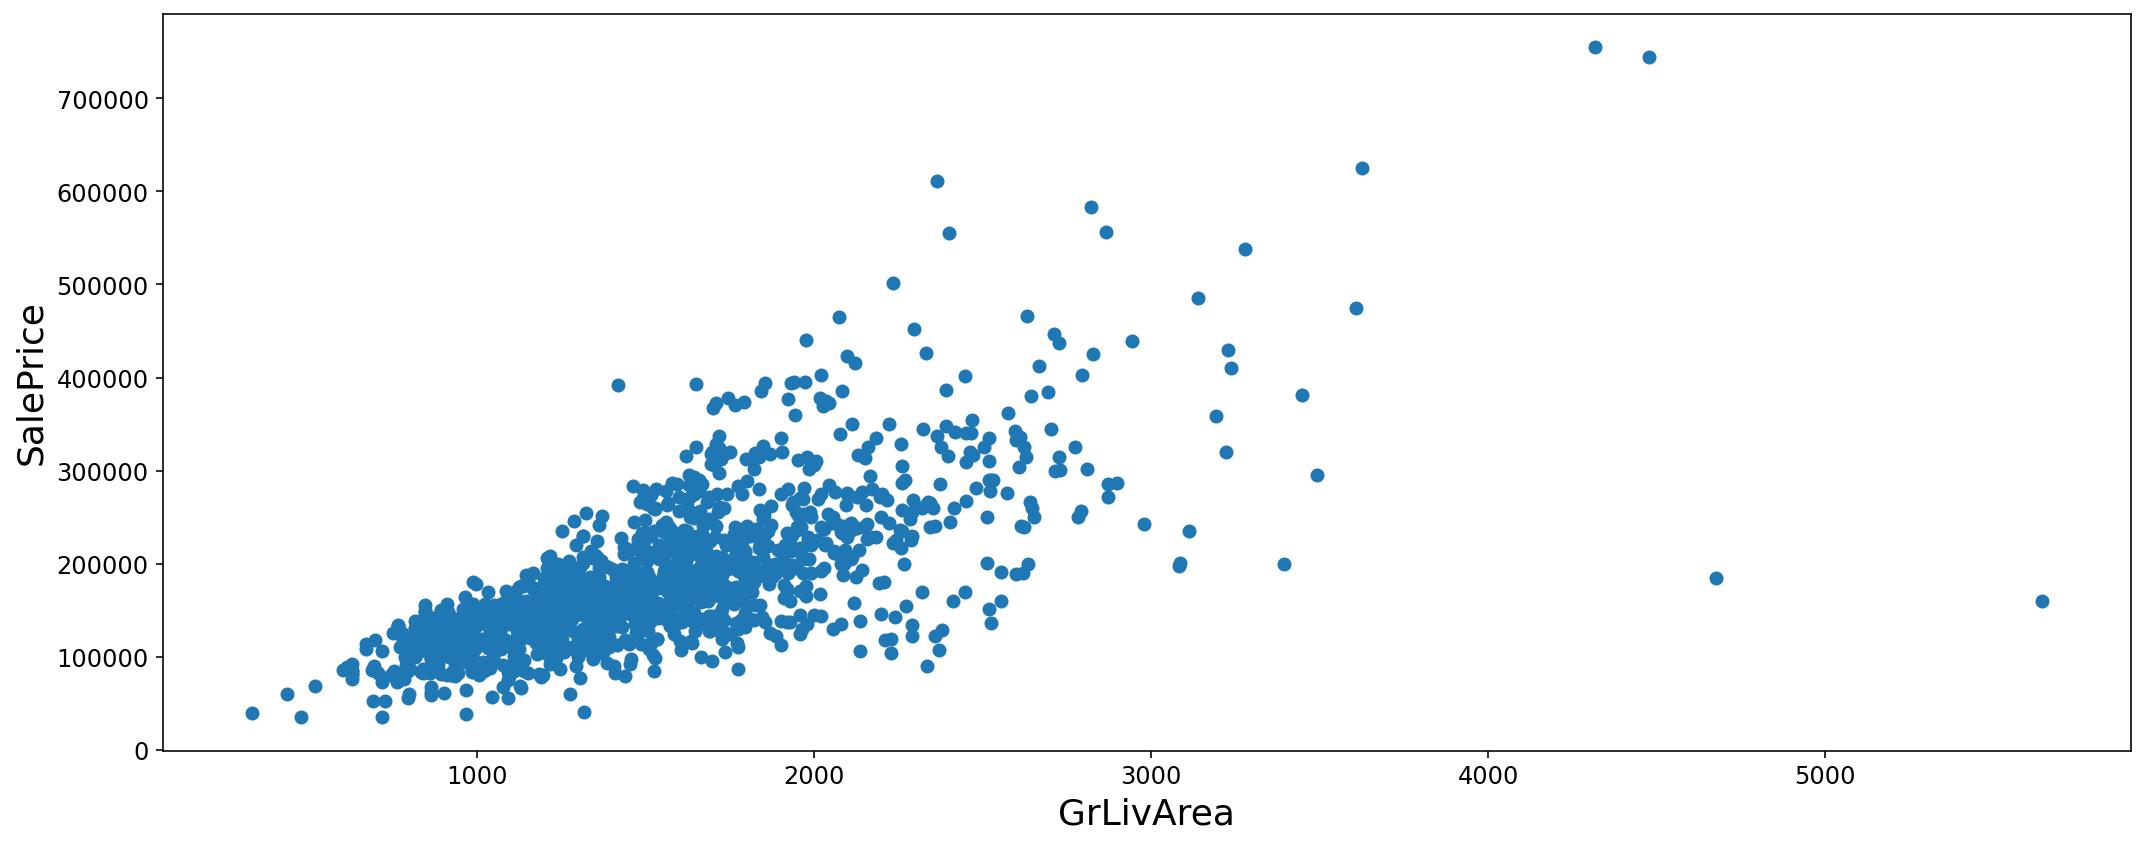

In [28]:
# my code
plt.figure(figsize=(15, 6))
plt.scatter(x=feat['GrLivArea'], y=feat['SalePrice'])
plt.ylabel("SalePrice")
plt.xlabel("GrLivArea")
plt.tight_layout()
plt.show()

In [29]:
# my code
# #Deleting outliers
'''Note : 
 Outliers removal is note always safe.  We decided to delete these two as they 
are very huge and  really  bad ( extremely large areas for very low  prices). 
There are probably others outliers in the training data.   However, removing all 
them  may affect badly our models if ever there were also  outliers  in the test data. 
That's why , instead of removing them all, we will just manage to make some of our  models robust on them.'''

feat=feat.drop(feat[(feat['GrLivArea']>4000) & (feat['SalePrice']<300000)].index)


In [30]:
# my code

#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
feat["SalePrice"] = np.log1p(feat["SalePrice"])
num_feat = feat.drop(['Id', 'SalePrice'], axis=1).select_dtypes('number')


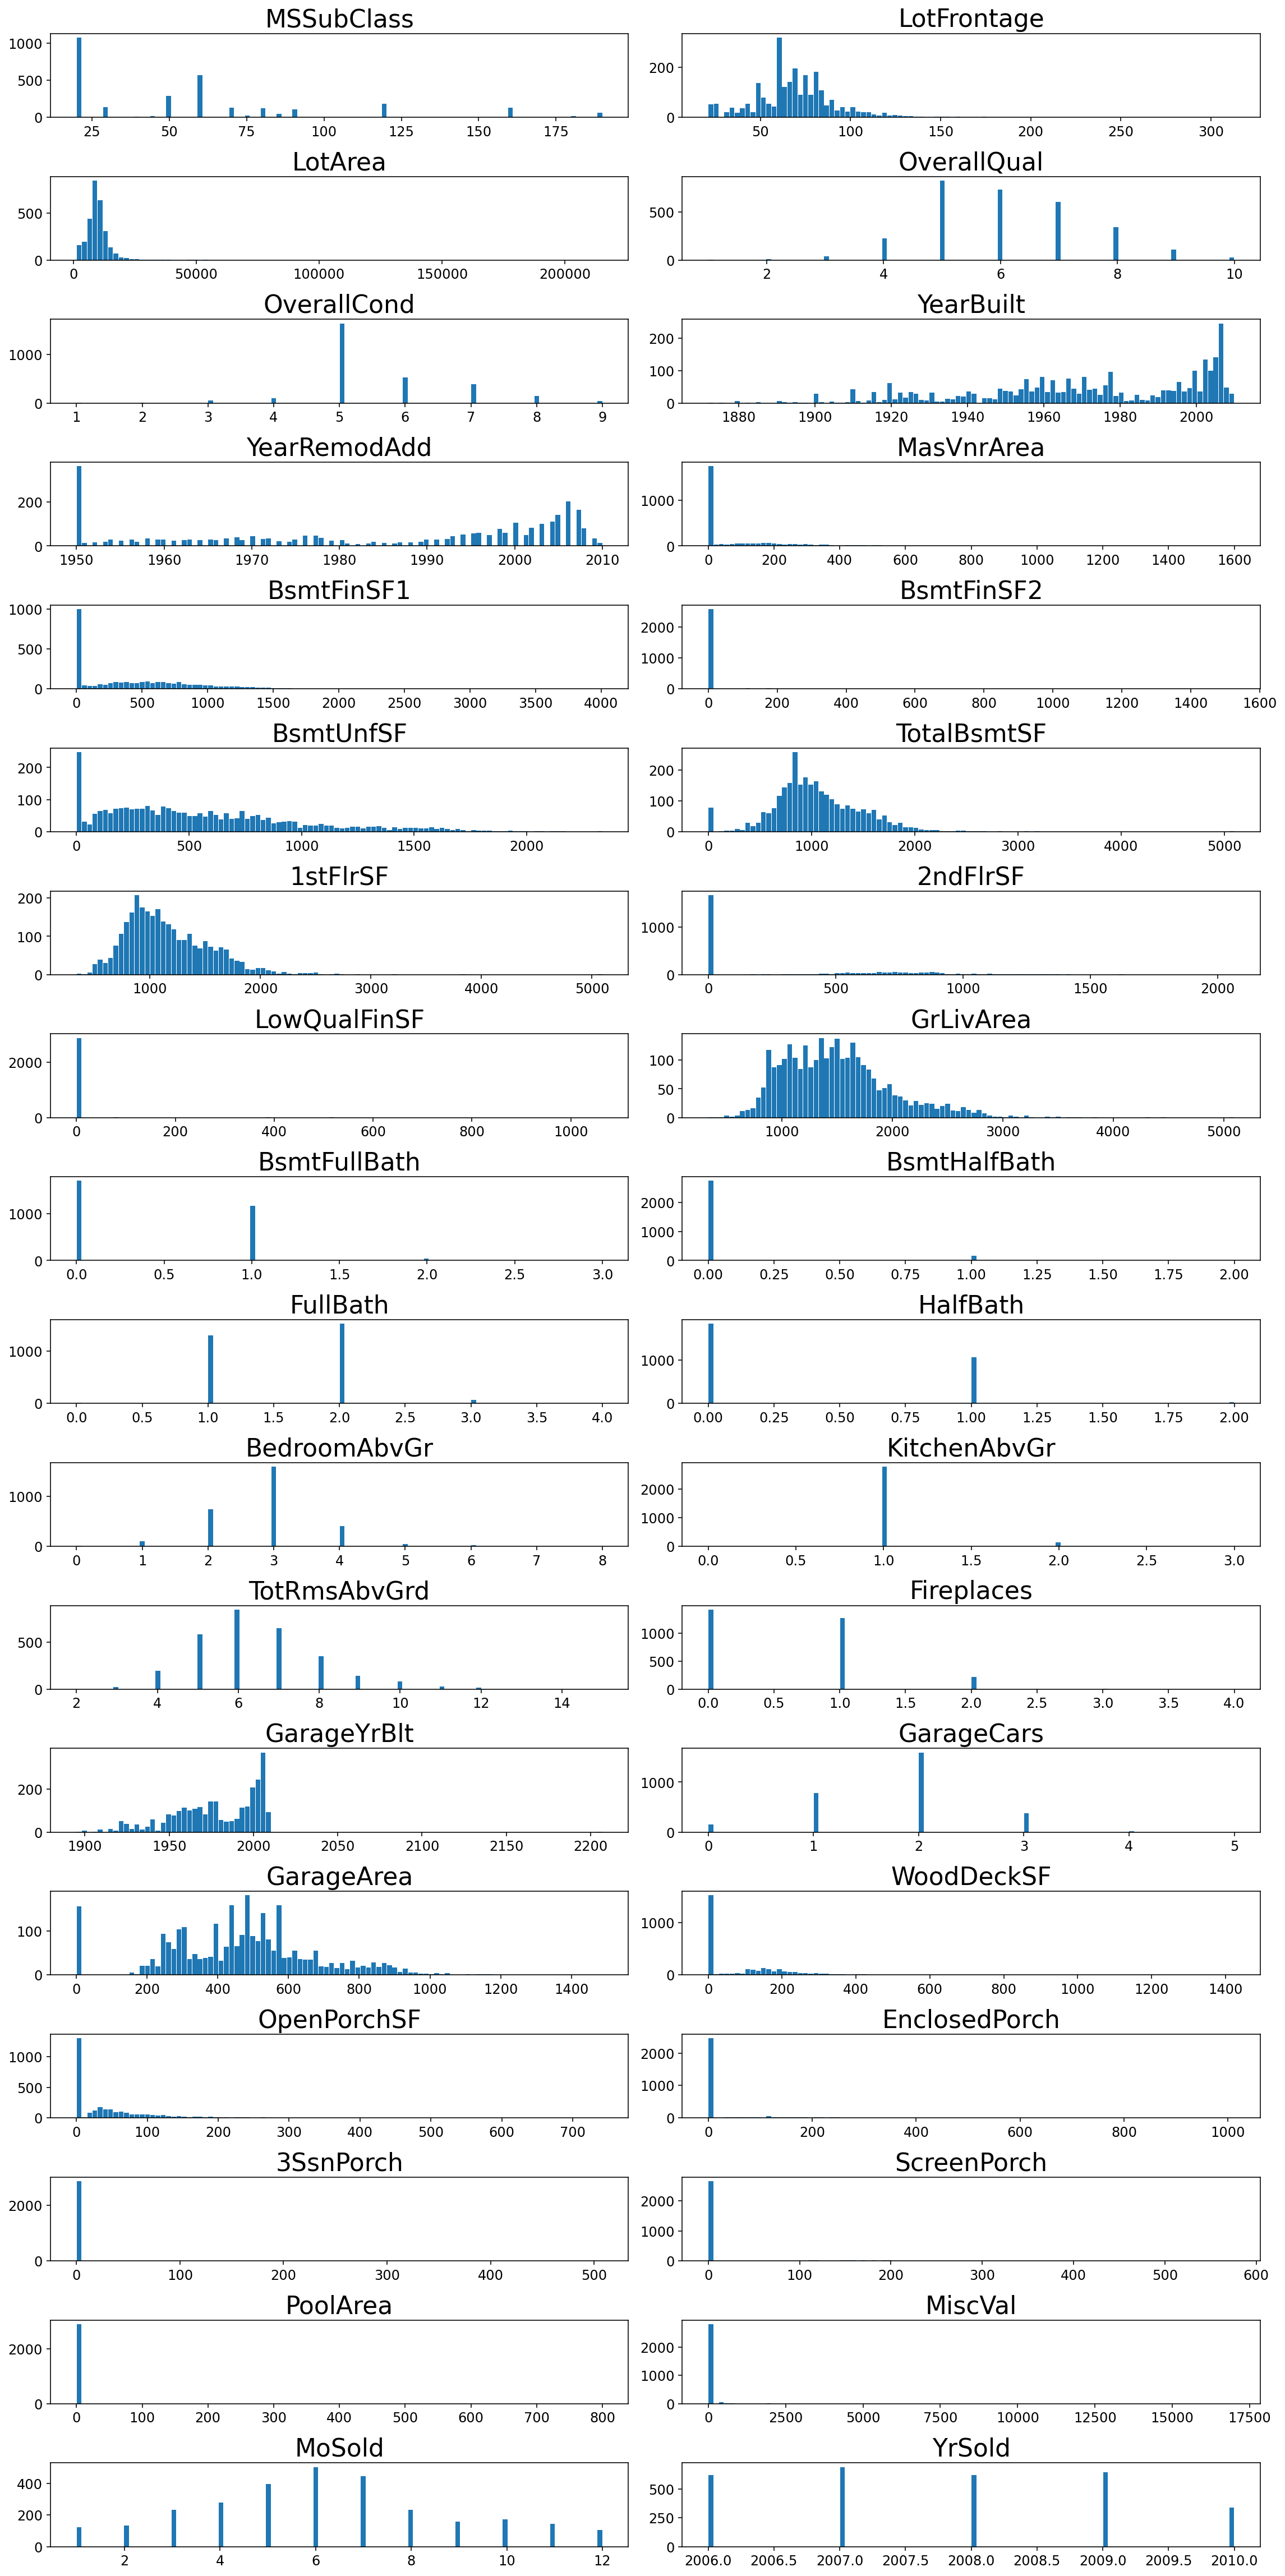

In [31]:
num_feat = feat.drop(['Id', 'SalePrice', 'index'], axis=1).select_dtypes('number')

fig, axes = plt.subplots(nrows=18, ncols=2, figsize=(16, 32))
for index, col in enumerate(num_feat.columns):
    num_feat[col].plot(kind='hist', bins=100, rwidth=0.9, title=col, ax=axes[index//2, index%2])
    ax=axes[index//2, index%2].yaxis.label.set_visible(False)
plt.tight_layout()
plt.show()

We can immediately figure out that some of the features of `dtype="number"` are categorical, many values are 0 and almost all features are skewed.

In [32]:
missing = feat.columns[feat.isna().any()]
print(missing)

Index(['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SalePrice'],
      dtype='object')


In [33]:
# MSZoning - Filling nan with most frequent value <<RL>> (Resident low density)
feat.MSZoning = feat.MSZoning.fillna("RL") 

# LotFrontage(Linear feet of street connected to property) - Filling nan with 0.
feat.LotFrontage = feat.LotFrontage.fillna(0).astype(int)

# Alley - NA means no alley access - fill with string "None"
feat.Alley = feat.Alley.fillna("None")

# Utilities(Type of utilities available like electricity and stuff)- Filling nan with most frequent value <<AllPub>>
feat.Utilities = feat.Utilities.fillna("AllPub")

# Exterior1st(Exterior material used) - Here Nan likely means unknown, fill this with most frequent value <<VinylSd>>
feat.Exterior1st = feat.Exterior1st.fillna("VinylSd")

# Exterior2nd(if more than one Exterior matrial used) - Filling nan with string "None"
feat.Exterior2nd = feat.Exterior2nd.fillna("None")

# MasVnrType(Masonry veneer type) - Here Nan likely means no masonary, fill this with string "None" 
feat.MasVnrType = feat.MasVnrType.fillna("None")

# MasVnrArea - Filling nan with int 0
feat.MasVnrArea = feat.MasVnrArea.fillna(0).astype(int)

# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2 - nan means no basement, fill with string "None"
features = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
for feature in features:
    feat[feature]=feat[feature].fillna("None")

# BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath - fill nan with int 0
features = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
for feature in features:
    feat[feature]=feat[feature].fillna(0).astype(int)

# Electrical(Electrical system) - fill nan with most frequent value <<SBrkr>>
feat.Electrical = feat.Electrical.fillna("SBrkr")

# KitchenQual - fill nan with most frequent value <<TA>>
feat.KitchenQual = feat.KitchenQual.fillna("TA")

# Functional(Home functionality) - fill na with <<Typ>>
feat.Functional = feat.Functional.fillna("Typ")

#FireplaceQu - NaN means no fire place, fill with string "None"
feat.FireplaceQu = feat.FireplaceQu.fillna("None")

# GarageType et al – NA means "no garage", filling with string "None"
grg_cols = ['GarageCond', 'GarageFinish', 'GarageQual', 'GarageType']
for col in grg_cols:
    feat[col] = feat[col].fillna("None")

# Garage sizes: NaN means «no garage» == 0, unsure if build year should be 0?
for col in ['GarageArea', 'GarageCars', 'GarageYrBlt']:
    feat[col] = feat[col].fillna(0).astype(int)

# fix one outlier GarageYrBlt == 2207
to_fix = feat[feat.GarageYrBlt == 2207].index
feat.loc[to_fix, "GarageYrBlt"] = int(feat.GarageYrBlt.mean())

# PoolQC - NA means no Pool - fill with string "None"
feat.PoolQC = feat.PoolQC.fillna("None")

# Fence - NA means no Fence - fill with string "None"
feat.Fence = feat.Fence.fillna("None")

# MiscFeature - NA means no Miscellaneous Features - fill with string "None"
feat.MiscFeature = feat.MiscFeature.fillna("None")

# SaleType: NaNs likely mean unknown, filling with most frequent value «WD»
feat.SaleType = feat.SaleType.fillna("WD")

In [34]:
# label encode ordinal features where there is order in categories
# unfortunately can't use LabelEncoder or pd.factorize() since strings do not contain order of values

feat = feat.replace({  "Alley":        {"None" : 0, "Grvl" : 1, "Pave" : 2},
                       "BsmtCond":     {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, 
                                        "Gd" : 4, "Ex" : 5},
                       "BsmtExposure": {"None" : 0, "No" : 2, "Mn" : 2, "Av": 3, 
                                        "Gd" : 4},
                       "BsmtFinType1": {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, 
                                        "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2": {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, 
                                        "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual":     {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, 
                                        "Gd" : 4, "Ex" : 5},
                       "CentralAir":   {"None" : 0, "N" : 1, "Y" : 2},
                       "ExterCond":    {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, 
                                        "Gd": 4, "Ex" : 5},
                       "ExterQual":    {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, 
                                        "Gd": 4, "Ex" : 5},
                       "Fence":        {"None" : 0, "MnWw" : 1, "GdWo" : 2, "MnPrv": 3, 
                                        "GdPrv" : 4},
                       "FireplaceQu":  {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, 
                                        "Gd" : 4, "Ex" : 5},
                       "Functional":   {"None" : 0, "Sal" : 1, "Sev" : 2, "Maj2" : 3, 
                                        "Maj1" : 4, "Mod": 5, "Min2" : 6, "Min1" : 7, 
                                        "Typ" : 8},
                       "GarageCond":   {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, 
                                        "Gd" : 4, "Ex" : 5},
                       "GarageQual":   {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, 
                                        "Gd" : 4, "Ex" : 5},
                       "GarageFinish": {"None" : 0, "Unf" : 1, "RFn" : 2, "Fin" : 3},
                       "HeatingQC":    {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, 
                                        "Gd" : 4, "Ex" : 5},
                       "KitchenQual":  {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, 
                                        "Gd" : 4, "Ex" : 5},
                       "LandContour":  {"None" : 0, "Low" : 1, "HLS" : 2, "Bnk" : 3, 
                                        "Lvl" : 4},
                       "LandSlope":    {"None" : 0, "Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape":     {"None" : 0, "IR3" : 1, "IR2" : 2, "IR1" : 3, 
                                        "Reg" : 4},
                       "PavedDrive":   {"None" : 0, "N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC":       {"None" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, 
                                        "Ex" : 4},
                       "Street":       {"None" : 0, "Grvl" : 1, "Pave" : 2},
                       "Utilities":    {"None" : 0, "ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, 
                                        "AllPub" : 4}}
                     )

feat.BsmtCond = feat.BsmtCond.astype(int)

In [35]:
def onehot_encode(data):
    df_obj = data.select_dtypes(include=['object'])
    df_num = data.select_dtypes(exclude=['object'])
    cols=[]
    for c in df_obj:
        dummies = pd.get_dummies(df_obj[c])
        dummies.columns = [c+'_'+str(x) for x in dummies.columns]
        cols.append(dummies)
    df_obj = pd.concat(cols, axis=1)
    df = pd.concat([df_num, df_obj], axis=1)
    df.reset_index(inplace=True, drop=True)
    df = df.drop('index', axis=1)
    return df

feat = onehot_encode(feat)


In [36]:
feat.head()

Id  MSSubClass  ...  SaleCondition_Normal  SaleCondition_Partial
0   1          60  ...                     1                      0
1   2          20  ...                     1                      0
2   3          60  ...                     1                      0
3   4          70  ...                     0                      0
4   5          60  ...                     1                      0

[5 rows x 220 columns]

## 3.Feature engineering

![](https://i.imgur.com/DPq4YkX.jpg)

1. Next step is to create new features by combining existing ones.

In [37]:
seasons = {12:0, 1:0, 2:0,
           3:1, 4:1, 5:1,
           6:2, 7:2, 8:2,
           9:3, 10:3, 11:3}

feat['SeasonSold'] = feat['MoSold'].map(seasons)
feat['YrActualAge'] = feat['YrSold']-feat['YearBuilt']

feat['TotalSF1'] = feat['TotalBsmtSF']+feat['1stFlrSF']+feat['2ndFlrSF']
feat['TotalSF2'] = feat['BsmtFinSF1']+feat['BsmtFinSF2']+feat['1stFlrSF']+feat['2ndFlrSF']
feat['AllSF'] = feat['GrLivArea']+feat['TotalBsmtSF']

feat['AllFlrsSF'] = feat['1stFlrSF']+feat['2ndFlrSF']
feat["AllPorchSF"] = feat["OpenPorchSF"] + feat["EnclosedPorch"] + feat["3SsnPorch"] + feat["ScreenPorch"]
feat['TotalPorch'] = (feat['OpenPorchSF'] + feat['3SsnPorch'] + feat['EnclosedPorch'] + feat['ScreenPorch'] + feat['WoodDeckSF'])

feat["OverallScore"]   = feat["OverallQual"] * feat["OverallCond"]
feat["GarageScore"]    = feat["GarageQual"] * feat["GarageCond"]
feat["ExterScore"]     = feat["ExterQual"] * feat["ExterCond"]
feat["KitchenScore"]   = feat["KitchenAbvGr"] * feat["KitchenQual"]
feat["FireplaceScore"] = feat["Fireplaces"] * feat["FireplaceQu"]
feat["GarageScore"]    = feat["GarageArea"] * feat["GarageQual"]
feat["PoolScore"]      = feat["PoolArea"] * feat["PoolQC"]

feat['hasPool']        = feat['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
feat['has2ndFloor']    = feat['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
feat['hasGarage']      = feat['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
feat['hasBsmt']        = feat['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
feat['hasFireplace']   = feat['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [38]:
# create new ordinal features by binning continuous features
# log transform values before binning taking into account skewed distributions

cut_cols = ["LotArea", "YearBuilt", "YearRemodAdd", "MasVnrArea", 'BsmtFinSF1',
            'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
            'LowQualFinSF', 'GrLivArea', "GarageYrBlt", 'GarageArea', 'WoodDeckSF', 'OpenPorchSF']

frames=[]
for  c in cut_cols:
    temp = pd.DataFrame(pd.cut(np.log1p(feat[c]), bins=10, labels=np.arange(0, 10)))
    temp.columns = [c+"_binned"]
    frames.append(temp)

binned = pd.concat(frames, axis=1).astype(int)
feat = pd.concat([feat, binned], axis=1)

In [39]:
feat.head()

Id  MSSubClass  ...  WoodDeckSF_binned  OpenPorchSF_binned
0   1          60  ...                  0                   6
1   2          20  ...                  7                   0
2   3          60  ...                  0                   5
3   4          70  ...                  0                   5
4   5          60  ...                  7                   6

[5 rows x 255 columns]

## 4.Try out and compare various classifiers

In [40]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

dtrain = feat[feat.SalePrice.notnull()]
dtest = feat[feat.SalePrice.isnull()]
dtest = dtest.drop('SalePrice', axis=1)
dtest = dtest.reset_index(drop=True)
print(f'Raw data shape: {df.shape} {df_test.shape}')
print(f'Raw data shape: {df.shape} {dtest.shape}')

Raw data shape: (1460, 81) (1459, 80)
Raw data shape: (1460, 81) (1459, 254)


<font color="purple"> 
### 🤖 Experiment 0: Get a baseline with the DummyRegressor

To get a basic baseline for all other experiment, we setup a dummy regressor, that simply predict a constant that we define, e.g. the median of all the sale price values in our training data.

In [41]:
X=df
y=df.SalePrice
metric = 'neg_mean_squared_log_error'
clf = DummyRegressor("median")
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
print(f"{np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean():.4f} Log error")

# clf.fit(X, y)
# predictions_exp=clf.predict(df_test)
# prediction_final = pd.DataFrame(predictions_exp)
# submission = pd.DataFrame({'Id': df_test.Id.values, 'SalePrice': predictions_exp})
# submission.to_csv(f"submission.csv", index=False)

0.3989 Log error


Always predicting the median of SalePrice with **the Dummy regressor gets us something like rank #4887 of around 5210 submissions** (at time of writing). This btw. is very close to the sample submission benchmark."

<font color="purple"> 
### 🤖 Experiment 01: Training with just one feature

Let's see how far can we go with **just one feature and Linear Regression**. We have seen that `GrLivArea` has highest correlation with `SalePrice` from EDA, so we are going to use `GrLivArea` as our only feature.

In [42]:
X=df[['GrLivArea']]
y=df.SalePrice
metric = 'neg_mean_squared_log_error'
clf = LinearRegression()
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
print(f"{np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean():.4f} Log error")

# clf.fit(X, y)
# predictions_exp=clf.predict(df_test[['GrLivArea']])
# prediction_final = pd.DataFrame(predictions_exp)
# submission = pd.DataFrame({'Id': df_test.Id.values, 'SalePrice': predictions_exp})
# submission.to_csv(f"submission.csv", index=False)

0.2750 Log error


Cool. Much better. Already **jumped from rank #4887 to #4599 on the Leaderboard with just one feature!** 

Let's try a categorical instead.

In [43]:
X=df[['OverallCond']]
y=df.SalePrice
metric = 'neg_mean_squared_log_error'
clf = LinearRegression()
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
print(f"{np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean():.4f} Log error")

0.4064 Log error


Now let's check for OverallQual

In [44]:
try:    
    X = df[["OverallQual"]]
    y = df.SalePrice
    metric = 'neg_mean_squared_log_error'
    clf = LinearRegression()
    kfold = KFold(n_splits=10, shuffle=True, random_state=1)
    print(f"{np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean():.4f} Log Error")
except Exception as e:
    print("Oh no... An error has occured...")
    print(e)

Oh no... An error has occured...
Mean Squared Logarithmic Error cannot be used when targets contain negative values.


What's happening here... Linear regression is predicting values for SalePrice and that crashes the validation scoring with our metric.

But why negative values at all? Let's find that out. 

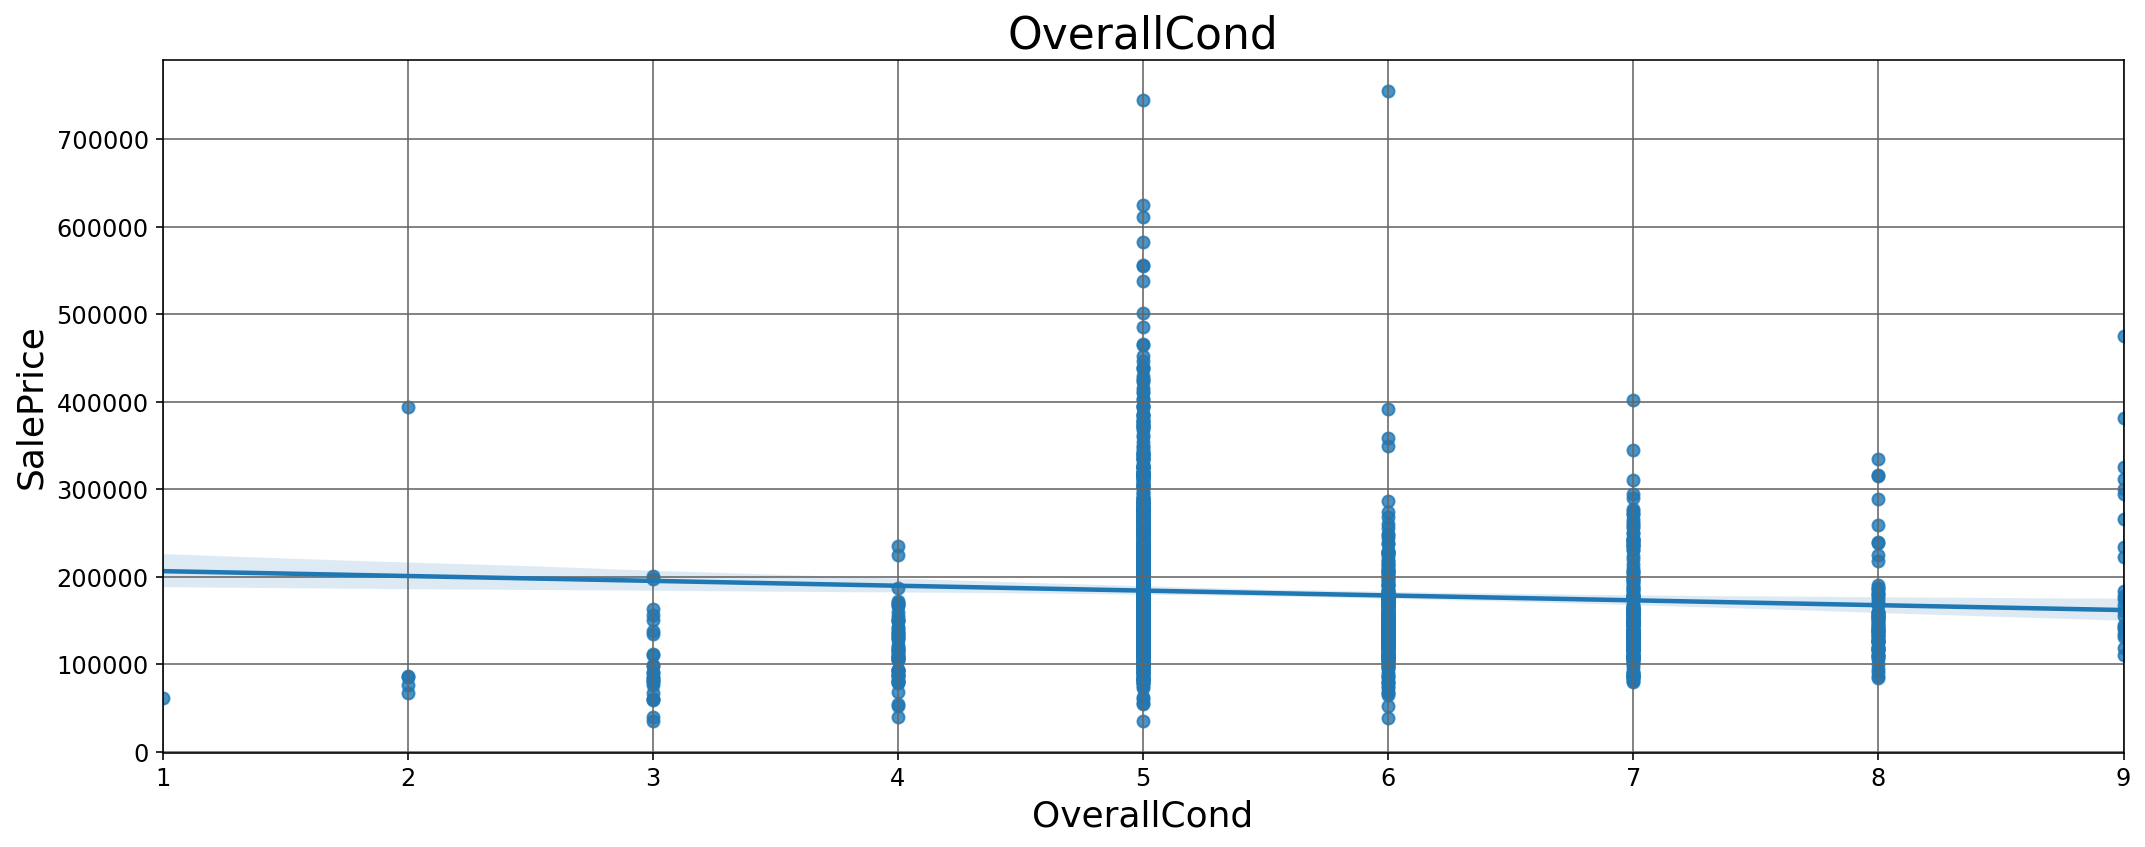

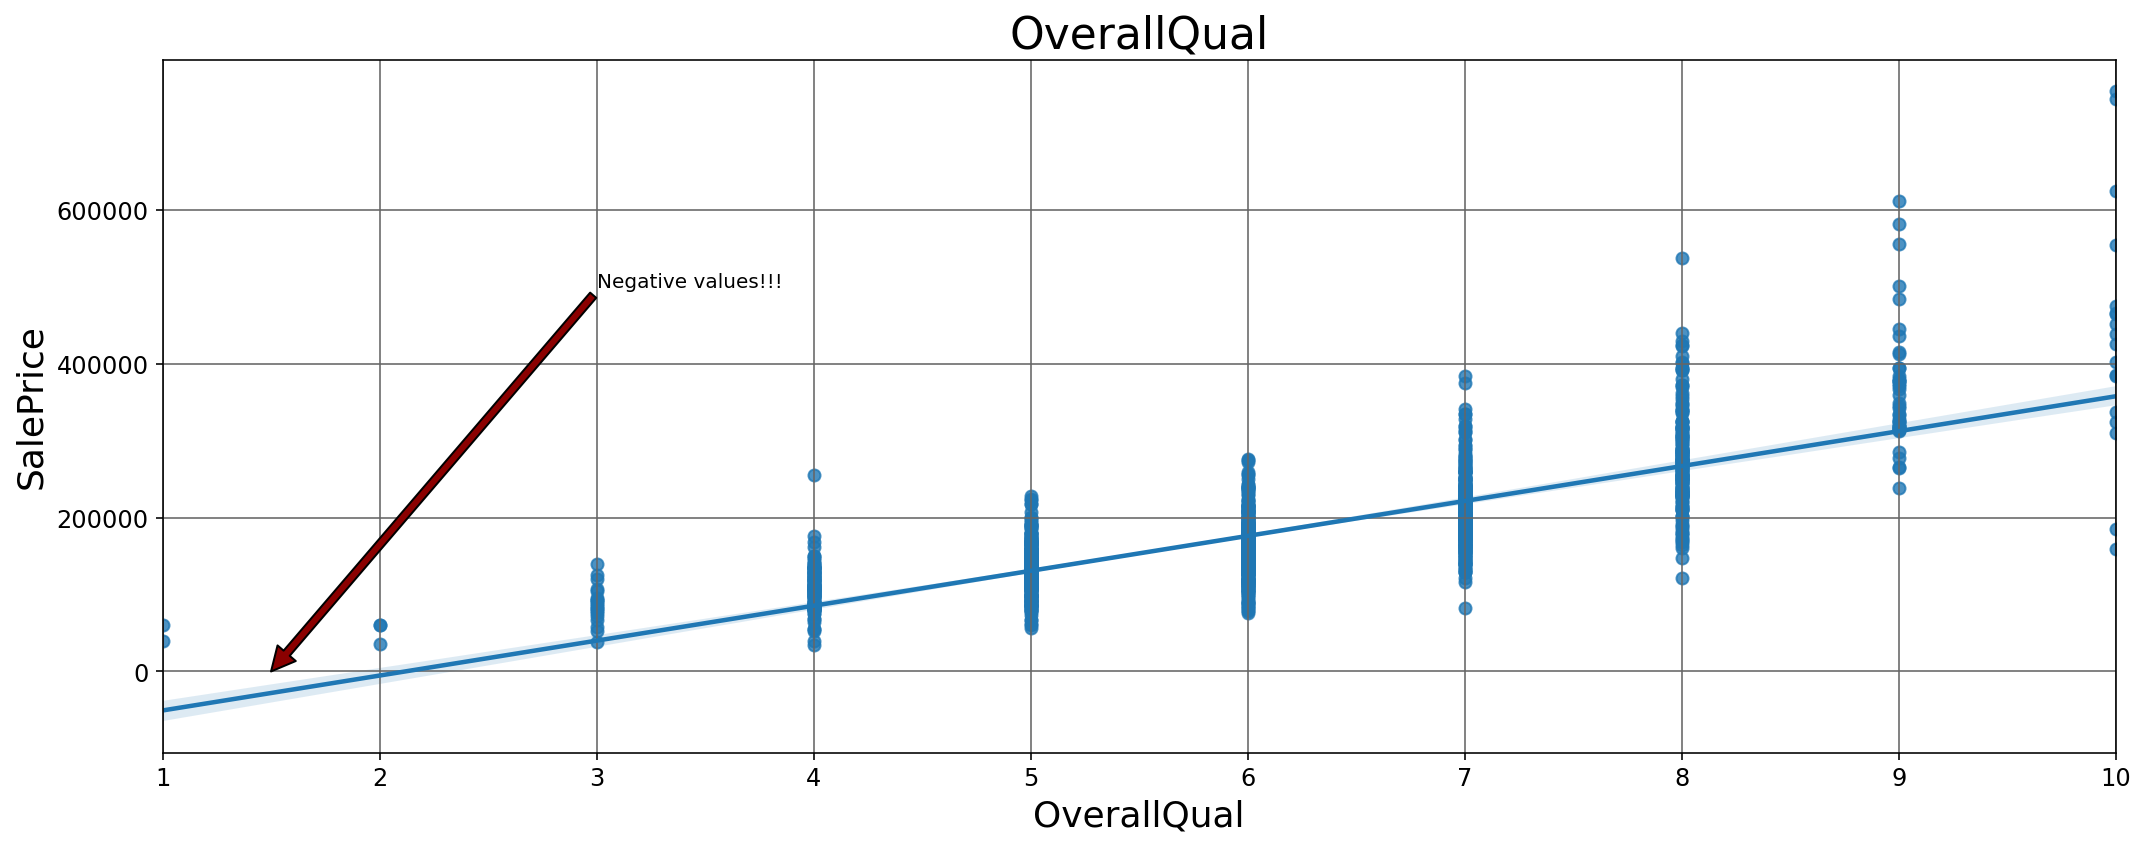

In [45]:
feature = "OverallCond"
plt.figure(figsize=(15, 6))
sns.regplot(x=feature, y='SalePrice', data=df)
plt.title(f'{feature}')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

feature = "OverallQual"
plt.figure(figsize=(15, 6))
ax = sns.regplot(x=feature, y='SalePrice', data=df)
ax.annotate("Negative values!!!", xy=(1.5, -1), xytext=(3, 500_000), arrowprops=dict(facecolor='darkred'))
plt.title(f'{feature}')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

We observe two things:

1. The model will predict negative SalePrice if OverallQual is 2 or less than 2.
2. OverallCond has negative trendline. The higher the condition the less is the predicted SalePrice.

Let's fix this

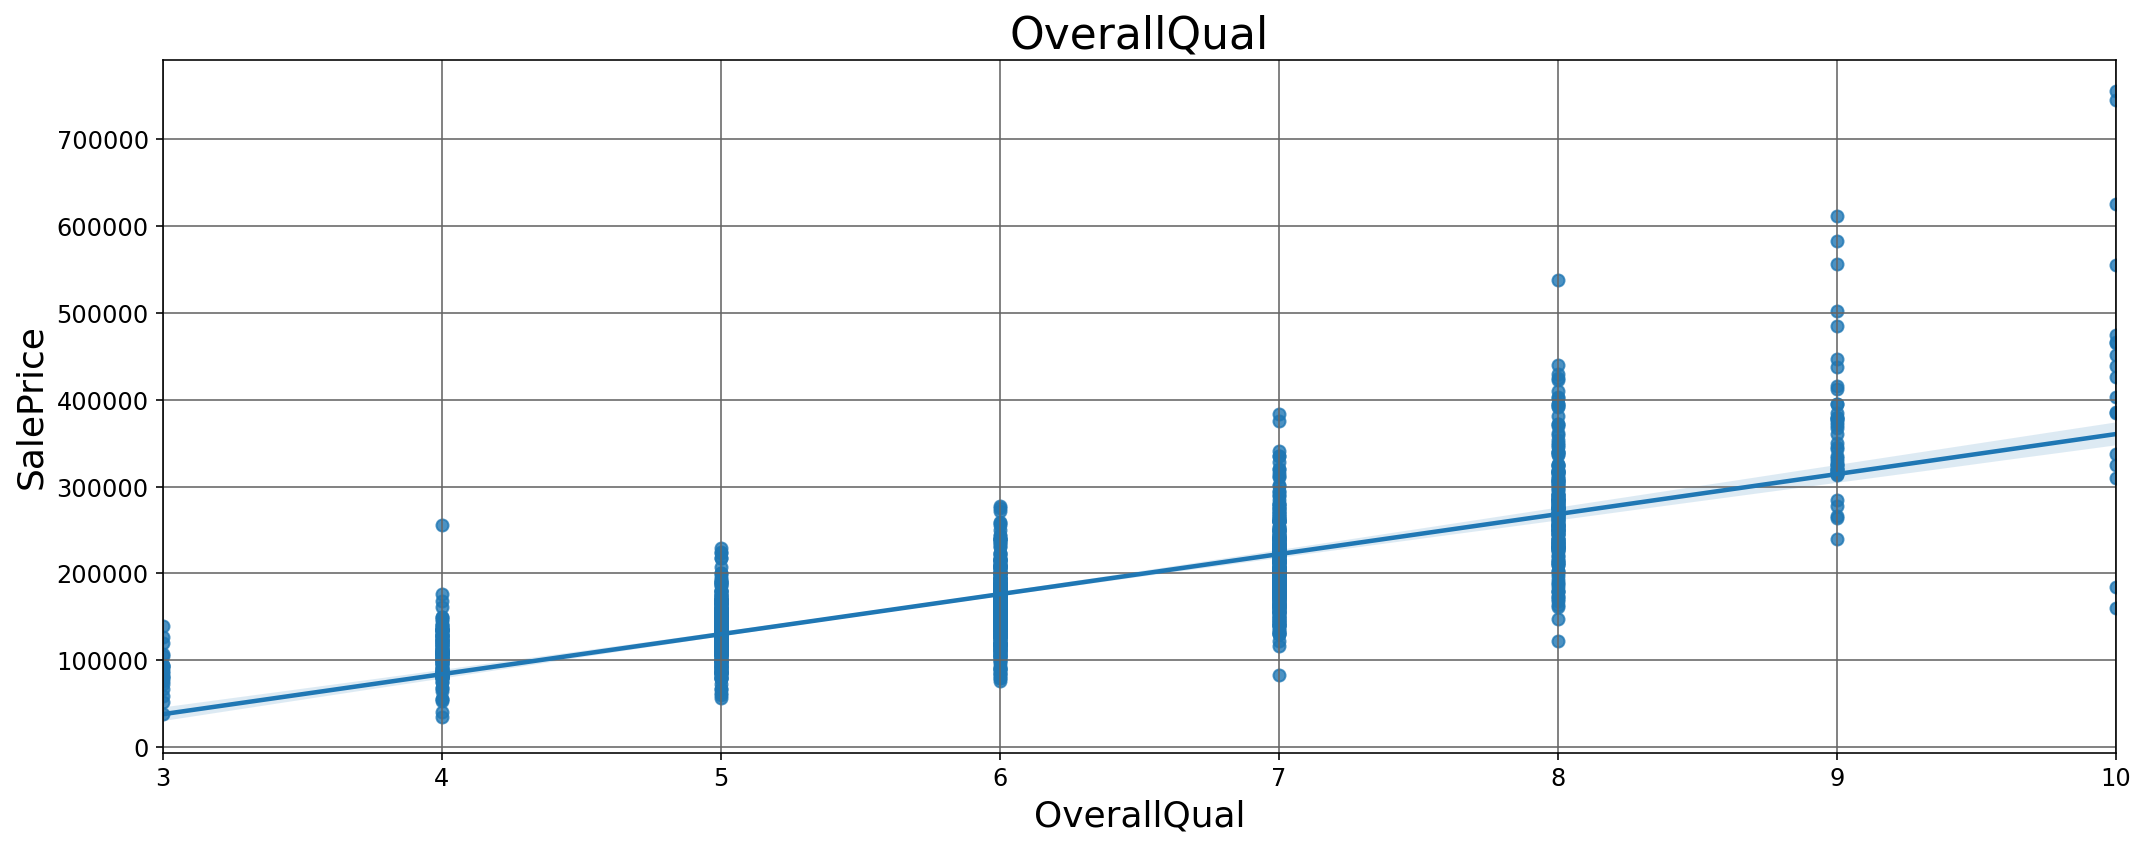

In [46]:
feature = "OverallQual"
plt.figure(figsize=(15, 6))
ax = sns.regplot(x=feature, y='SalePrice', data=df[df['OverallQual']>=3])
plt.title(f'{feature}')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

Problem fixed. **Take away: Visualizing the data is almost always superhelpful...**

Now we try again with our metric.

In [47]:
X = df[df.OverallQual >= 3][["OverallQual"]]
y = df[df.OverallQual >= 3].SalePrice
metric = 'neg_mean_squared_log_error'
clf = LinearRegression()
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
print(f"{np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean():.4f} Log Error")

0.2641 Log Error


Hilarious. Just one single categorical yields a not-so-bad result. And an even better one than what we got from continuous `GrLivArea`.

<font color="purple"> 
### 🤖 Experiment 02: Training with only categorical or numerical raw data

Let's see how far can we go with just numerical or categorical features

First we will try with categorical features

In [48]:
X = df.select_dtypes("object")
y= df.SalePrice
metric = 'neg_mean_squared_log_error'

# use make_pipeline to automatically fill the missing values and one hot encode
clf = make_pipeline(SimpleImputer(strategy='most_frequent', fill_value='missing'),
                    OneHotEncoder(handle_unknown="ignore"), LinearRegression())
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
print(f'{np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean():.4f} Log error')

0.2414 Log error


Progress! Let's try numerical features

In [49]:
# again fix OverallQual in order to not crash crossvalidation with our metric
df_fixed = df[df['OverallQual']>2]

X = df_fixed.select_dtypes("number").drop('SalePrice', axis=1)
y = df_fixed.SalePrice
metric = 'neg_mean_squared_log_error'
clf = make_pipeline(SimpleImputer(), StandardScaler(), LinearRegression())
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
print(f'{np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean():.4f} Log error')

0.1801 Log error


Even more progress!!!

<font color="purple"> 
### 🤖 Experiment 03: Un-sk(r)ew the distribution of SalePrice

How about log transforming the skewed distribution of `SalePrice`? Will we get a better score?

In [50]:
X = df.select_dtypes("number").drop(["SalePrice"], axis=1)

# log transform SalePrice to fix skewed distribution
# we also now can skip removing the samples with OverallQual < 3
y = np.log1p(df.SalePrice)
metric = 'neg_mean_squared_error'

clf = make_pipeline(SimpleImputer(), StandardScaler(), LinearRegression())
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
print(f"{np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean():.4f} Log Error")

0.1534 Log Error


Oh yes. Great step forward. Just **log transforming y gets us to rank #3000.** 

<font color="purple"> 
### 🤖 Experiment 04: Finally using cleaned data and trying other classifiers

How about our **cleaned data** and **some other classifiers**?

In [51]:
classifiers=[Ridge(),
             Lasso(),
             ElasticNet(),
             KernelRidge(),
             SVR(),
             RandomForestRegressor(),
             GradientBoostingRegressor(),
             lgb.LGBMRegressor(),
             xgb.XGBRegressor(objective='reg:squarederror'),
             ]

clf_names = ["ridge",
             "lasso",
             "elastic",
             "kernelrdg",
             "svr",
             "rndmforest",
             "gbm",
             "lgb",
             "xgboost",
             ]

In [52]:
X = dtrain.drop(["SalePrice"], axis=1)
y = np.log1p(dtrain.SalePrice)
metric = 'neg_mean_squared_error'

for clf_name, clf in zip(clf_names, classifiers):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    print(f"{clf_name} {np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean():.4f}")


ridge 0.0090
lasso 0.0156
elastic 0.0155
kernelrdg 0.0091
svr 0.0331
rndmforest 0.0103
gbm 0.0092
lgb 0.0097
xgboost 0.0093


We are definitely on track. **Scores of less than 0.13 (GBM, XGBoost) should pull us close toward a rank in the top third of the leaderboard.**

<font color="purple"> 
### 🤖 Experiment 05: Removing the outliers we were warned about...

In [53]:
X = dtrain[dtrain.GrLivArea < 4000].drop(["SalePrice"], axis=1)
y = np.log1p(dtrain[dtrain.GrLivArea < 4000].SalePrice)
metric = 'neg_mean_squared_error'

for clf_name, clf in zip(clf_names, classifiers):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    print(f"{clf_name} {np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean():.4f}")

ridge 0.0092
lasso 0.0156
elastic 0.0155
kernelrdg 0.0093
svr 0.0327
rndmforest 0.0102
gbm 0.0095
lgb 0.0098
xgboost 0.0094


<font color="purple"> 
### 🤖 Experiment 06: Use PCA to reduce collinearity?

Fellow Kaggler [massquantity suggests here](https://www.kaggle.com/massquantity/all-you-need-is-pca-lb-0-11421-top-4#Ensemble-Methods) that we can reduce the collinearity that we have in the data and even might have increased with feature engineering by applying PCA to the whole data set. I think it's a cool idea worth persuing. 

Let's try to quickly validate this with our data (which is significantly different from his in terms of feature cleaning and engineering).

In [54]:
X = dtrain[dtrain.GrLivArea < 4000].drop(["SalePrice"], axis=1)
# we carefully reduce dimensionality from 271 features to 250 dimensions
pca = PCA(n_components=250)
X_pca = pca.fit_transform(X)
y = np.log1p(dtrain[dtrain.GrLivArea < 4000].SalePrice)
metric = 'neg_mean_squared_error'

for clf_name, clf in zip(clf_names, classifiers):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    print(f"{clf_name} {np.sqrt(-cross_val_score(clf, X_pca, y, cv=kfold, scoring=metric)).mean():.4f}")

ridge 0.0092
lasso 0.0157
elastic 0.0155
kernelrdg 3.4481
svr 0.0329
rndmforest 0.0133
gbm 0.0111
lgb 0.0117
xgboost 0.0117


So at first glance this doesn't work here. 

<font color="purple"> 
### 🤖 Experiment 07: Use boxcox transform numerical features to improve score?

Several [Kagglers](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard) **apply a [box cox transformation](http://onlinestatbook.com/2/transformations/box-cox.html) to skewed numerical features**. Cool idea worth persuing too. 

Let's quickly validate this with our data.

In [55]:
X = dtrain[dtrain['GrLivArea']<4000].drop('SalePrice', axis=1)
sk = pd.DataFrame(X.iloc[ : ,:60].skew(), columns=['skewness'])
sk = sk[sk['skewness'] > .75]
for feature in sk.index:
    X[feature] = boxcox1p(X[feature], 0.15)
y = np.log1p(dtrain[dtrain['GrLivArea']<4000].SalePrice)
metric = 'neg_mean_squared_error'

for clf_name, clf in zip(clf_names, classifiers):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    print(f"{clf_name} {np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean():.4f}")

ridge 0.0091
lasso 0.0156
elastic 0.0155
kernelrdg 0.0092
svr 0.0327
rndmforest 0.0103
gbm 0.0095
lgb 0.0098
xgboost 0.0094


The box cox transformation seems to improve our models only slightly and only for some of the classifiers. 

Also I have to learn about how t=boxcox theory works.

<font color="purple"> 
### 🤖 Experiment 08: Which features do the classifiers pick up?

What features are relevant for the classifiers? Was feature engineering worth our while?

We'll get the feature importance of XGBoost as an example.

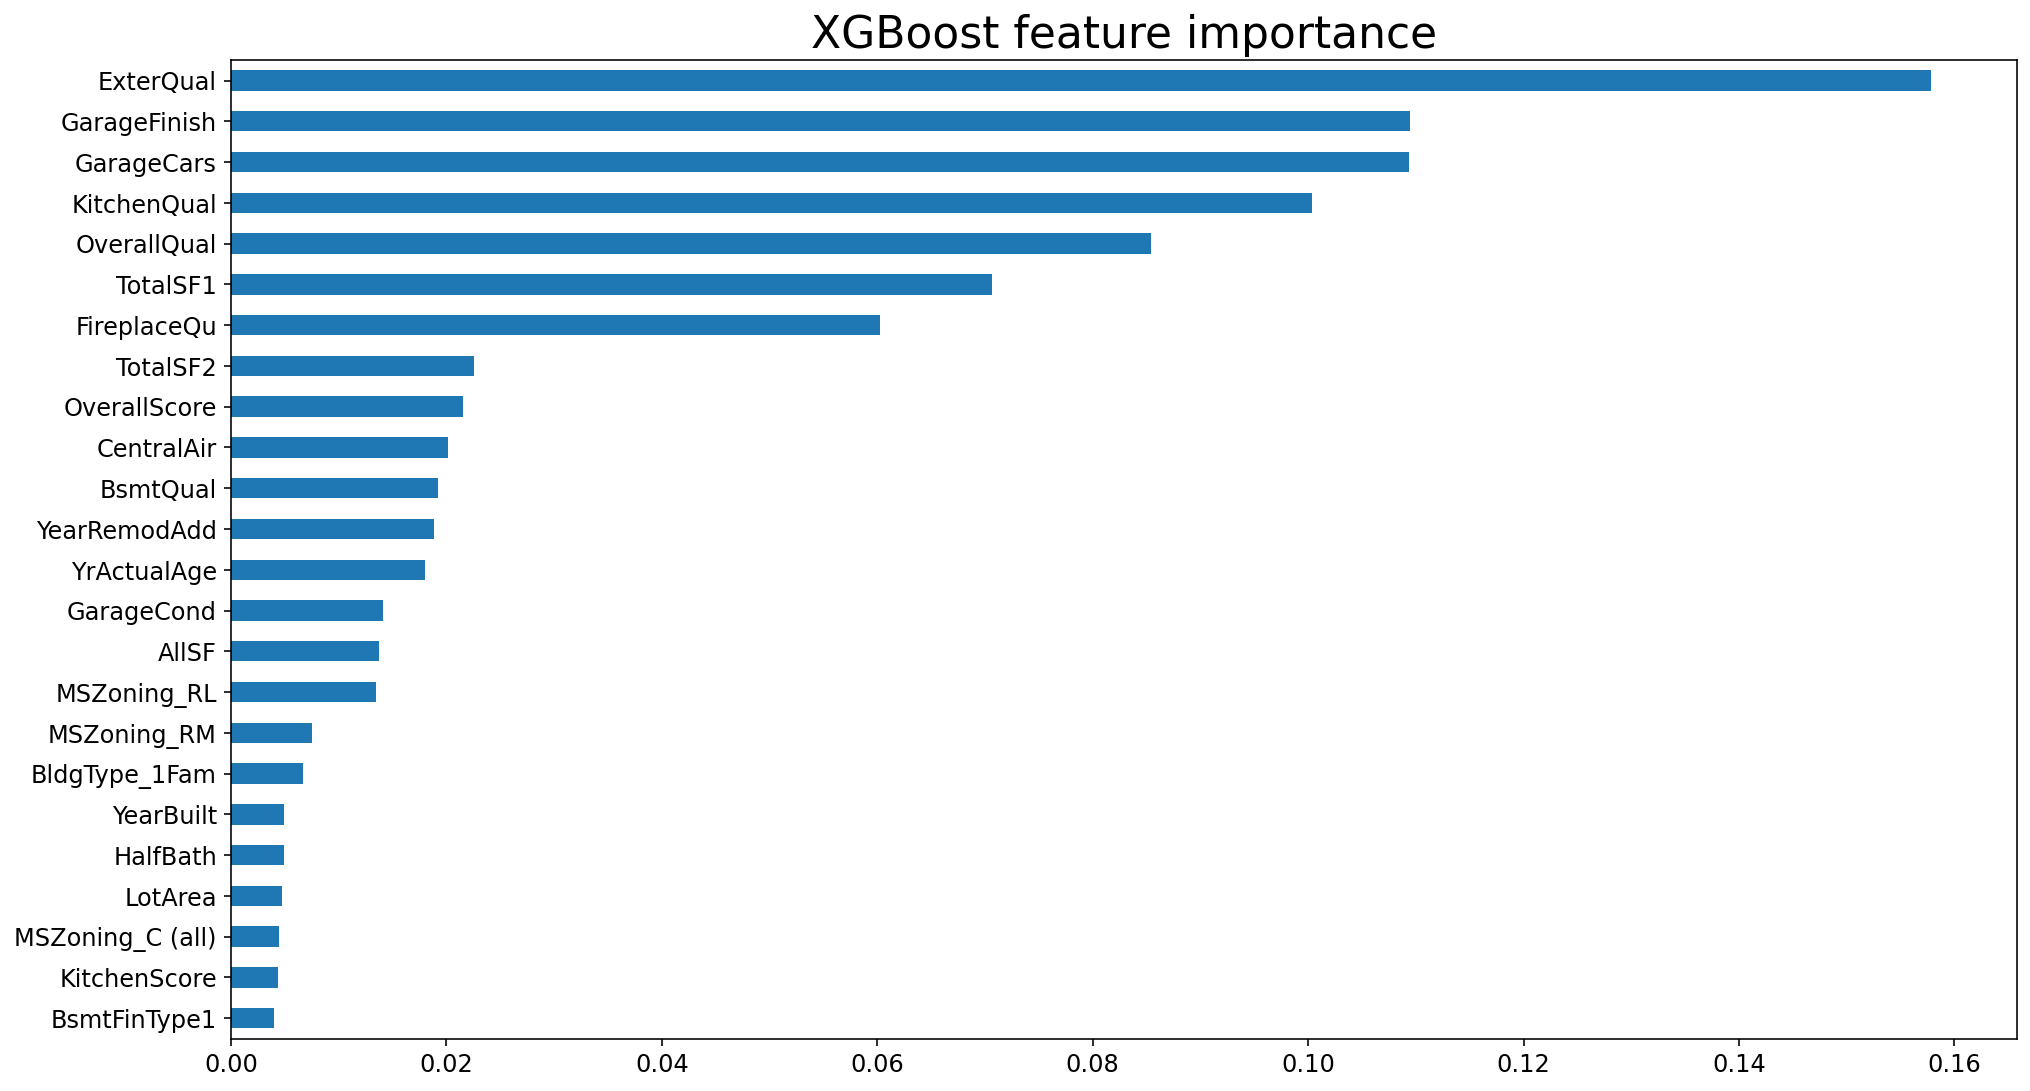

In [56]:
X = dtrain[dtrain.GrLivArea < 4000].drop(["SalePrice"], axis=1).copy()
y = np.log1p(dtrain[dtrain.GrLivArea < 4000].SalePrice)

# again we apply the boxcox transformation
sk = pd.DataFrame(X.iloc[:, :60].skew(), columns=["skewness"])
sk = sk[sk.skewness > .75]
for feature_ in sk.index:
    X[feature_] = boxcox1p(X[feature_], 0.15)

clf = xgb.XGBRegressor(objective="reg:squarederror", n_jobs=-1)
coeffs = clf.fit(X, y).feature_importances_
df_co = pd.DataFrame(coeffs, columns=["importance_"])
df_co.index = X.columns
df_co.sort_values("importance_", ascending=True, inplace=True)

plt.figure(figsize=(16,9))
df_co.iloc[230:, :].importance_.plot(kind="barh")
plt.title(f"XGBoost feature importance")
plt.show()

Top correlated features like GarageCars, OverallQual are still very informative to the algorithm. Some of our engineered features like `TotalSF(1,2)`, `TotalBath` and `OverallScore` rank very high too. 

It seems that feature engineering was effective, at least inasmuch some created featured rank among the relevant ones.

<font color="purple"> 
### 🤖 Experiment 09: Do our predictions actually make any sense at all?

Now we'll look at the predictions in detail.

In [57]:
# use only the most promising classifiers
classifiers = [
               Ridge(), 
               Lasso(), 
               ElasticNet(),
               KernelRidge(),
               GradientBoostingRegressor(),
               lgb.LGBMRegressor(),
               xgb.XGBRegressor(objective="reg:squarederror"),
]

clf_names = [
            "ridge      ",
            "lasso      ",
            "elastic    ",
            "kernlrdg   ",
            "gbm        ", 
            "lgbm       ", 
            "xgboost    ",
]

In [58]:
X = dtrain[dtrain.GrLivArea < 4000].drop(["SalePrice"], axis=1).copy()
y = dtrain[dtrain.GrLivArea < 4000].SalePrice
X_test = dtest.copy()

sk = pd.DataFrame(X.iloc[:, :60].skew(), columns=["skewness"])
sk = sk[sk.skewness > .75]
for feature_ in sk.index:
    X[feature_] = boxcox1p(X[feature_], 0.15)
    X_test[feature_] = boxcox1p(X_test[feature_], 0.15)

In [59]:
predictions = []

for clf_name, clf in zip(clf_names, classifiers):
    clf.fit(X, y)
    preds = clf.predict(X_test)
    # reverse log transform predicted sale prices with np.expm1()
    predictions.append(np.expm1(preds))

We again have a look at the basic statistics of sales prices in our training data in order to compare these to stats of predicted values. 

In [60]:
df.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

We have a mean of 180k, a minimum of around 35k and a maximum sale price of 755k.

Let's compare this to the predicted values.

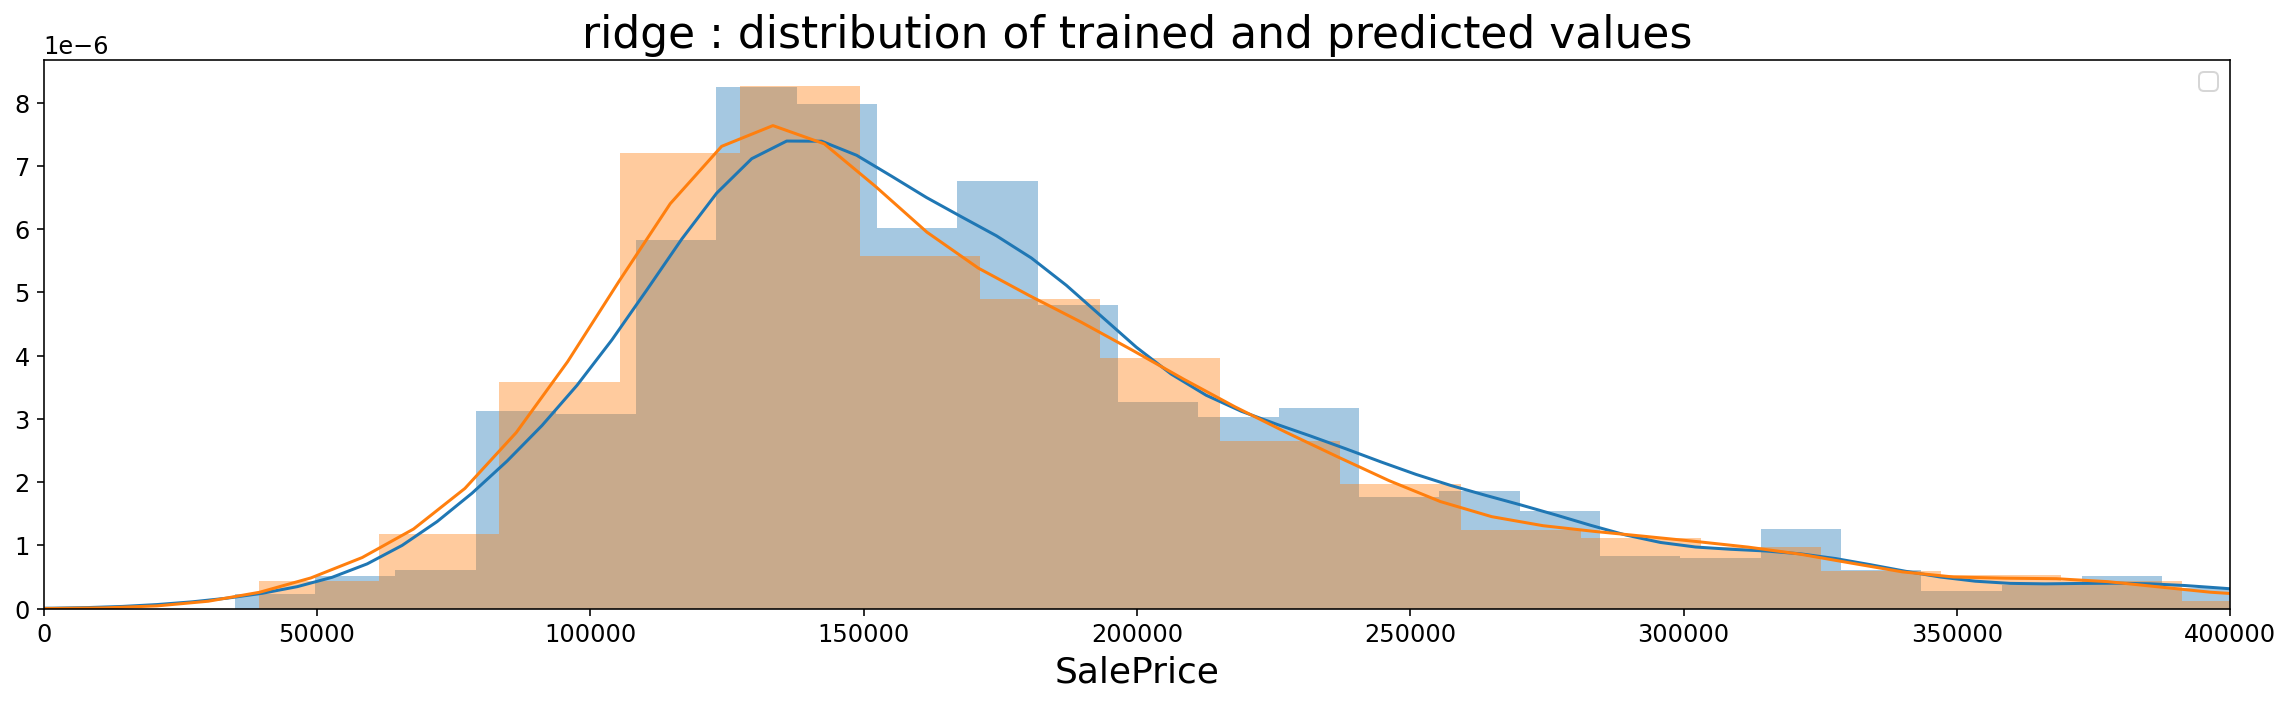

ridge minimum value predicted : 39387
ridge maximum value predicted : 1138560



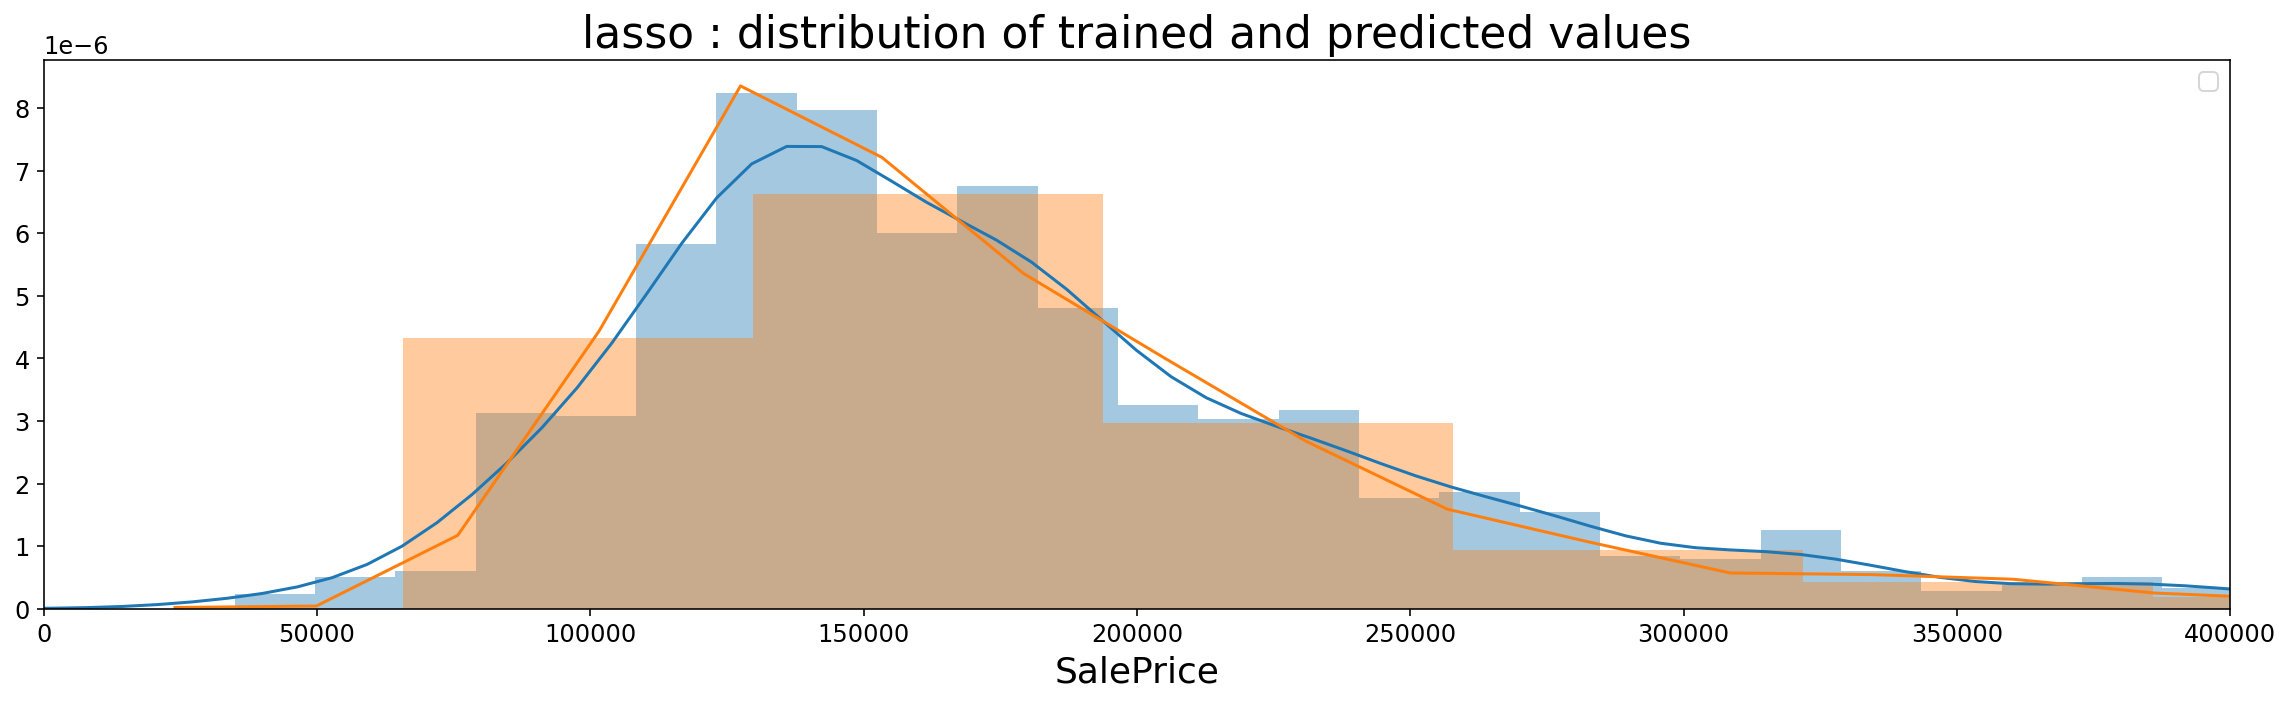

lasso minimum value predicted : 65791
lasso maximum value predicted : 3267326



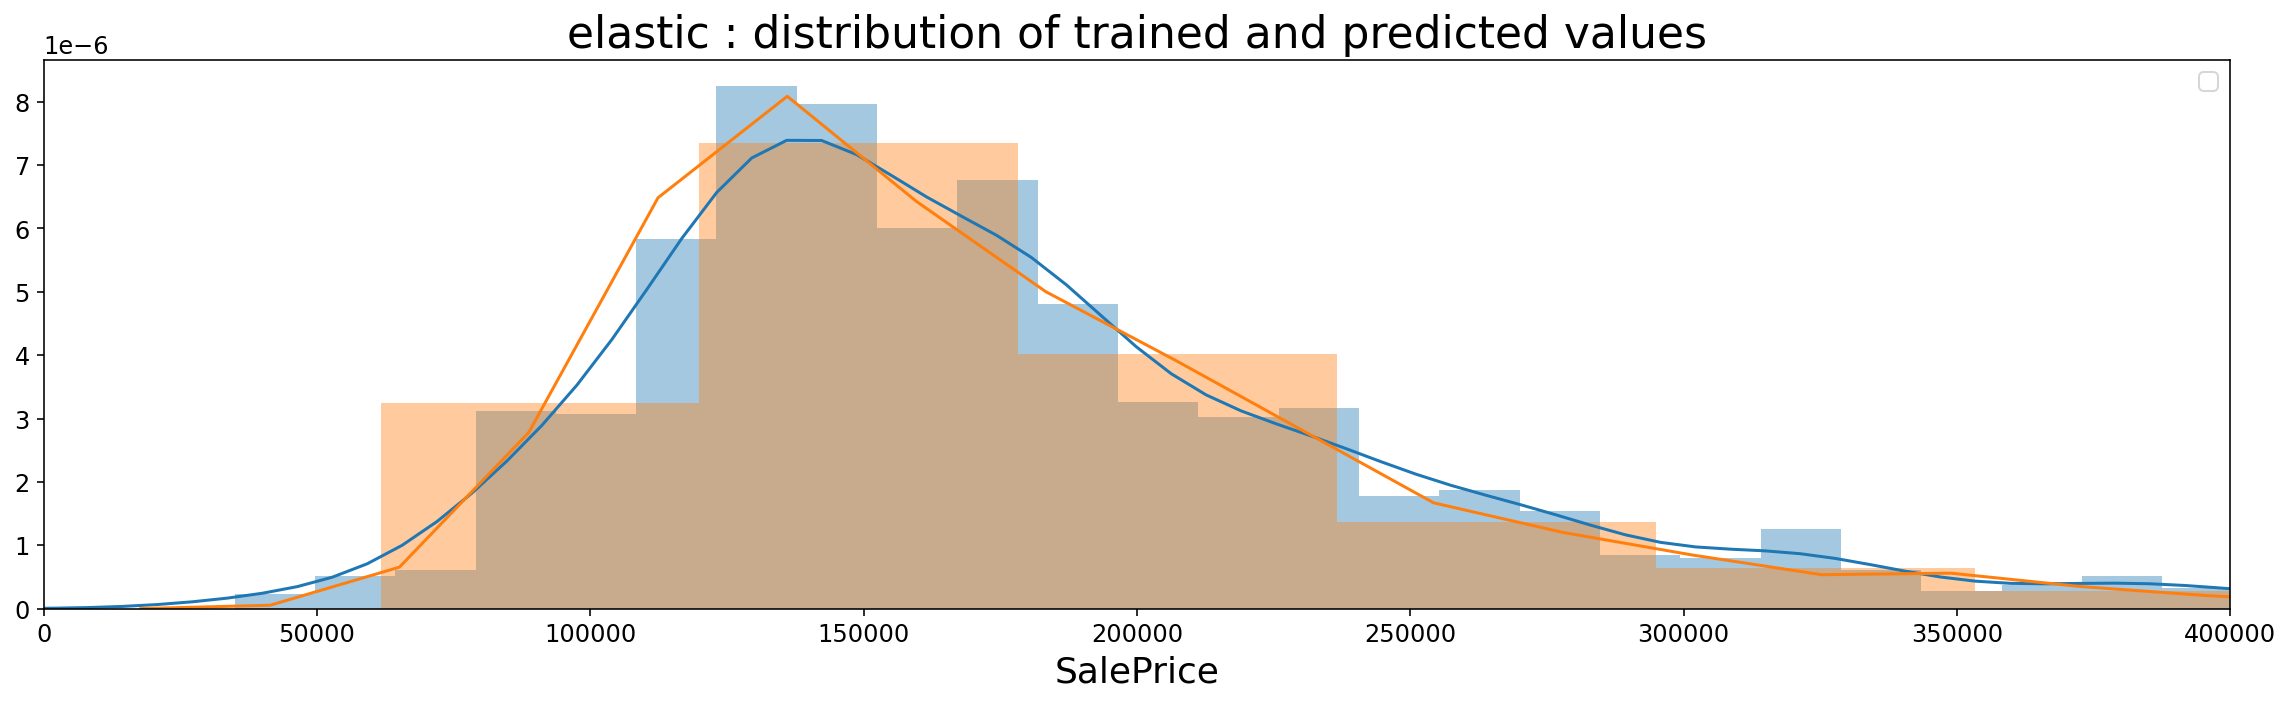

elastic minimum value predicted : 61641
elastic maximum value predicted : 2977851



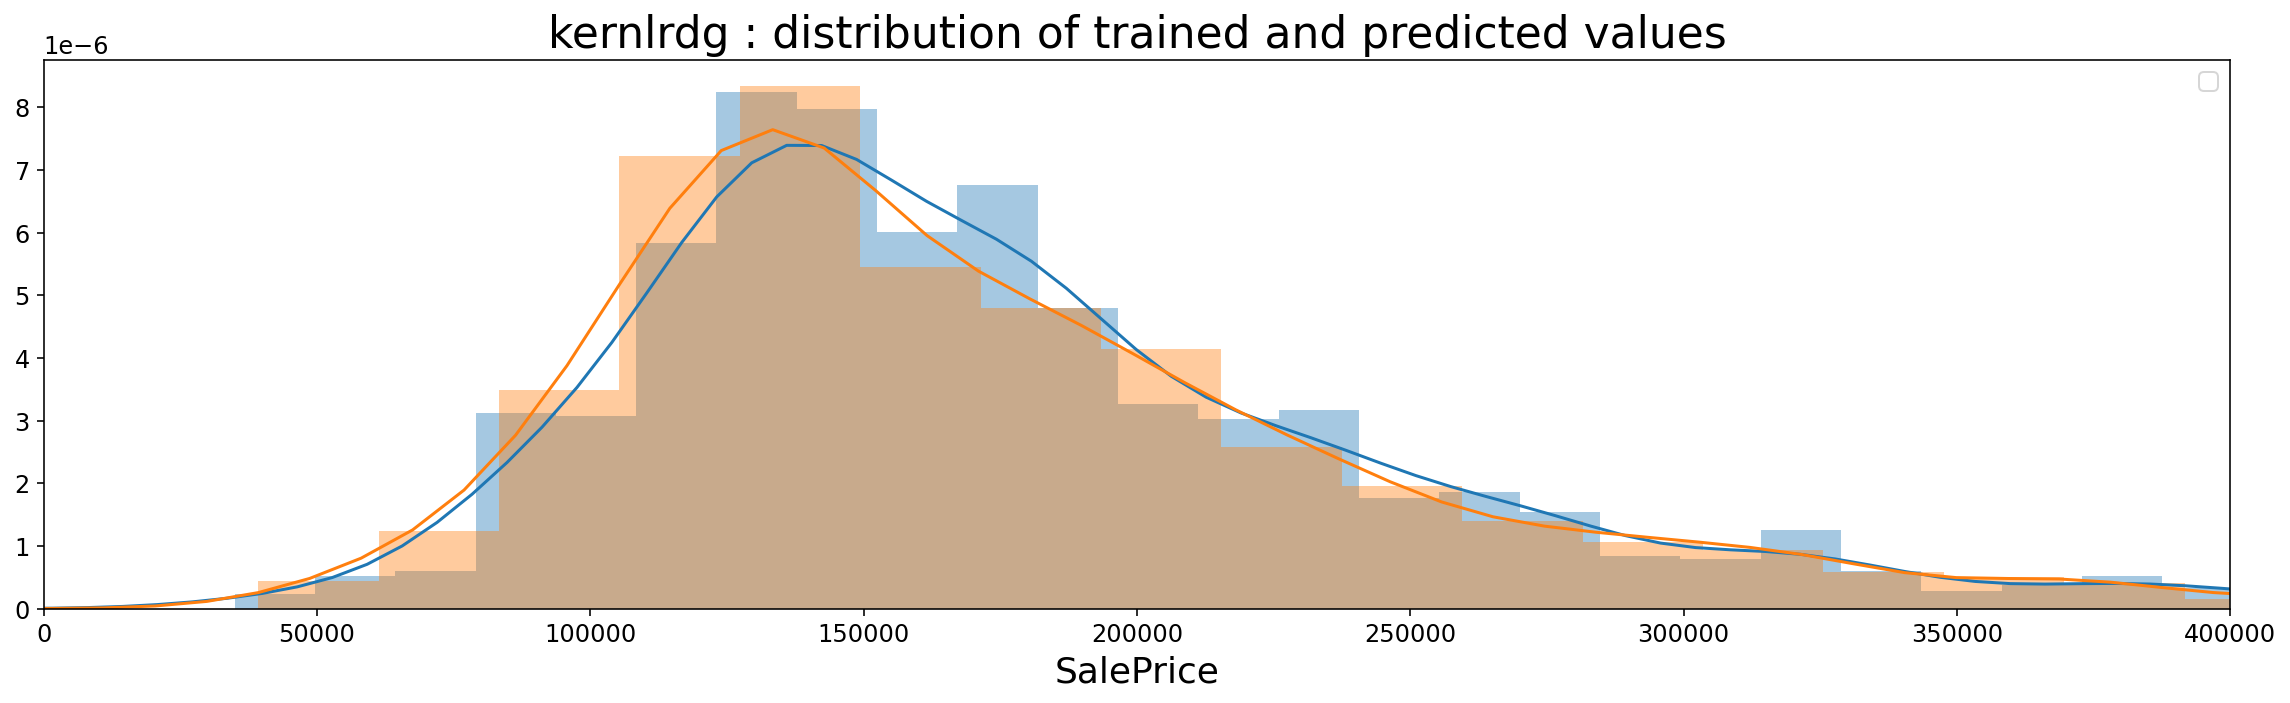

kernlrdg minimum value predicted : 39219
kernlrdg maximum value predicted : 1140627



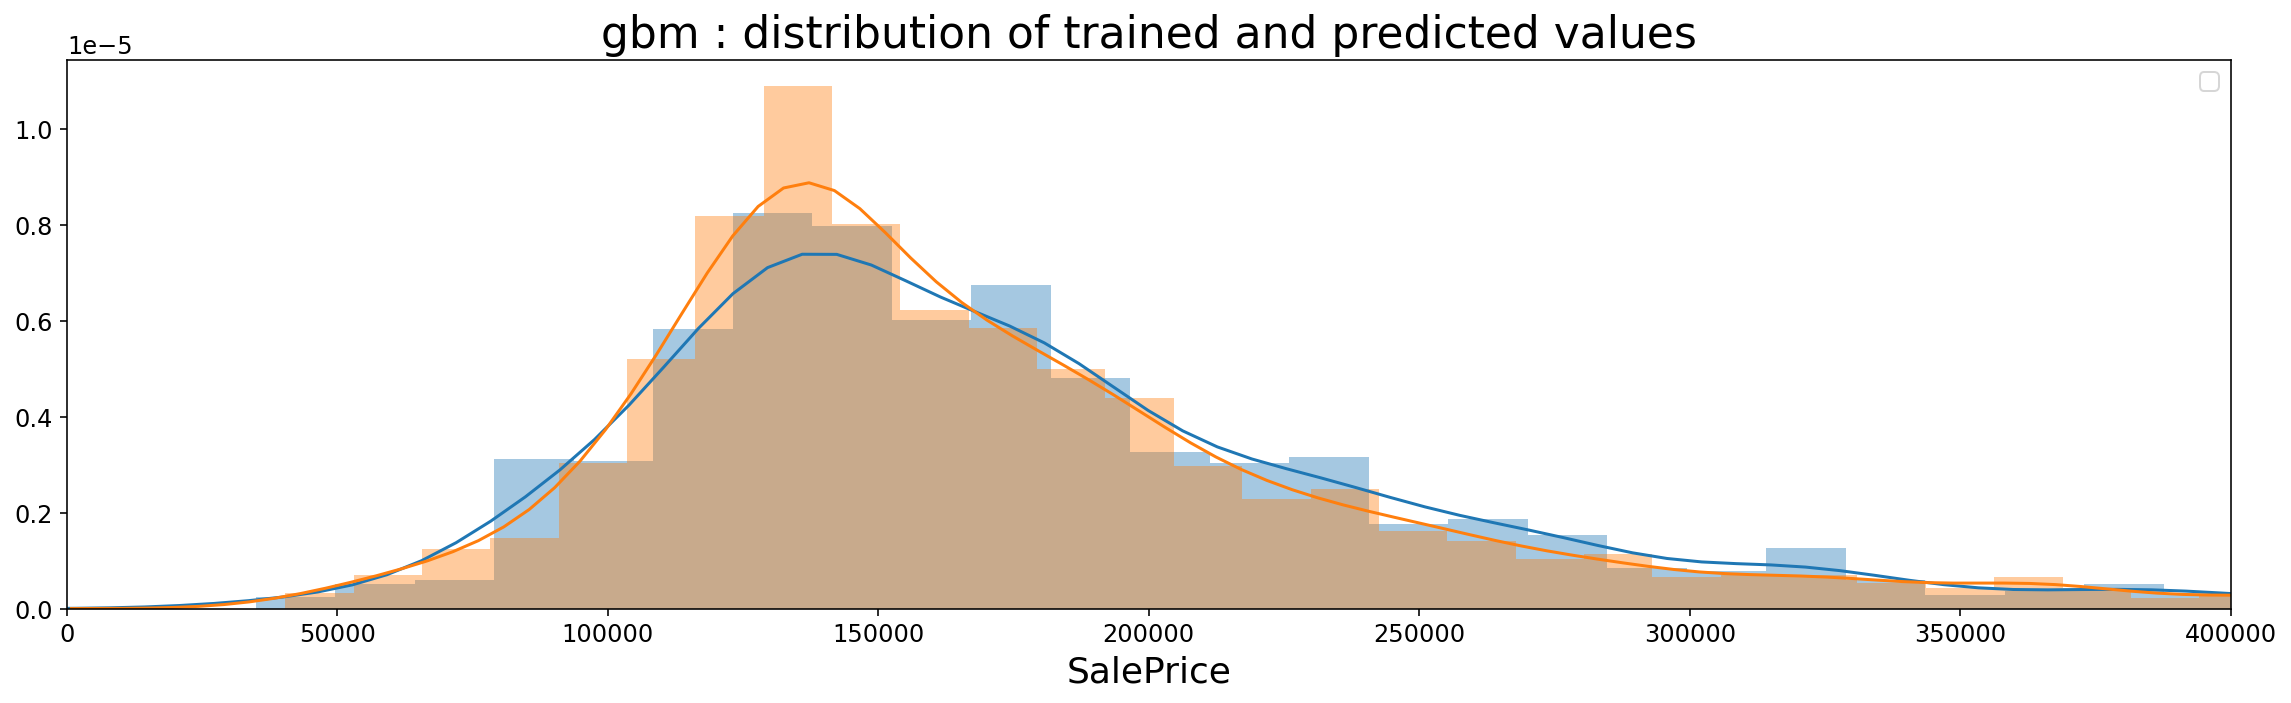

gbm minimum value predicted : 40347
gbm maximum value predicted : 558469



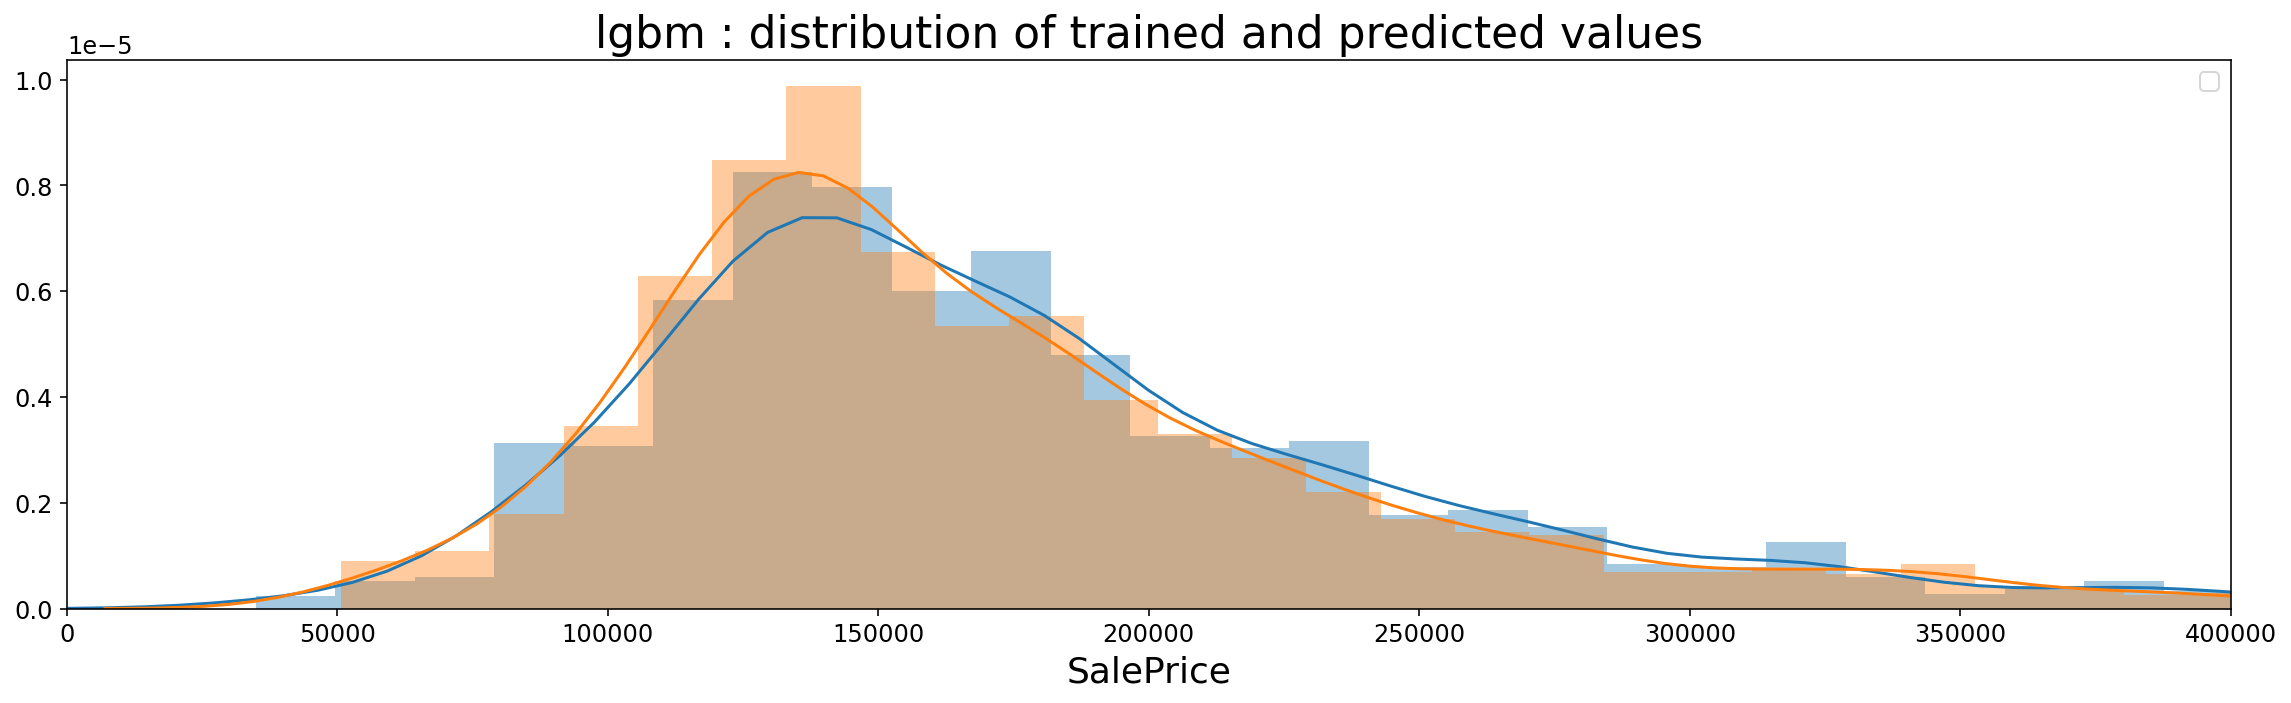

lgbm minimum value predicted : 50602
lgbm maximum value predicted : 545002



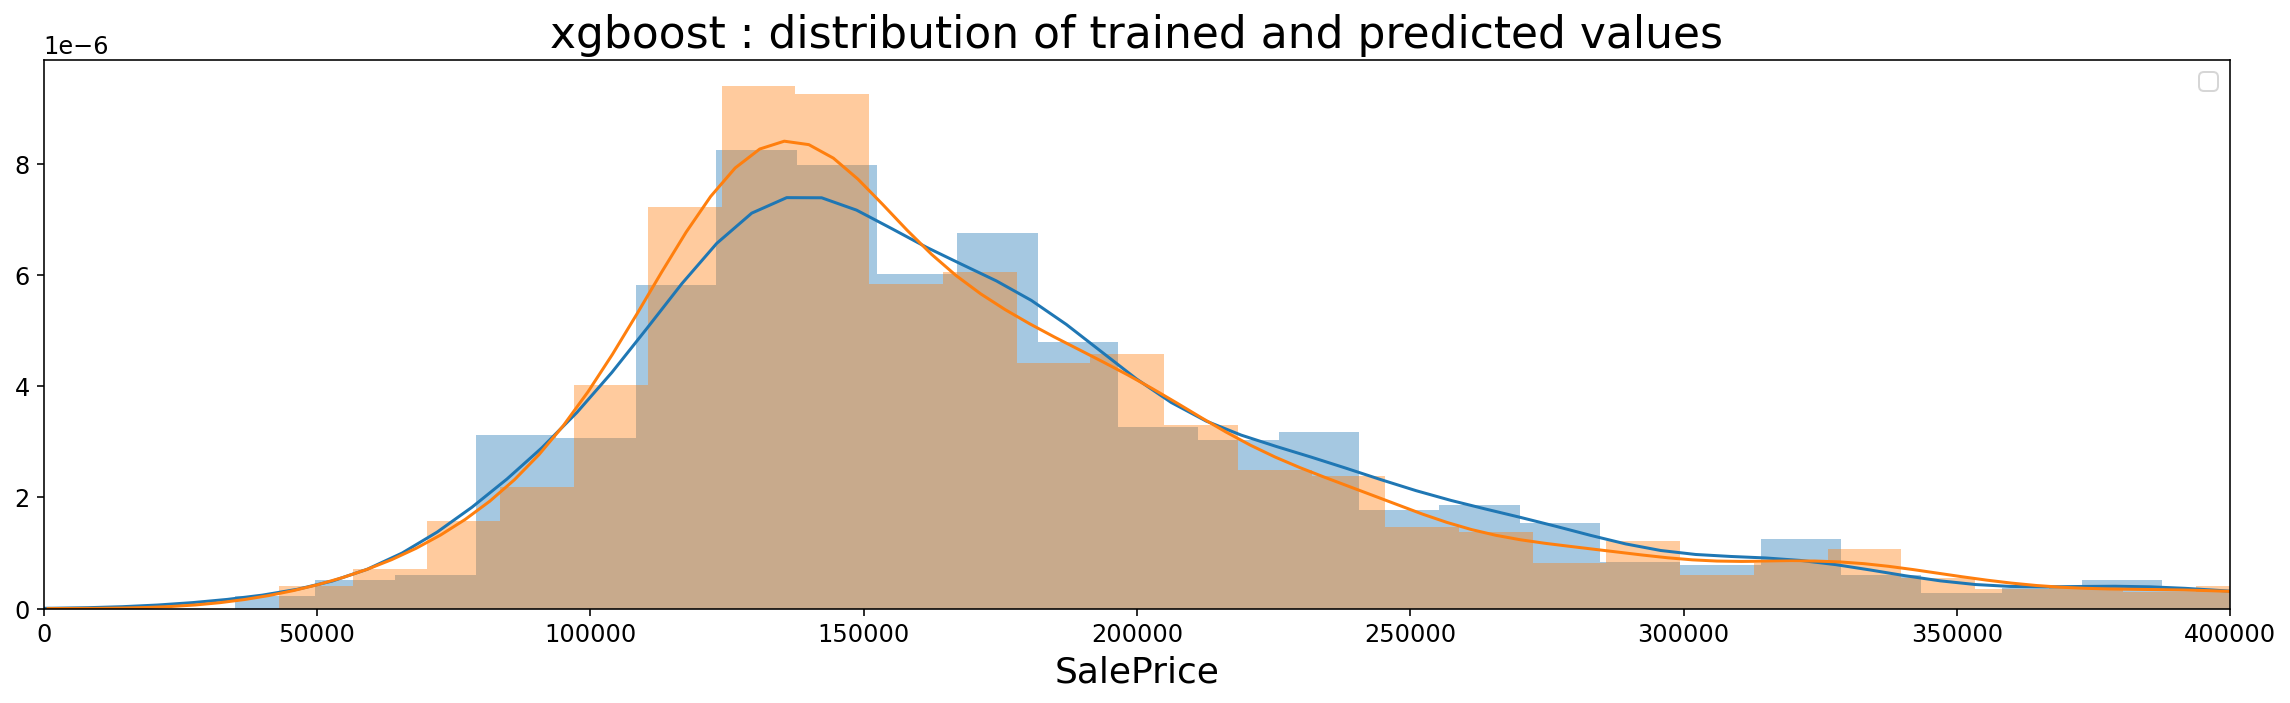

xgboost minimum value predicted : 43091
xgboost maximum value predicted : 528709



In [61]:
for idx, clf_name in zip(range(0, 7), clf_names):
    plt.figure(figsize=(16,5))
    p = pd.DataFrame(predictions[idx], columns=['preds'])
    sns.distplot(df.SalePrice)
    sns.distplot(p)
    plt.legend('Sale prices : trained', 'Sale prices : predicted')
    plt.xlim(0, 400_000)
    plt.title(f'{clf_name.strip()} : distribution of trained and predicted values')
    plt.tight_layout()
    plt.show()
    print(f'{clf_name.strip()} minimum value predicted : {p.min()[0]:.0f}')
    print(f'{clf_name.strip()} maximum value predicted : {p.max()[0]:.0f}')
    print("")


**Ridge, Lasso, ElasticNet and KernelRidge predict a maximum value of way more than 1 million USD** which doesn't seem right at all. 

Let's see where the outlier(s) come from.

In [62]:
for idx, clf_name in enumerate(clf_names):
    p = pd.DataFrame(predictions[idx])
    # filter all values beyond max sale price in training data
    p_out = p[p[0] > 755_000].astype(int) 
    if len(p_out) > 0:
        p_out.columns = [f"{clf_name.strip().capitalize()} _ predicted SalePrice"]
        display(p_out)

Ridge _ predicted SalePrice
1089                      1138560

Lasso _ predicted SalePrice
1089                      3267326

Elastic _ predicted SalePrice
1089                        2977851

Kernlrdg _ predicted SalePrice
1089                         1140627

So there is one single observation in the test data with the index 1089, that very likely can't accurately be predicted by the linear classifiers. 

I have looked at the features and **found a possible error in the test data: The house was sold BEFORE it was built...** 😃

In [63]:
dtest.loc[1089][["YearBuilt", "YrSold", "YrActualAge"]]

YearBuilt      2008
YrSold         2007
YrActualAge      -1
Name: 1089, dtype: int64

So we should either cap the prediction for that observations to reasonable maximum or correct the erroneous feature in the test set.

<font color="purple"> 
### 🤖 Experiment 10: How do we pick the most diverse set of models for an ensemble?

The more different the models that we choose for an ensemble the better it'll perform. We'll set up a correlation matrix and examine the correlations with a heatmap.

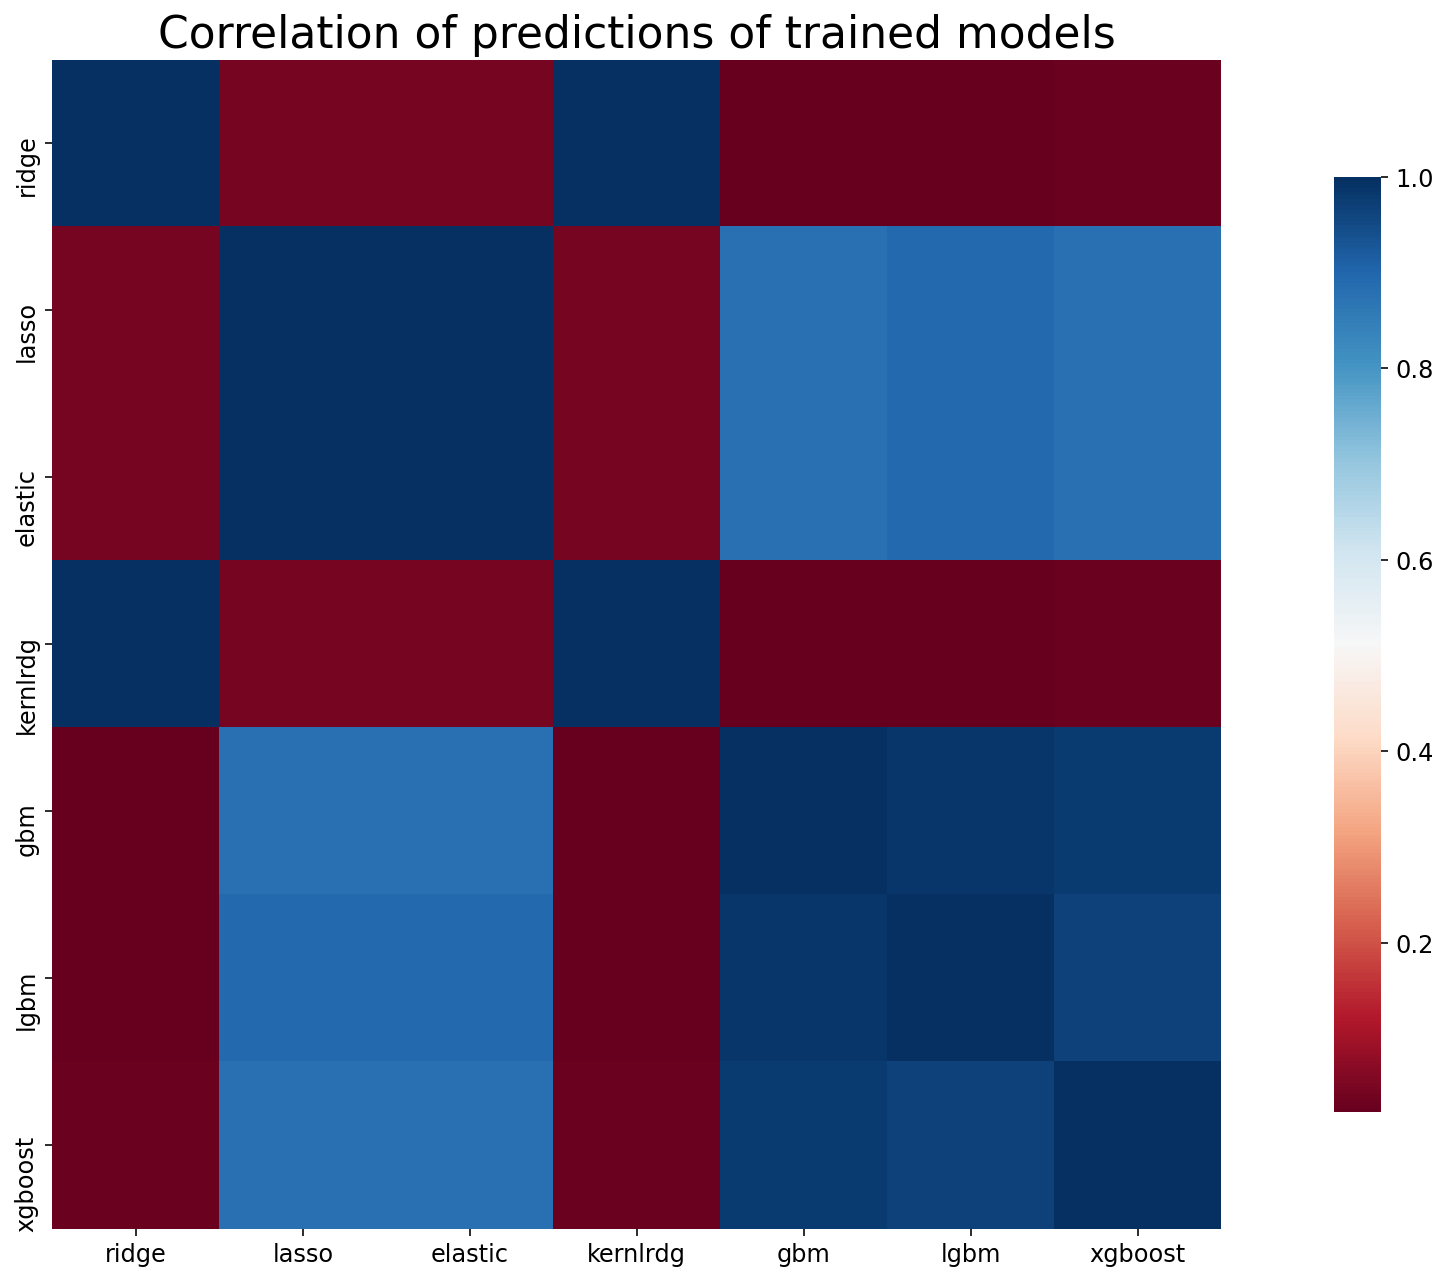

In [67]:

sk = pd.DataFrame(X.iloc[:, :60].skew(), columns=["skewness"])
sk = sk[sk.skewness > .75]
for feature_ in sk.index:
    X[feature_] = boxcox1p(X[feature_], 0.15)

y = np.log1p(dtrain[dtrain.GrLivArea < 4000].SalePrice)
metric = 'neg_mean_squared_error'

predictions = []
# create an array for stats, set stats of training set as first column
pred_stats = [df.SalePrice.describe()]

for clf_name, clf in zip(clf_names, classifiers):
    clf.fit(X, y)
    preds = clf.predict(X_test)
    # reverse log transform predicted sale prices with np.expm1()
    predictions.append(np.expm1(preds))
    pred_stats.append(pd.DataFrame(np.expm1(preds)).describe())

# calculate correlations of predicted values between each of the models
pr_corr = pd.DataFrame(predictions).T.corr()
pr_corr.columns = [x.strip() for x in clf_names]
pr_corr.index = [x.strip() for x in clf_names]
plt.figure(figsize=(16,9))
sns.heatmap(pr_corr, cmap="RdBu", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation of predictions of trained models")
plt.tight_layout()
plt.show()

- The pure linear models Ridge, Lasso and ElasticNet are highly correlated. 
- The other obvious group seems to GBM, LightGBM and XGBoost. 
- KernelRidge sticks out in itself.

### 😎 Conclusions from experiments...


- We get **astonishingly decent results from training on raw data and single features only.**
- We get **decent results too, if we just train on either raw numerical or categorical data.**
- We **achieved *some* improvement by data cleaning and feature engineering, but not that much.** Does that change if we tune hyperparameters? 
- **Log transforming SalePrice is very effective as well as box cox transforming several other skewed features.**
- **Removing the outliers beyond 4000 square feet in `GrLivArea` is super effective too.**
- Looking closely at predictions is valuable. We found a hefty outlier that we need to fix before submission.
- We have identified the differences in our trained models which will help us building an ensemble.
- Applying PCA didn't help in any way to reduce possible collinearity.

Promising scores from 
- Ridge 
- Lasso
- ElasticNet
- KernelRidge
- GBM
- LightGBM
- XGBoost 

LinearRegression, Support Vector and Random Forest Regression do not seem to work well on the engineered data. There might be too much collinearity in the expanded features or in the data set in general.

</span>

## 5. Hypertuning the engines

![](https://images.pexels.com/photos/3076820/pexels-photo-3076820.jpeg?cs=srgb&dl=pexels-tim-mossholder-3076820.jpg)

> Skip ahead to the next chapter (6.) if you don't want to find **new** parameters.

For each of the promising classifiers we now try to find optimal hyperparameters with a search grid and sklearn's `GridSearchCV()`. (*commented out to allow for faster execution of whole kernel*)

As a starting point I looked into several of the kernels that I already have mentioned and tuned based on their findings.


In [ ]:
# X = dtrain[dtrain.GrLivArea < 4000].drop(["SalePrice"], axis=1)
# y = np.log1p(dtrain[dtrain.GrLivArea < 4000].SalePrice)
# metric = 'neg_mean_squared_error'

# sk = pd.DataFrame(X.iloc[:, :60].skew(), columns=["skewness"])
# sk = sk[sk.skewness > .75]
# for feature_ in sk.index:
#     X[feature_] = boxcox1p(X[feature_], 0.15)

In [ ]:
# # GridSearchCV Ridge
# ridge = make_pipeline(RobustScaler(), Ridge(alpha=15, random_state=1))
# param_grid = {
#     'ridge__alpha' : np.linspace(12, 18, 10),
#     'ridge__max_iter' : np.linspace(10, 200, 5),
# }
# search = GridSearchCV(ridge, param_grid, cv=5, scoring=metric, n_jobs=-1)
# search.fit(X, y)
# print(f"{search.best_params_}")
# print(f"{np.sqrt(-search.best_score_):.4}")

In [ ]:
# # GridSearchCV Lasso
# lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.00044, random_state=1))
# param_grid = {'lasso__alpha' : np.linspace(0.00005, 0.001, 30)}
# search = GridSearchCV(lasso, param_grid, cv=5, scoring=metric, n_jobs=-1)
# search.fit(X, y)
# print(f"{search.best_params_}")
# print(f"{np.sqrt(-search.best_score_):.4}")

In [ ]:
# # GridSearchCV ElasticNet
# elastic = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=1, random_state=1))
# param_grid = {
#     'elasticnet__alpha' : np.linspace(0.0001, 0.001, 10),
#     'elasticnet__l1_ratio' : np.linspace(0.5, 1, 10),
# }
# search = GridSearchCV(elastic, param_grid, cv=5, scoring=metric, n_jobs=-1)
# search.fit(X, y)
# print(f"{search.best_params_}")
# print(f"{np.sqrt(-search.best_score_):.4}")

In [ ]:
# # GridSearchCV KernelRidge
# kernel = KernelRidge(alpha=1)
# param_grid = {'alpha' : np.linspace(0.001, 1, 30)}
# search = GridSearchCV(kernel, param_grid, cv=5, scoring=metric, n_jobs=-1)
# search.fit(X, y)
# print(f"{search.best_params_}")
# print(f"{np.sqrt(-search.best_score_):.4}")

In [ ]:
# # GridSearchCV GBM
# # huber loss is considered less sensitive to outliers
# gbm = GradientBoostingRegressor(n_estimators=2500, learning_rate=0.04,
#                                    max_depth=2, max_features='sqrt',
#                                    min_samples_leaf=15, min_samples_split=10, 
#                                    loss='huber', random_state=1)
# param_grid = {
#     'n_estimators' : [2500],
#     'learning_rate' : [0.03, 0.04, 0.05],
#     'max_depth' : [2],
# }
# search = GridSearchCV(gbm, param_grid, cv=5, scoring=metric, n_jobs=-1)
# search.fit(X, y)
# print(f"{search.best_params_}")
# print(f"{np.sqrt(-search.best_score_):.4}")

In [ ]:
# # GridSearchCV LightGBM
# lgbm = lgb.LGBMRegressor(objective='regression', num_leaves=5,
#                         learning_rate=0.03, n_estimators=8000,
#                         max_bin=55, bagging_fraction=0.8,
#                         bagging_freq=5, feature_fraction=0.23,
#                         feature_fraction_seed=9, bagging_seed=9,
#                         min_data_in_leaf=6, min_sum_hessian_in_leaf=11)
# param_grid = {
#     'n_estimators' : [8000],
#     'learning_rate' : [0.03],
# }
# search = GridSearchCV(clf, param_grid, cv=5, scoring=metric, n_jobs=-1)
# search.fit(X, y)
# print(f"{search.best_params_}")
# print(f"{np.sqrt(-search.best_score_):.4}")

In [ ]:
# # GridSearchCV XGBoost
# xgbreg = xgb.XGBRegressor(objective="reg:squarederror",
#                              colsample_bytree=0.46, gamma=0.047, 
#                              learning_rate=0.04, max_depth=2, 
#                              min_child_weight=0.5, n_estimators=2000,
#                              reg_alpha=0.46, reg_lambda=0.86,
#                              subsample=0.52, random_state=1, n_jobs=-1)

# param_grid = {
#     'xgbregressor__max_depth' : [2],
#     'xgbregressor__estimators' : [1600, 1800, 2000],
#     "xgbregressor__learning_rate" : [0.02, 0.03, 0.04],
#     "xgbregressor__min_child_weight" : [0.2, 0.3, 0.4],
#     }
# search = GridSearchCV(clf, param_grid, cv=3, scoring=metric, n_jobs=-1)
# search.fit(X, y)
# print(f"{search.best_params_}")
# print(f"{np.sqrt(-search.best_score_):.4}")

In [ ]:
# # try a stacked regressor on top of the seven tuned classifiers 
# # leaving out xgboost in the stack for now since it seems to crash the stacked regressor
# clf_to_stack = [lasso, ridge, elastic, kernel, gbm, lgbm]

# stack = StackingCVRegressor(regressors=(clf_to_stack),
#                             meta_regressor=xgb.XGBRegressor(objective="reg:squarederror", n_jobs=-1), 
#                             use_features_in_secondary=True)

# print(f"{np.sqrt(-cross_val_score(stack, X, y, scoring=metric)).mean():.4f} Log Error")

Job done... On to training on the full data set and submission...

## 6. Advance techniques to increase the accuracy

![](https://images.pexels.com/photos/841130/pexels-photo-841130.jpeg?cs=srgb&dl=pexels-victor-freitas-841130.jpg&fm=jpg)

In [70]:
# Data Preparation

X = dtrain[dtrain.GrLivArea < 4000].drop(["SalePrice"], axis=1)
y = dtrain[dtrain.GrLivArea < 4000].SalePrice

X_test = dtest
# fixing the outlier where YrSold is earlier than YrBuilt
X_test.loc[1089]["YrSold"] = 2009
X_test.loc[1089]["YrActualAge"] = 0

# apply box cox transformation on numerical features
# skipping the one hot encoded features as well as engineered ones
sk = pd.DataFrame(X.iloc[:, :60].skew(), columns=["skewness"])
sk = sk[sk.skewness > .75]
for feature_ in sk.index:
    X[feature_] = boxcox1p(X[feature_], 0.15)
    X_test[feature_] = boxcox1p(X_test[feature_], 0.15)

In [71]:
# Models needed
ridge   = make_pipeline(RobustScaler(), Ridge(alpha=15, random_state=1))
lasso   = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
elastic = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, 
                                                   l1_ratio=1, random_state=1))
kernel  = KernelRidge(alpha=1.0)

gbm = GradientBoostingRegressor(n_estimators=2500, learning_rate=0.04,
                                   max_depth=2, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=1)

lgbm = lgb.LGBMRegressor(objective='regression', num_leaves=5,
                        learning_rate=0.03, n_estimators=8000,
                        max_bin=55, bagging_fraction=0.8,
                        bagging_freq=5, feature_fraction=0.23,
                        feature_fraction_seed=9, bagging_seed=9,
                        min_data_in_leaf=6, min_sum_hessian_in_leaf=11)

xgbreg = xgb.XGBRegressor(objective="reg:squarederror",
                             colsample_bytree=0.46, gamma=0.047, 
                             learning_rate=0.04, max_depth=2, 
                             min_child_weight=0.5, n_estimators=2000,
                             reg_alpha=0.46, reg_lambda=0.86,
                             subsample=0.52, random_state=1, n_jobs=-1)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [72]:
# Obtaining accuracy of each model
classifiers = [ridge, lasso, elastic, kernel, gbm, lgbm, xgbreg]
clf_names   = ["ridge  ", "lasso  ", "elastic", "kernel ", "gbm    ", "lgbm   ", "xgbreg "]

predictions_exp = []
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
for clf_name, clf in zip(clf_names, classifiers):
    print(f"{clf_name} {np.sqrt(-cross_val_score(clf, X, y, scoring=metric).mean()):.5f}")
    clf.fit(X, y)
    preds = np.expm1(clf.predict(dtest))

ridge   0.11179
lasso   0.10885
elastic 0.10885
kernel  0.11583
gbm     0.11106
lgbm    0.11673
xgbreg  0.11353


### Stacking models

**Simplest Stacking approach : Averaging base models**

We begin with this simple approach of averaging base models. We build a new class to extend scikit-learn with our model and also to laverage encapsulation and code reuse (inheritance)

**Averaged base models class**

In [73]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse= np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

**Averaged base models score**

We just average four models here **GBoost, lgbm and xgbreg**. 

In [74]:
averaged_models = AveragingModels(models = (GBoost, lgbm, xgbreg))
averaged_models.fit(X, y)
averaged_train_pred = averaged_models.predict(X)
averaged_pred = np.expm1(averaged_models.predict(dtest))
print(rmse(y, averaged_train_pred))

0.04484700168546503


Averaging base models produced quality results helping us to reach higher rank in leaderboard.

### Less simple Stacking : Adding a Meta-model

In this approach, we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model.

**Stacking averaged Models Class**

In [75]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X.iloc[train_index], y.iloc[train_index])
                y_pred = instance.predict(X.iloc[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

**Stacking Averaged models Score**

In [76]:
stacked_averaged_models = StackingAveragedModels(base_models = (GBoost, lgbm, xgbreg),
                                                 meta_model = lasso)
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

stacked_averaged_models.fit(X, y)
stacked_train_pred = stacked_averaged_models.predict(X)
stacked_pred = np.expm1(stacked_averaged_models.predict(dtest))
print(rmse(y, stacked_train_pred))

0.06431649272355405


Stacking helped us to get rank **#1000** in the leaderboard.

### Ensembling

1. Stacked predictions

In [77]:
predictions=[]

In [80]:
stacked_train_pred = stacked_averaged_models.predict(X)
stacked_pred = np.expm1(stacked_averaged_models.predict(dtest))
print(rmse(y, stacked_train_pred))
predictions.append(stacked_pred)

0.06431649272355405


2. LGB

In [81]:
X = dtrain[dtrain.GrLivArea < 4000].drop(["SalePrice"], axis=1)
y = dtrain[dtrain.GrLivArea < 4000].SalePrice

sk = pd.DataFrame(X.iloc[:, :60].skew(), columns=["skewness"])
sk = sk[sk.skewness > .75]
for feature_ in sk.index:
    X[feature_] = boxcox1p(X[feature_], 0.15)

X_test = dtest
# fixing the outlier where YrSold is earlier than YrBuilt
X_test.loc[1089]["YrSold"] = 2009
X_test.loc[1089]["YrActualAge"] = 0

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

model_lgb.fit(X, y)
lgb_train_pred = np.expm1(model_lgb.predict(X))
lgb_pred = np.expm1(model_lgb.predict(dtest))

In [82]:
predictions.append(lgb_pred)
print(rmse(y,np.log1p(lgb_train_pred)))

0.06922344304161898


ENSEMBLE

In [108]:
ensemble = stacked_pred*0.72396413  + lgb_pred*0.27603587

In [109]:
submission = pd.DataFrame({'Id': df_test.Id.values, 'SalePrice': ensemble})
submission.to_csv(f"submission.csv", index=False)

In [110]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "Message"

100% 33.6k/33.6k [00:02<00:00, 13.9kB/s]
Successfully submitted to House Prices: Advanced Regression Techniques

Ensembling stacked_pred(GBoost, xgbreg, lgbm) and LGB model to produced the highest score and getting us to rank **#788** of around 5171 submissions.

## Congrats! We made it... 

![](https://images.pexels.com/photos/103123/pexels-photo-103123.jpeg?cs=srgb&dl=pexels-julian-jagtenberg-103123.jpg)

## 7. Conclusion

**Pros:**
- I was really surprised to see **how much effect removing just a few outliers and fixing the skewed distribution of the target variable had.**
- A lot of the gains I seem to have derived from trying, combining and tuning various classifiers rather than from feature engineering.
- **Most of my insights and learning came from making mistakes and fixing these.** Especially be visualizing the relevant parts of the data.
- The Ames Housing data set is comfortably small to allow for fast iteration and experimentation. 
- At the same time the data feels sufficiently complex to learn a lot. 
    
**Cons:**
- I am **not satisfied with the results of the data cleaning and feature engineering.** The results are pretty close to what I can achieve with [my automated sklearn Pipeline playground](https://www.kaggle.com/chmaxx/sklearn-pipeline-playground-for-10-classifiers). Either I have made mistakes that spoiled the efforts. Or there is not much that we can gain on this data with cleaning and creating new variables.
- I am **disappointed with the results of the StackingCV classifier.** Ensembling by simply averaging brought quite some improvement. I would have expected the Stacking Regressor to be more valuable. Again: I suspect my mistakes being the culprit. Others seem to have made much more progress employing stacking.